## Moderation Analysis

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(memisc)))
library(emmeans)

# Load the data
load(file = "~/Documents/holding_gwu_dissertation/data/study2_data.RData")
paste0("Initial sample: ", nrow(vcf_data))

[1] "Initial sample: 371"

### Party Affiliation Interactions

In [2]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + phi_trust_cat +
                      #conservative + phi_trust_cat +
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  #conservative + phi_trust_cat +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                  
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

plot_qqs_hist <- function(object){
    op <- par(pty = "s", mfrow = c(2, 2))
    qqnorm(object$base_model$residuals, main = "QQ-Plot Fit to Raw Scores")
    qqline(object$base_model$residuals)
    qqnorm(object$model$residuals, main = "QQ-Plot Fit to Transformed Scores")
    qqline(object$model$residuals)
    object$base_model$residuals %>% hist(main = "Residuals (Raw)", freq = FALSE)  
    object$model$residuals %>% hist(main = "Residuals (Transformed)", freq = FALSE)
}

In [3]:
rep <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(republican == "rep"), 
                label = "a) Republican", pad = 0.6)

non_rep <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(republican != "rep"), 
                label = "b) Non-Republican", pad = 0.6)

rep$tbl
non_rep$tbl

[1] "Intentions to Vaccinate (mean = 0.076; 95% CI = -0.037, 0.189; P = 0.1865)"                  
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.178; 95% CI = 0.015, 0.34; P = 0.0325)"
[3] "COVID-19 Vaccine Confidence (mean = 0.069; 95% CI = -0.15, 0.288; P = 0.5371)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.124; 95% CI = -0.115, 0.362; P = 0.3074)"

[1] "Intentions to Vaccinate (mean = 0.241; 95% CI = -0.069, 0.551; P = 0.1274)"                  
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.272; 95% CI = -0.1, 0.644; P = 0.1513)"
[3] "COVID-19 Vaccine Confidence (mean = 0.019; 95% CI = -0.209, 0.247; P = 0.8689)"              
[4] "COVID-19 Vaccine Complacency (mean = 0.084; 95% CI = -0.155, 0.324; P = 0.4879)"

#### Interaction Plots

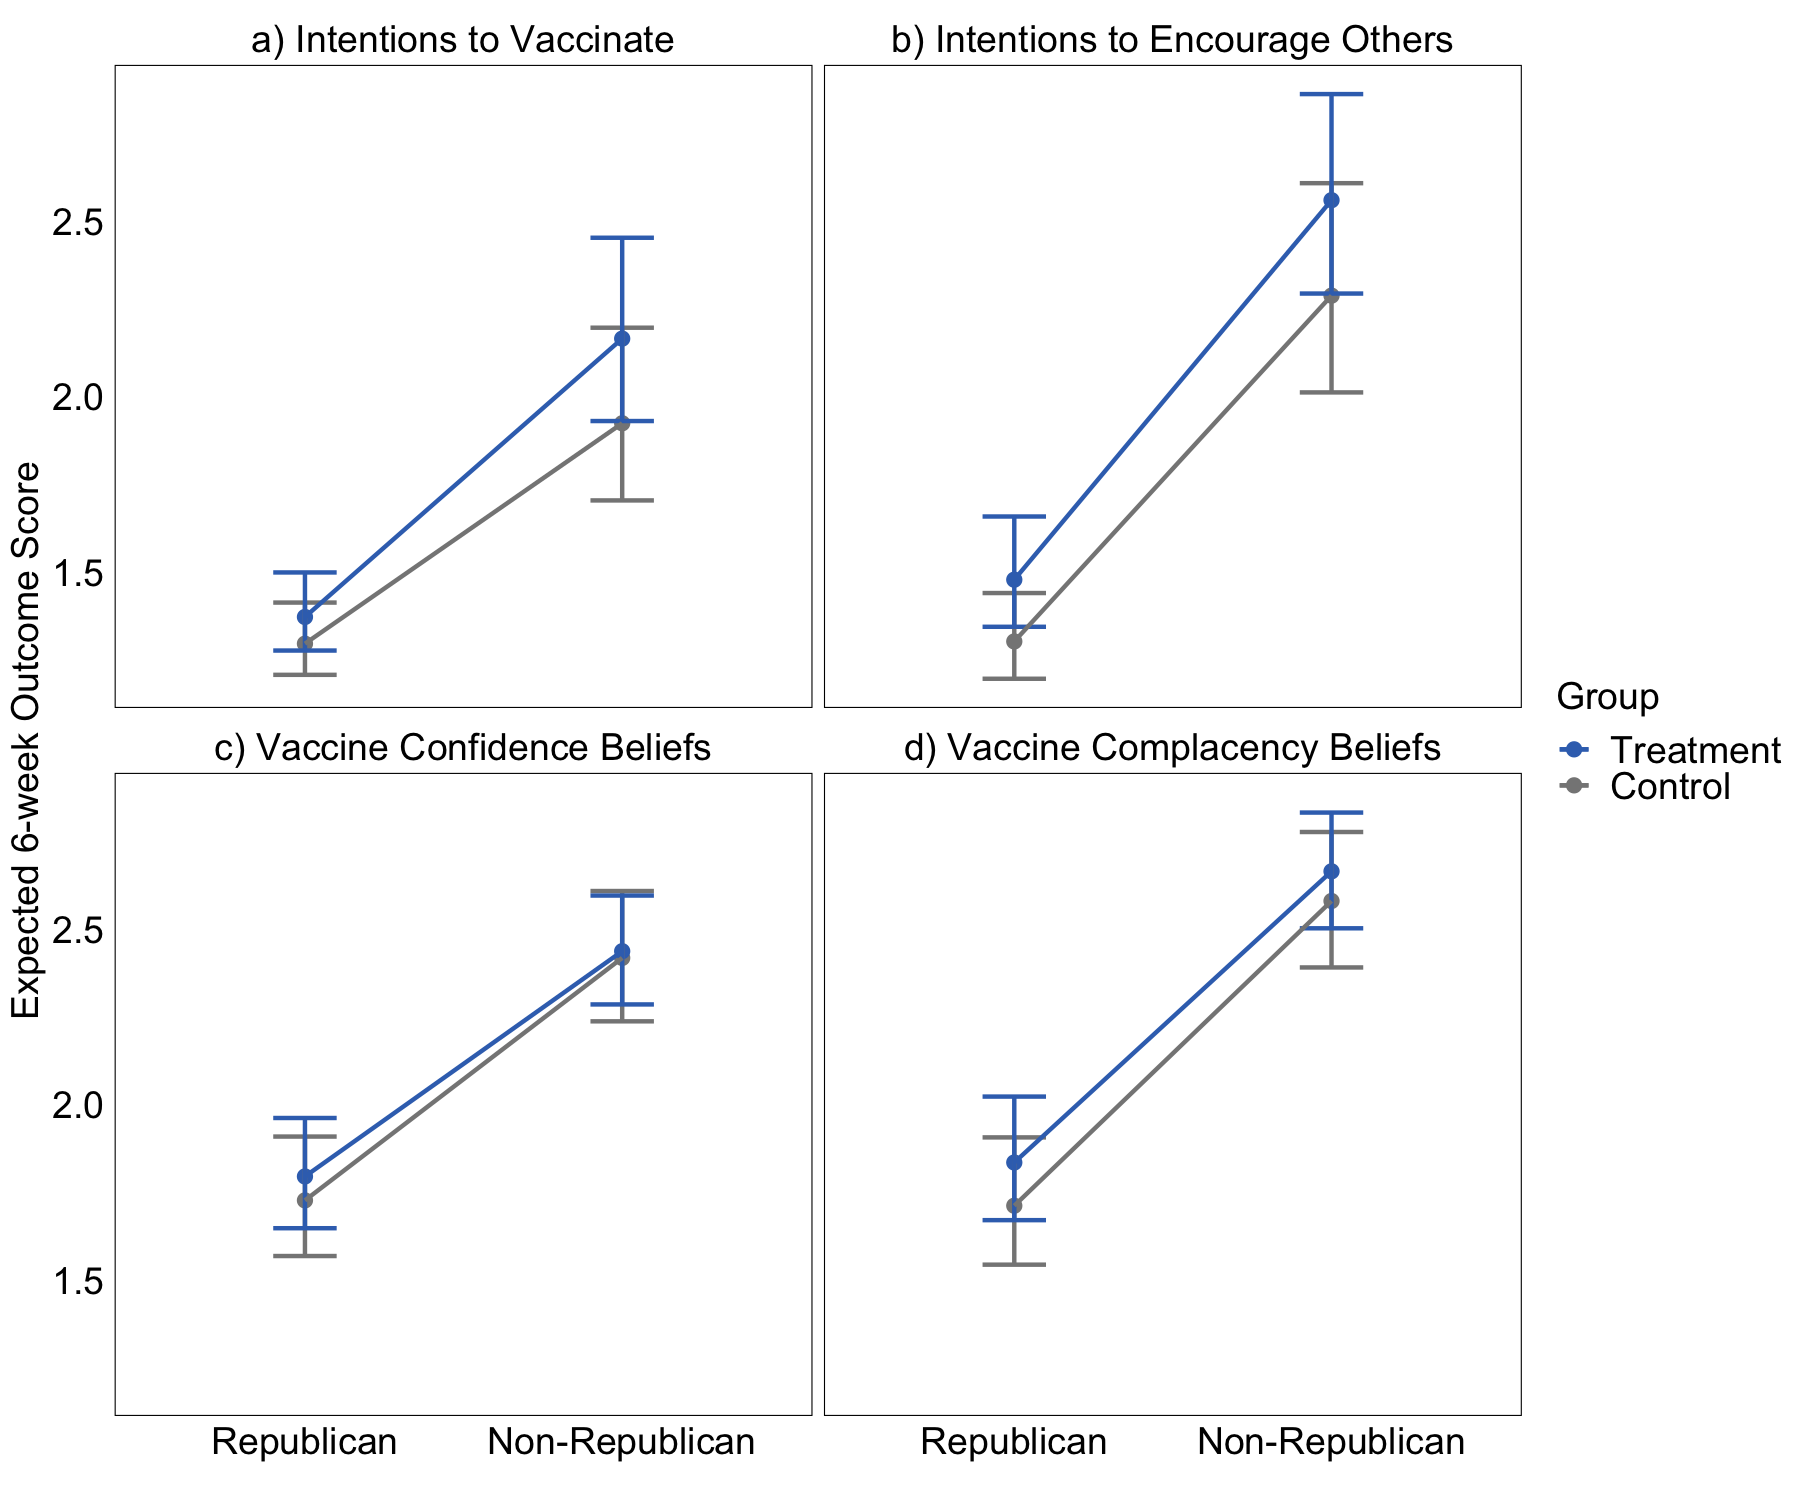

In [4]:
emm_intent1 <- rep$intention$emm_back %>% as_tibble() %>% 
                      mutate(level = "Republican", measure = "a) Intentions to Vaccinate")
emm_intent2 <- non_rep$intention$emm_back %>% as_tibble() %>% 
                              mutate(level = "Non-Republican", measure = "a) Intentions to Vaccinate")

emm_encourage1 <- rep$encourage$emm_back %>% as_tibble() %>% 
                          mutate(level = "Republican", measure = "b) Intentions to Encourage Others")
emm_encourage2 <- non_rep$encourage$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Non-Republican", measure = "b) Intentions to Encourage Others")

emm_conf1 <- rep$sp_confidence$emm_back %>% as_tibble() %>% 
                          mutate(level = "Republican", measure = "c) Vaccine Confidence Beliefs")
emm_conf2  <- non_rep$sp_confidence$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Non-Republican", measure = "c) Vaccine Confidence Beliefs")

emm_comp1 <- rep$sp_complacency$emm_back %>% as_tibble() %>% 
                          mutate(level = "Republican", measure = "d) Vaccine Complacency Beliefs")
emm_comp2  <- non_rep$sp_complacency$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Non-Republican", measure = "d) Vaccine Complacency Beliefs")

plot_df <- bind_rows(emm_intent1, emm_intent2, 
                     emm_encourage1, emm_encourage2, 
                     emm_conf1, emm_conf2,
                     emm_comp1, emm_comp2) %>%
            arrange(desc(group))
plot_df$level <- factor(plot_df$level, levels = c("Republican", "Non-Republican"))

options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)
ggplot() + 
    geom_point(data = plot_df, 
               mapping = aes(x = level, y = response, color = group), size = 3) +
    geom_errorbar(data = plot_df, 
                  mapping = aes(x = level, ymin=lower.CL, ymax=upper.CL, color = group), width=0.2,
                  linewidth = 1) +
    geom_line(data = plot_df, 
               mapping = aes(x = level, y = response, color = group, group = group), linewidth = 1) +
    theme_minimal() +
   labs(y = "Expected 6-week Outcome Score", x = "", color = "Group") + 
    theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_text(size = 18, color= "black"),
          axis.text.y = element_text(size = 18, color = "black"),
          axis.title.y = element_text(size = 18, colour = "black"),
          legend.text = element_text(size = 18, color= "black"),
          legend.title = element_text(size = 18, color= "black"),
          strip.text = element_text(size = 18, color= "black")
        ) +
    theme(panel.border=element_rect(linetype=1,fill=NA)) +
    scale_color_manual(values = c("#3A71BC", "#868686")) + 
    facet_wrap(~measure) + 
    guides(size = "none") 

In [5]:
test_interaction_republican <- function(data){
    
    data$group <- factor(data$group, levels = c("Control", "Treatment"))    
    
    # fit base model    
    base_model <- aov(post ~ group*republican + wave + 
                      #phi_trust_cat + conservative +  
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)   
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = "ml", lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group*republican + wave + 
                                  #phi_trust_cat + conservative +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))             
    
    lm_model <- with(bctrans,
              lm(linkfun(post) ~ group*republican + wave + 
                                  #phi_trust_cat + conservative +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))              
    
    mean <- model$coefficients[names(model$coefficients) %>% str_detect(":")]
    ci_tbl <- model %>% confint() %>% as_tibble()
    row_names <- model %>% confint() %>% rownames()
    idx <- which(row_names %>% str_detect(":"))
    low <- ci_tbl$`2.5 %`[idx]
    high <- ci_tbl$`97.5 %`[idx]
    idx <- which(rownames(car::Anova(model, type = "III")) %>% str_detect(":"))
    p <- car::Anova(model, type = "III")[[4]][idx]
    sig = ""
    if (p < 0.05){sig = "*"}
    if (p < 0.01){sig = "**"}
    if (p < 0.001){sig = "***"}
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "lm_model" = lm_model,
        "ci_summary" = ci_summary))}


plot_qqs_hist <- function(object){
    op <- par(pty = "s", mfrow = c(2, 2))
    qqnorm(object$base_model$residuals, main = "QQ-Plot Fit to Raw Scores")
    qqline(object$base_model$residuals)
    qqnorm(object$model$residuals, main = "QQ-Plot Fit to Transformed Scores")
    qqline(object$model$residuals)
    object$base_model$residuals %>% hist(main = "Residuals (Raw)", freq = FALSE)  
    object$model$residuals %>% hist(main = "Residuals (Transformed)", freq = FALSE)
}

In [6]:
intention <- test_interaction_republican(data = vcf_data %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n))
encourage <- test_interaction_republican(data = vcf_data %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n))
sp_confidence <- test_interaction_republican(data = vcf_data %>% dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n))
sp_complacency <- test_interaction_republican(data = vcf_data %>% dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n))

In [7]:
paste0("Intentions: ", intention$ci_summary)
paste0("Intentions to encourage: ", encourage$ci_summary)
paste0("Vaccine confidence beliefs: ", sp_confidence$ci_summary)
paste0("Vaccine complacency beliefs: ", sp_complacency$ci_summary)

[1] "Intentions: mean = 0.002; 95% CI = -0.101, 0.106; P = 0.9643"

[1] "Intentions to encourage: mean = -0.042; 95% CI = -0.19, 0.106; P = 0.5802"

[1] "Vaccine confidence beliefs: mean = -0.031; 95% CI = -0.201, 0.139; P = 0.7201"

[1] "Vaccine complacency beliefs: mean = -0.03; 95% CI = -0.225, 0.165; P = 0.7616"

In [8]:
car::Anova(intention$model , type = "III")
intention$lm_model %>% summary()

Sum Sq       Df  F value      Pr(>F)      
(Intercept)      1.357362e-01   1 2.248068e+00 1.346481e-01
group            9.908617e-02   1 1.641069e+00 2.009943e-01
republican       1.698544e-01   1 2.813136e+00 9.435392e-02
wave             3.325694e-03   1 5.508028e-02 8.145798e-01
linkfun(pre)     1.421710e+01   1 2.354642e+02 2.453215e-41
group:republican 1.213082e-04   1 2.009111e-03 9.642729e-01
Residuals        2.197796e+01 364           NA           NA


Call:
lm(formula = linkfun(post) ~ group * republican + wave + linkfun(pre), 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6467 -0.1138 -0.0710  0.1195  0.7335 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.047342   0.031575   1.499   0.1346    
groupTreatment                   0.052318   0.040840   1.281   0.2010    
republicannonrep                 0.066501   0.039649   1.677   0.0944 .  
waveWave 2                      -0.006588   0.028069  -0.235   0.8146    
linkfun(pre)                     0.696361   0.045381  15.345   <2e-16 ***
groupTreatment:republicannonrep  0.002356   0.052559   0.045   0.9643    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2457 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4303,	Adjusted R-squared:  0.4225 
F-statistic: 54.99 on 5 and 364 DF,  p-value: < 

In [9]:
intention$model %>% summary()

                  Df Sum Sq Mean Sq F value   Pr(>F)    
group              1  0.336   0.336   5.567   0.0188 *  
republican         1  2.022   2.022  33.489 1.55e-08 ***
wave               1  0.016   0.016   0.263   0.6086    
linkfun(pre)       1 14.227  14.227 235.634  < 2e-16 ***
group:republican   1  0.000   0.000   0.002   0.9643    
Residuals        364 21.978   0.060                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
1 observation deleted due to missingness

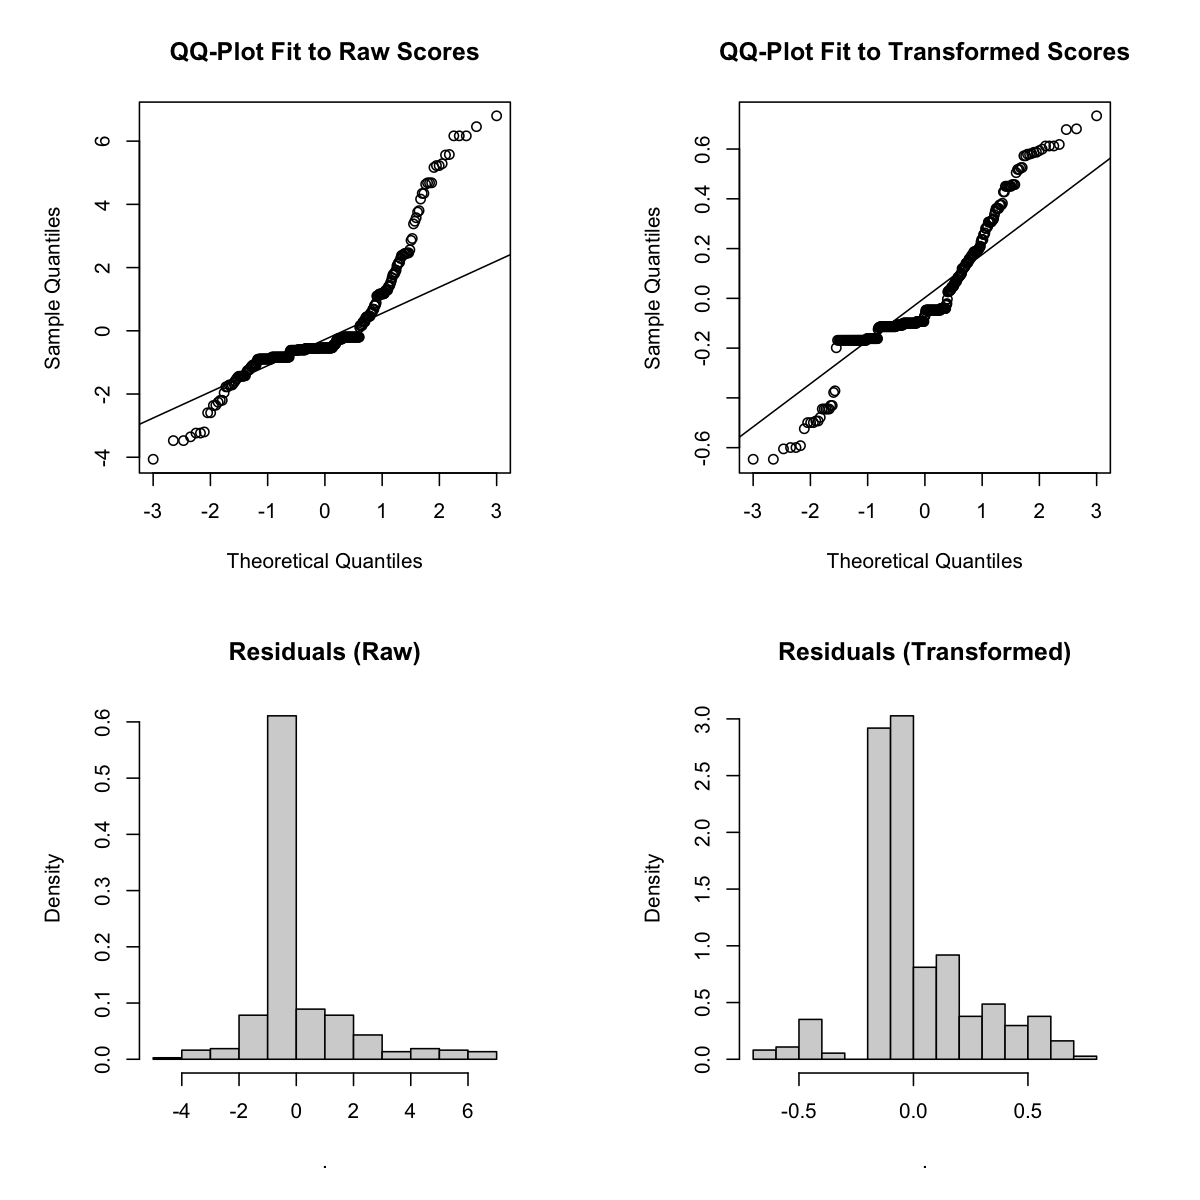

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
plot_qqs_hist(intention)


Call:
lm(formula = linkfun(post) ~ group * republican + wave + linkfun(pre), 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9018 -0.2589 -0.1029  0.2252  1.0340 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.10295    0.04569   2.253  0.02483 *  
groupTreatment                   0.12246    0.05859   2.090  0.03729 *  
republicannonrep                 0.15591    0.05645   2.762  0.00604 ** 
waveWave 2                      -0.06766    0.04030  -1.679  0.09403 .  
linkfun(pre)                     0.60172    0.04505  13.356  < 2e-16 ***
groupTreatment:republicannonrep -0.04172    0.07536  -0.554  0.58020    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3527 on 365 degrees of freedom
Multiple R-squared:  0.3915,	Adjusted R-squared:  0.3832 
F-statistic: 46.98 on 5 and 365 DF,  p-value: < 2.2e-16


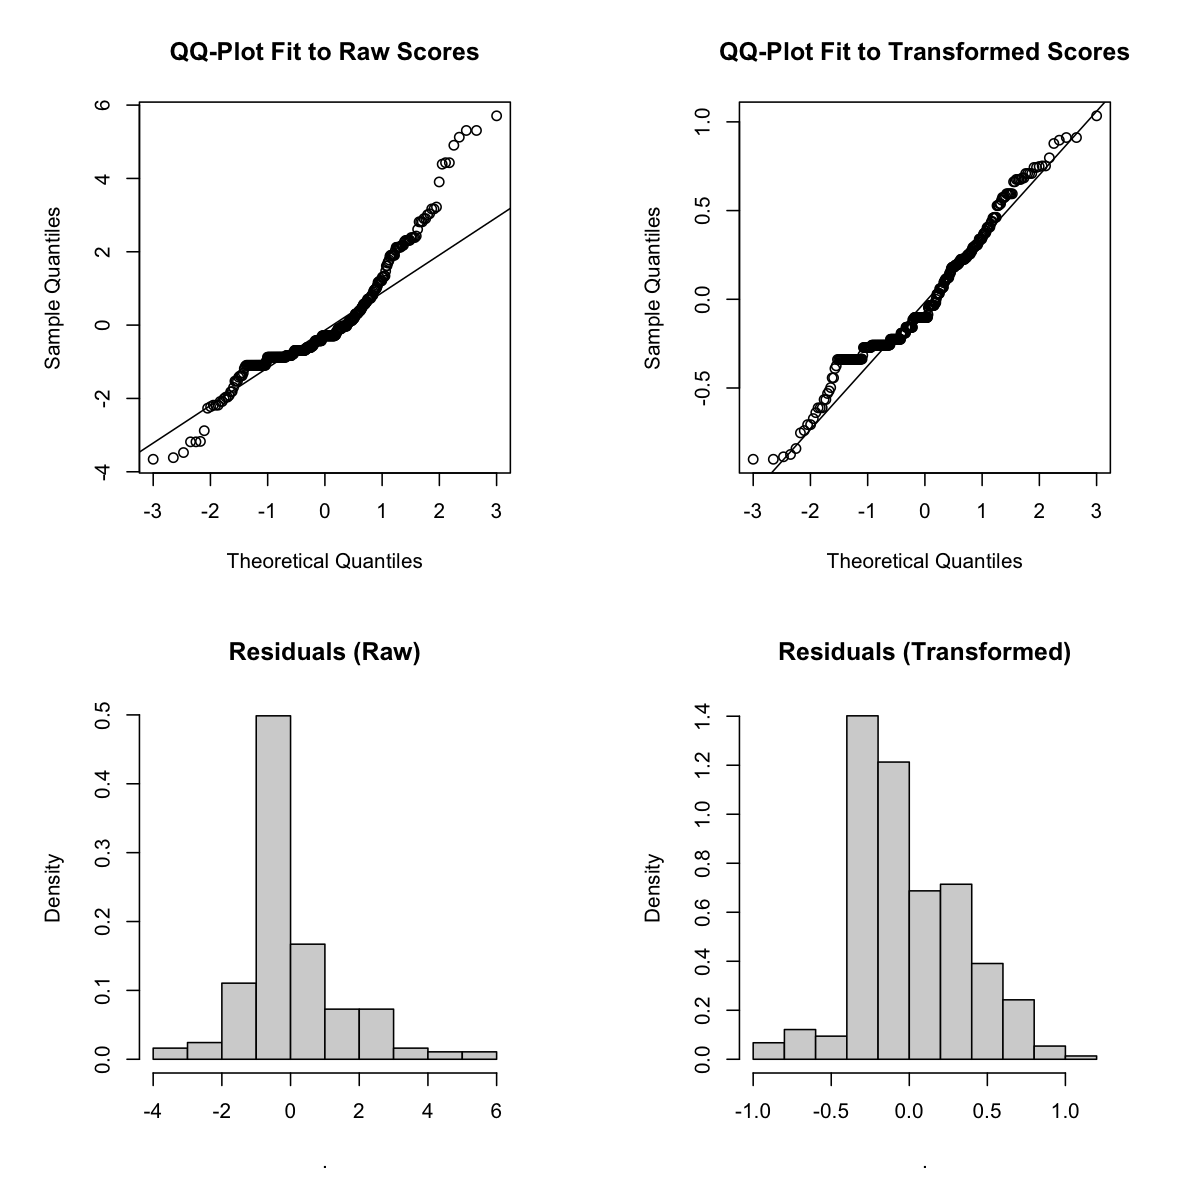

In [11]:
encourage$lm_model %>% summary()
plot_qqs_hist(encourage)


Call:
lm(formula = linkfun(post) ~ group * republican + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.28231 -0.28350 -0.05513  0.25406  1.47676 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.26074    0.05424   4.807 2.24e-06 ***
groupTreatment                   0.04300    0.06708   0.641   0.5219    
republicannonrep                 0.06274    0.06481   0.968   0.3337    
waveWave 2                      -0.10224    0.04618  -2.214   0.0275 *  
linkfun(pre)                     0.79774    0.04276  18.655  < 2e-16 ***
groupTreatment:republicannonrep -0.03097    0.08638  -0.359   0.7201    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4037 on 365 degrees of freedom
Multiple R-squared:  0.5263,	Adjusted R-squared:  0.5199 
F-statistic: 81.12 on 5 and 365 DF,  p-value: < 2.2e-16


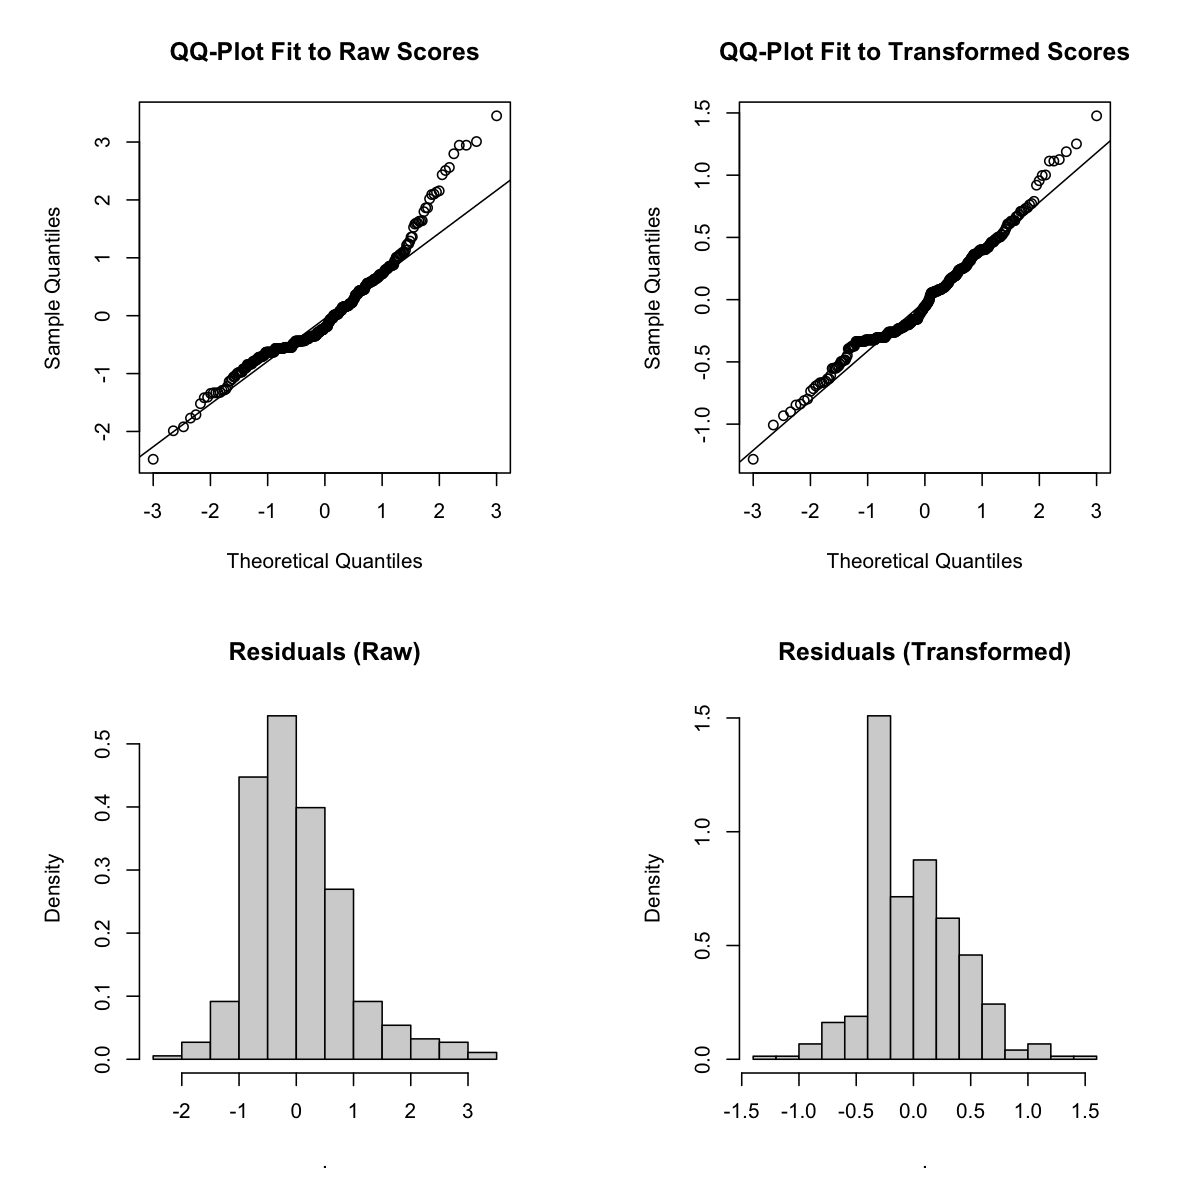

In [12]:
sp_confidence$lm_model %>% summary()
plot_qqs_hist(sp_confidence)


Call:
lm(formula = linkfun(post) ~ group * republican + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25453 -0.32280 -0.05719  0.30001  1.71090 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.25308    0.06225   4.065 5.88e-05 ***
groupTreatment                   0.07111    0.07686   0.925    0.355    
republicannonrep                 0.11193    0.07448   1.503    0.134    
waveWave 2                      -0.08467    0.05288  -1.601    0.110    
linkfun(pre)                     0.74022    0.04090  18.100  < 2e-16 ***
groupTreatment:republicannonrep -0.03004    0.09895  -0.304    0.762    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4627 on 365 degrees of freedom
Multiple R-squared:  0.5183,	Adjusted R-squared:  0.5117 
F-statistic: 78.56 on 5 and 365 DF,  p-value: < 2.2e-16


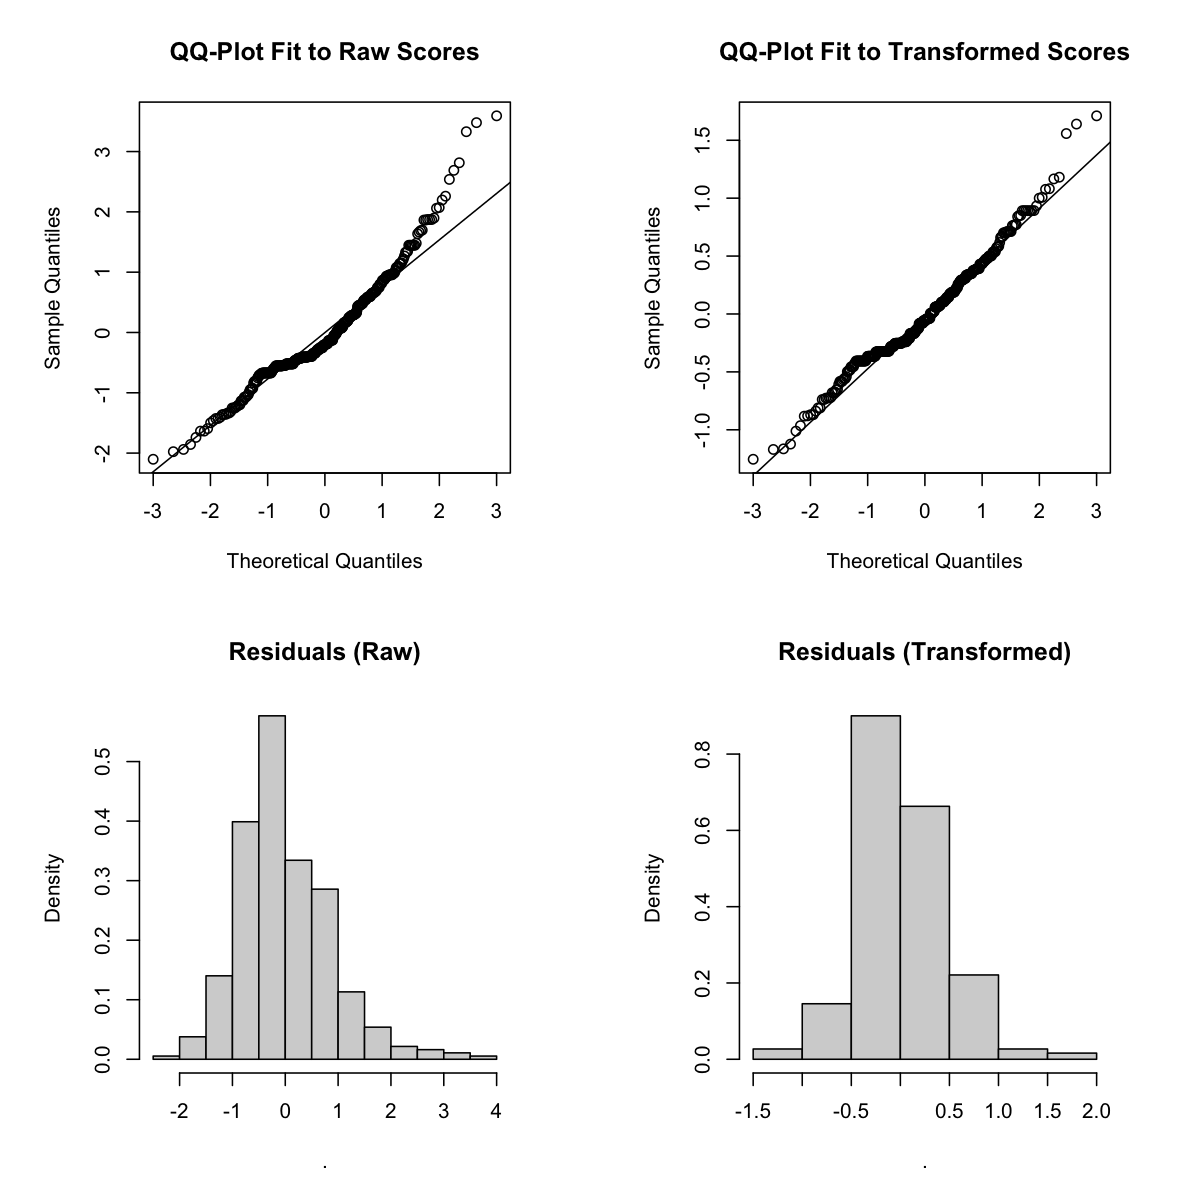

In [13]:
sp_complacency$lm_model %>% summary()
plot_qqs_hist(sp_complacency)

### Political Views Interactions

In [14]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      #republican + phi_trust_cat +
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  #republican + phi_trust_cat +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                      
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [15]:
conserv <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(conservative == "conserv"), 
                label = "Conservative", pad = 0.6)

non_conserv <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(conservative != "conserv"), 
                label = "Non-Conservative", pad = 0.6)

#### Interaction Plots

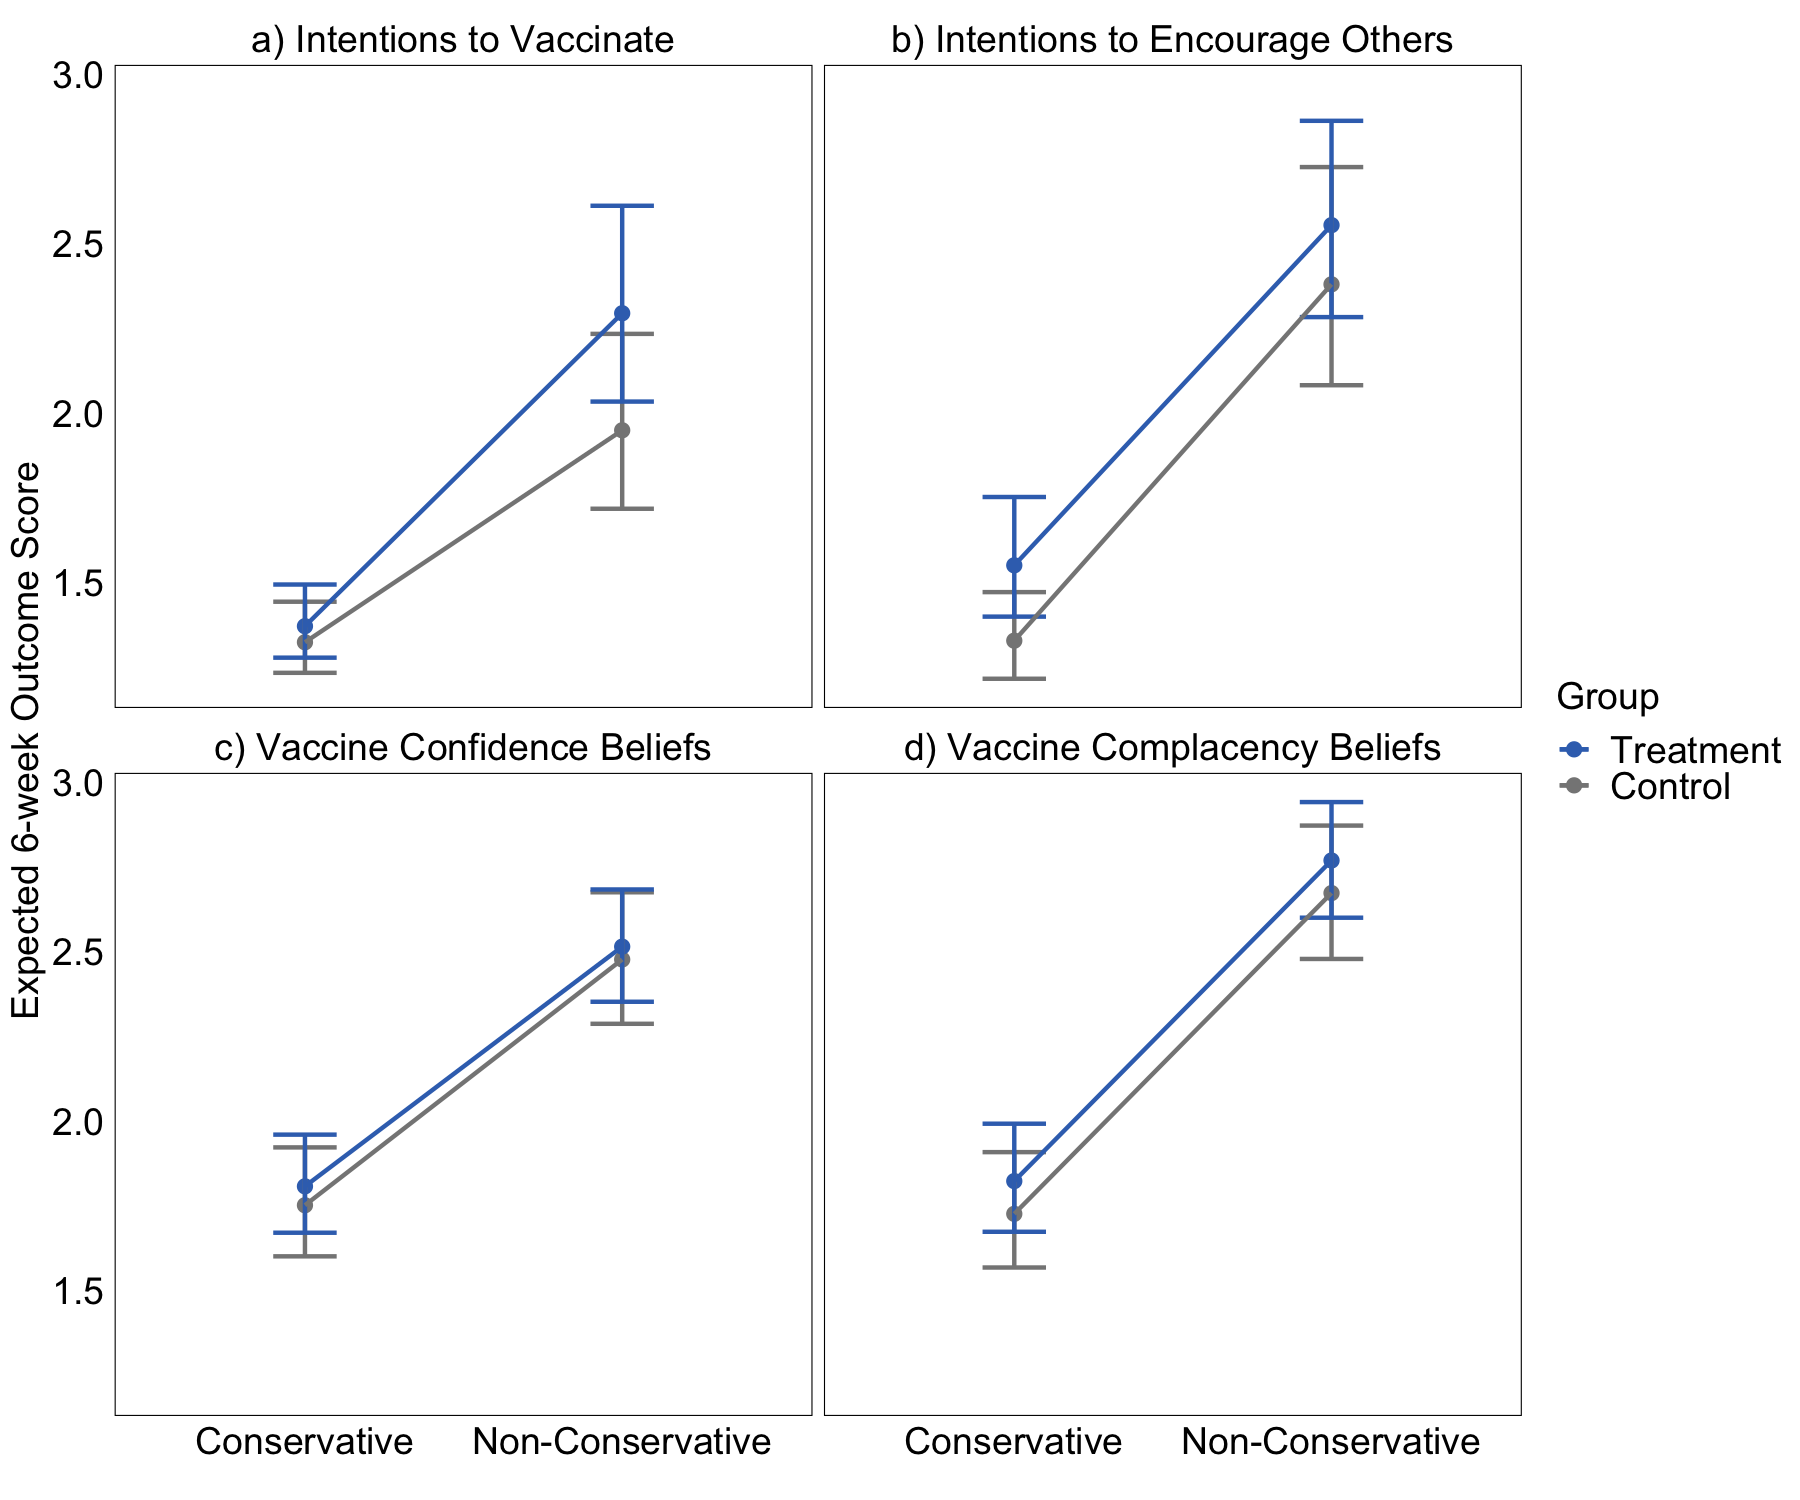

In [16]:
emm_intent1 <- conserv$intention$emm_back %>% as_tibble() %>% 
                      mutate(level = "Conservative", measure = "a) Intentions to Vaccinate")
emm_intent2 <- non_conserv$intention$emm_back %>% as_tibble() %>% 
                              mutate(level = "Non-Conservative", measure = "a) Intentions to Vaccinate")

emm_encourage1 <- conserv$encourage$emm_back %>% as_tibble() %>% 
                          mutate(level = "Conservative", measure = "b) Intentions to Encourage Others")
emm_encourage2 <- non_conserv$encourage$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Non-Conservative", measure = "b) Intentions to Encourage Others")

emm_conf1 <- conserv$sp_confidence$emm_back %>% as_tibble() %>% 
                          mutate(level = "Conservative", measure = "c) Vaccine Confidence Beliefs")
emm_conf2  <- non_conserv$sp_confidence$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Non-Conservative", measure = "c) Vaccine Confidence Beliefs")

emm_comp1 <- conserv$sp_complacency$emm_back %>% as_tibble() %>% 
                          mutate(level = "Conservative", measure = "d) Vaccine Complacency Beliefs")
emm_comp2  <- non_conserv$sp_complacency$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Non-Conservative", measure = "d) Vaccine Complacency Beliefs")

plot_df <- bind_rows(emm_intent1, emm_intent2, 
                     emm_encourage1, emm_encourage2, 
                     emm_conf1, emm_conf2,
                     emm_comp1, emm_comp2) %>%
            arrange(desc(group))
plot_df$level <- factor(plot_df$level, levels = c("Conservative", "Non-Conservative"))

options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)
ggplot() + 
    geom_point(data = plot_df, 
               mapping = aes(x = level, y = response, color = group), size = 3) +
    geom_errorbar(data = plot_df, 
                  mapping = aes(x = level, ymin=lower.CL, ymax=upper.CL, color = group), width=0.2,
                  linewidth = 1) +
    geom_line(data = plot_df, 
               mapping = aes(x = level, y = response, color = group, group = group), linewidth = 1) +
    theme_minimal() +
   labs(y = "Expected 6-week Outcome Score", x = "", color = "Group") + 
    theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_text(size = 18, color= "black"),
          axis.text.y = element_text(size = 18, color = "black"),
          axis.title.y = element_text(size = 18, colour = "black"),
          legend.text = element_text(size = 18, color= "black"),
          legend.title = element_text(size = 18, color= "black"),
          strip.text = element_text(size = 18, color= "black")
        ) +
    theme(panel.border=element_rect(linetype=1,fill=NA)) +
    scale_color_manual(values = c("#3A71BC", "#868686")) + 
    facet_wrap(~measure) + 
    guides(size = "none") 

In [17]:
test_interaction_conservative <- function(data){
    
    data$group <- factor(data$group, levels = c("Control", "Treatment"))    
    data$conservative <- factor(data$conservative,
                                levels = c("conserv", "nonconserv"))
    
    # fit base model    
    base_model <- aov(post ~ group*conservative + wave + 
                      #phi_trust_cat + republican +  
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = "ml", lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group*conservative + wave + 
                                  #phi_trust_cat + republican +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))     
    
    lm_model <- with(bctrans,
              lm(linkfun(post) ~ group*conservative + wave + 
                                  #phi_trust_cat + republican +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))     
    
    mean <- model$coefficients[names(model$coefficients) %>% str_detect(":")]
    ci_tbl <- model %>% confint() %>% as_tibble()
    row_names <- model %>% confint() %>% rownames()
    idx <- which(row_names %>% str_detect(":"))
    low <- ci_tbl$`2.5 %`[idx]
    high <- ci_tbl$`97.5 %`[idx]
    idx <- which(rownames(car::Anova(model, type = "III")) %>% str_detect(":"))
    p <- car::Anova(model, type = "III")[[4]][idx]
    sig = ""
    if (p < 0.05){sig = "*"}
    if (p < 0.01){sig = "**"}
    if (p < 0.001){sig = "***"}
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "lm_model" = lm_model, 
        "ci_summary" = ci_summary))}

In [18]:
intention <- test_interaction_conservative(data = vcf_data %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n))
encourage <- test_interaction_conservative(data = vcf_data %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n))
sp_confidence <- test_interaction_conservative(data = vcf_data %>% dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n))
sp_complacency <- test_interaction_conservative(data = vcf_data %>% dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n))

In [19]:
paste0("Intentions: ", intention$ci_summary)
paste0("Intentions to encourage: ", encourage$ci_summary)
paste0("Vaccine confidence beliefs: ", sp_confidence$ci_summary)
paste0("Vaccine complacency beliefs: ", sp_complacency$ci_summary)

[1] "Intentions: mean = 0.039; 95% CI = -0.063, 0.14; P = 0.4513"

[1] "Intentions to encourage: mean = -0.092; 95% CI = -0.239, 0.056; P = 0.2238"

[1] "Vaccine confidence beliefs: mean = -0.013; 95% CI = -0.18, 0.155; P = 0.8834"

[1] "Vaccine complacency beliefs: mean = -0.017; 95% CI = -0.207, 0.174; P = 0.8641"


Call:
lm(formula = linkfun(post) ~ group * conservative + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65776 -0.11194 -0.06067  0.10731  0.72053 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.060669   0.029836   2.033   0.0427 *  
groupTreatment                         0.033295   0.038330   0.869   0.3856    
conservativenonconserv                 0.051274   0.038898   1.318   0.1883    
waveWave 2                            -0.008238   0.028000  -0.294   0.7688    
linkfun(pre)                           0.689469   0.045601  15.120   <2e-16 ***
groupTreatment:conservativenonconserv  0.038898   0.051586   0.754   0.4513    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2452 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.433,	Adjusted R-squared:  0.4

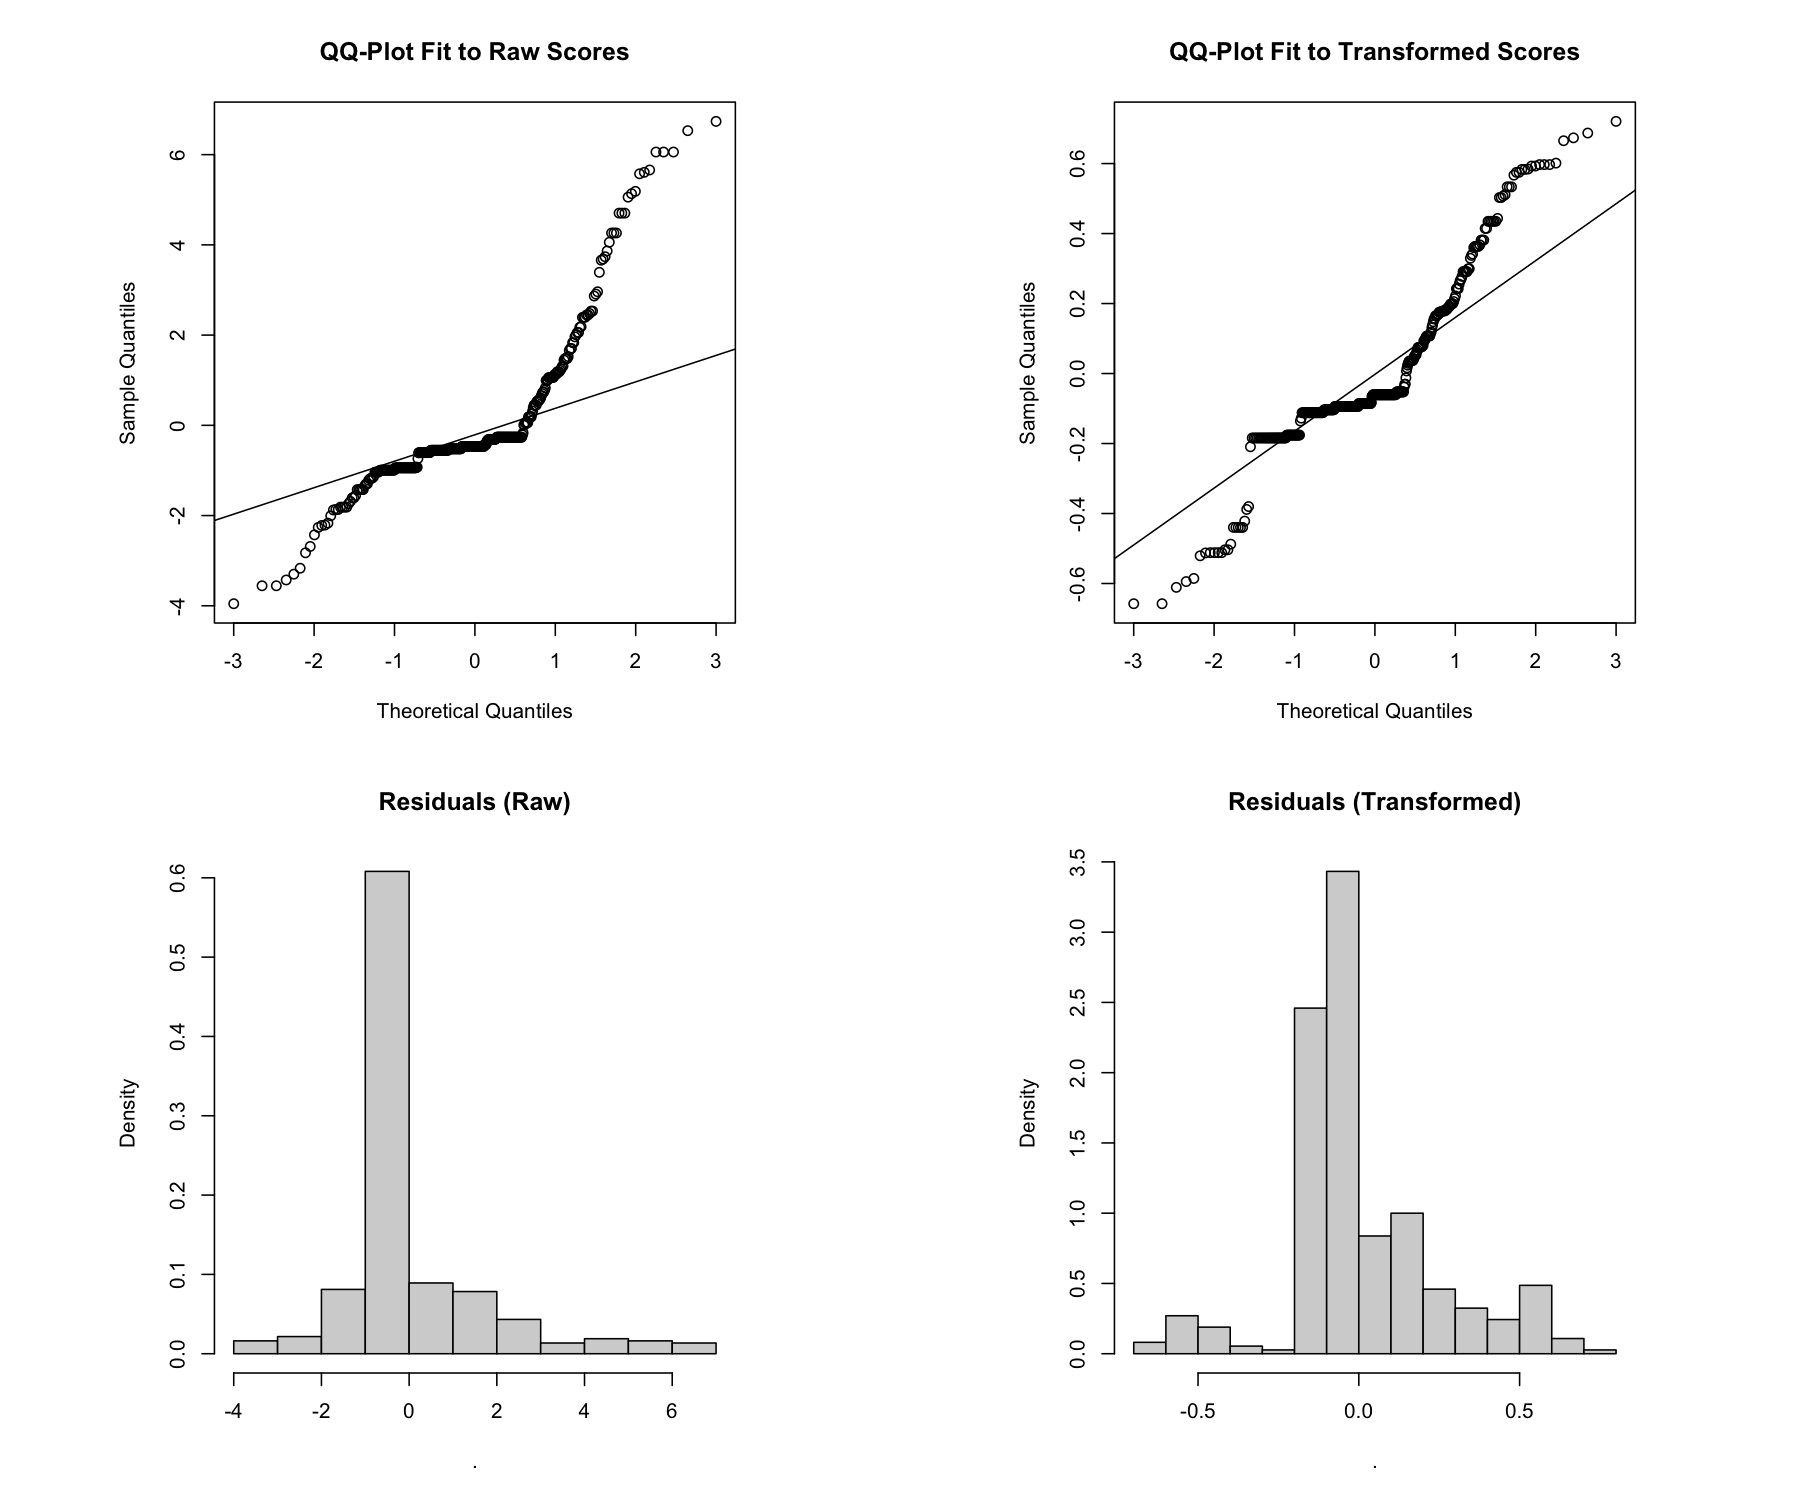

In [20]:
intention$lm_model %>% summary()
plot_qqs_hist(intention)


Call:
lm(formula = linkfun(post) ~ group * conservative + wave + linkfun(pre), 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8941 -0.2591 -0.1201  0.2496  1.0201 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.12008    0.04341   2.766  0.00597 ** 
groupTreatment                         0.14833    0.05549   2.673  0.00785 ** 
conservativenonconserv                 0.13899    0.05602   2.481  0.01356 *  
waveWave 2                            -0.07291    0.04067  -1.793  0.07383 .  
linkfun(pre)                           0.60985    0.04636  13.153  < 2e-16 ***
groupTreatment:conservativenonconserv -0.09155    0.07513  -1.219  0.22378    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3561 on 365 degrees of freedom
Multiple R-squared:  0.3826,	Adjusted R-squared:  0.3741 
F-statistic: 45.24 on 5 and 365 DF,  p-value: < 2.2e-16


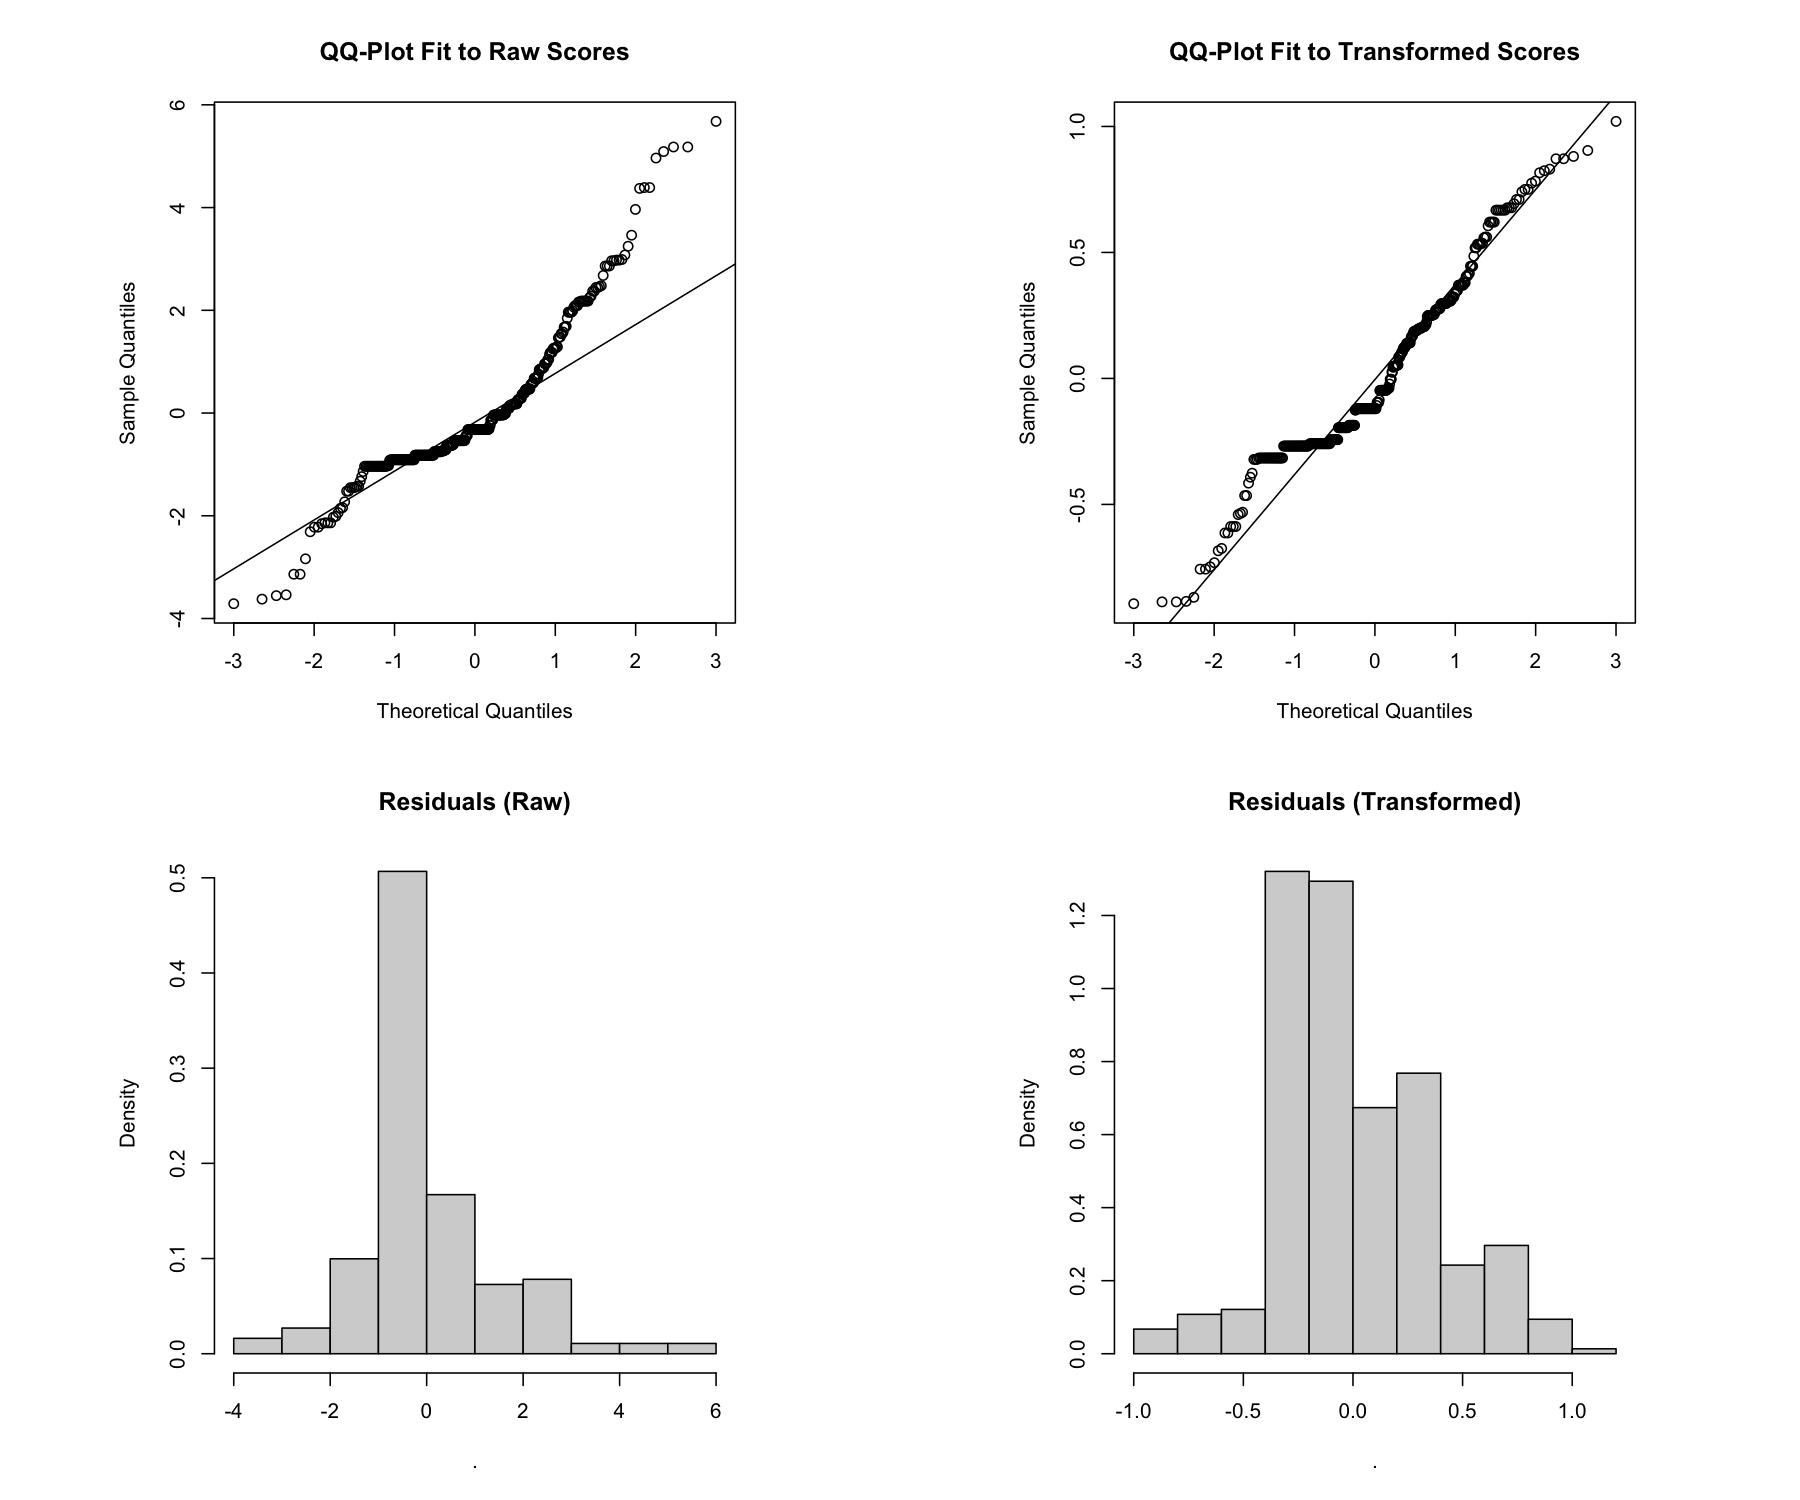

In [21]:
encourage$lm_model %>% summary()
plot_qqs_hist(encourage)


Call:
lm(formula = linkfun(post) ~ group * conservative + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24707 -0.28033 -0.06499  0.24145  1.51579 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.24727    0.05187   4.767  2.7e-06 ***
groupTreatment                         0.03305    0.06299   0.525   0.6001    
conservativenonconserv                 0.10990    0.06353   1.730   0.0845 .  
waveWave 2                            -0.10510    0.04625  -2.272   0.0236 *  
linkfun(pre)                           0.78579    0.04234  18.559  < 2e-16 ***
groupTreatment:conservativenonconserv -0.01251    0.08523  -0.147   0.8834    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4044 on 365 degrees of freedom
Multiple R-squared:  0.5319,	Adjusted R-squared:  0.5254 
F-statistic: 82.93 on 5 and 365 DF,  p-value: 

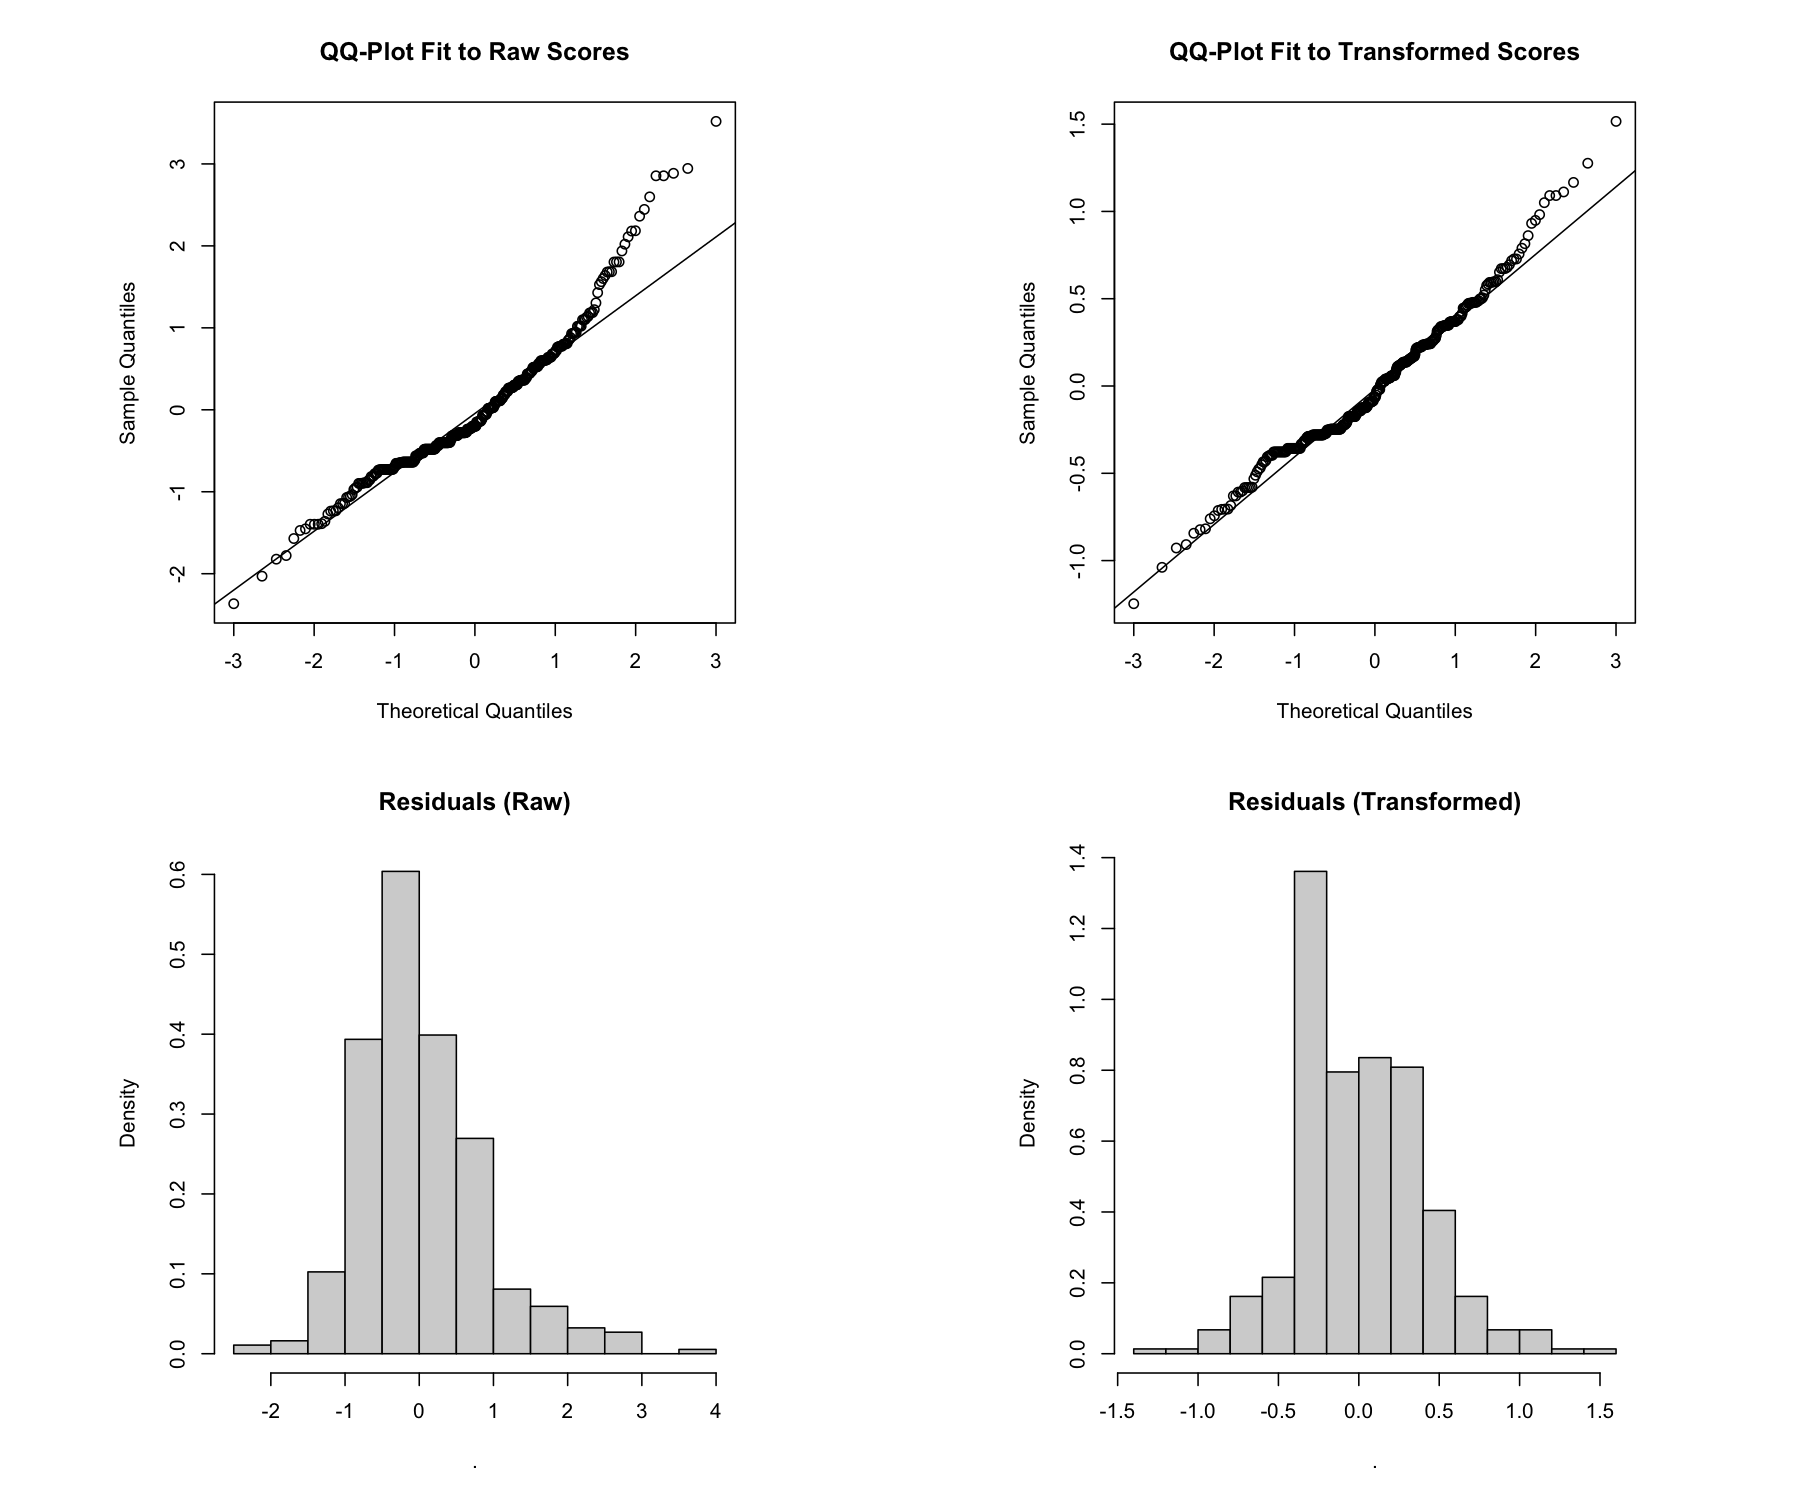

In [22]:
sp_confidence$lm_model %>% summary()
plot_qqs_hist(sp_confidence)


Call:
lm(formula = linkfun(post) ~ group * conservative + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.21522 -0.29970 -0.02798  0.28743  1.74047 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.23552    0.05896   3.995 7.83e-05 ***
groupTreatment                         0.06417    0.07169   0.895   0.3713    
conservativenonconserv                 0.17755    0.07260   2.446   0.0149 *  
waveWave 2                            -0.08861    0.05259  -1.685   0.0929 .  
linkfun(pre)                           0.72546    0.04037  17.971  < 2e-16 ***
groupTreatment:conservativenonconserv -0.01659    0.09685  -0.171   0.8641    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4603 on 365 degrees of freedom
Multiple R-squared:  0.5285,	Adjusted R-squared:  0.522 
F-statistic: 81.82 on 5 and 365 DF,  p-value: <

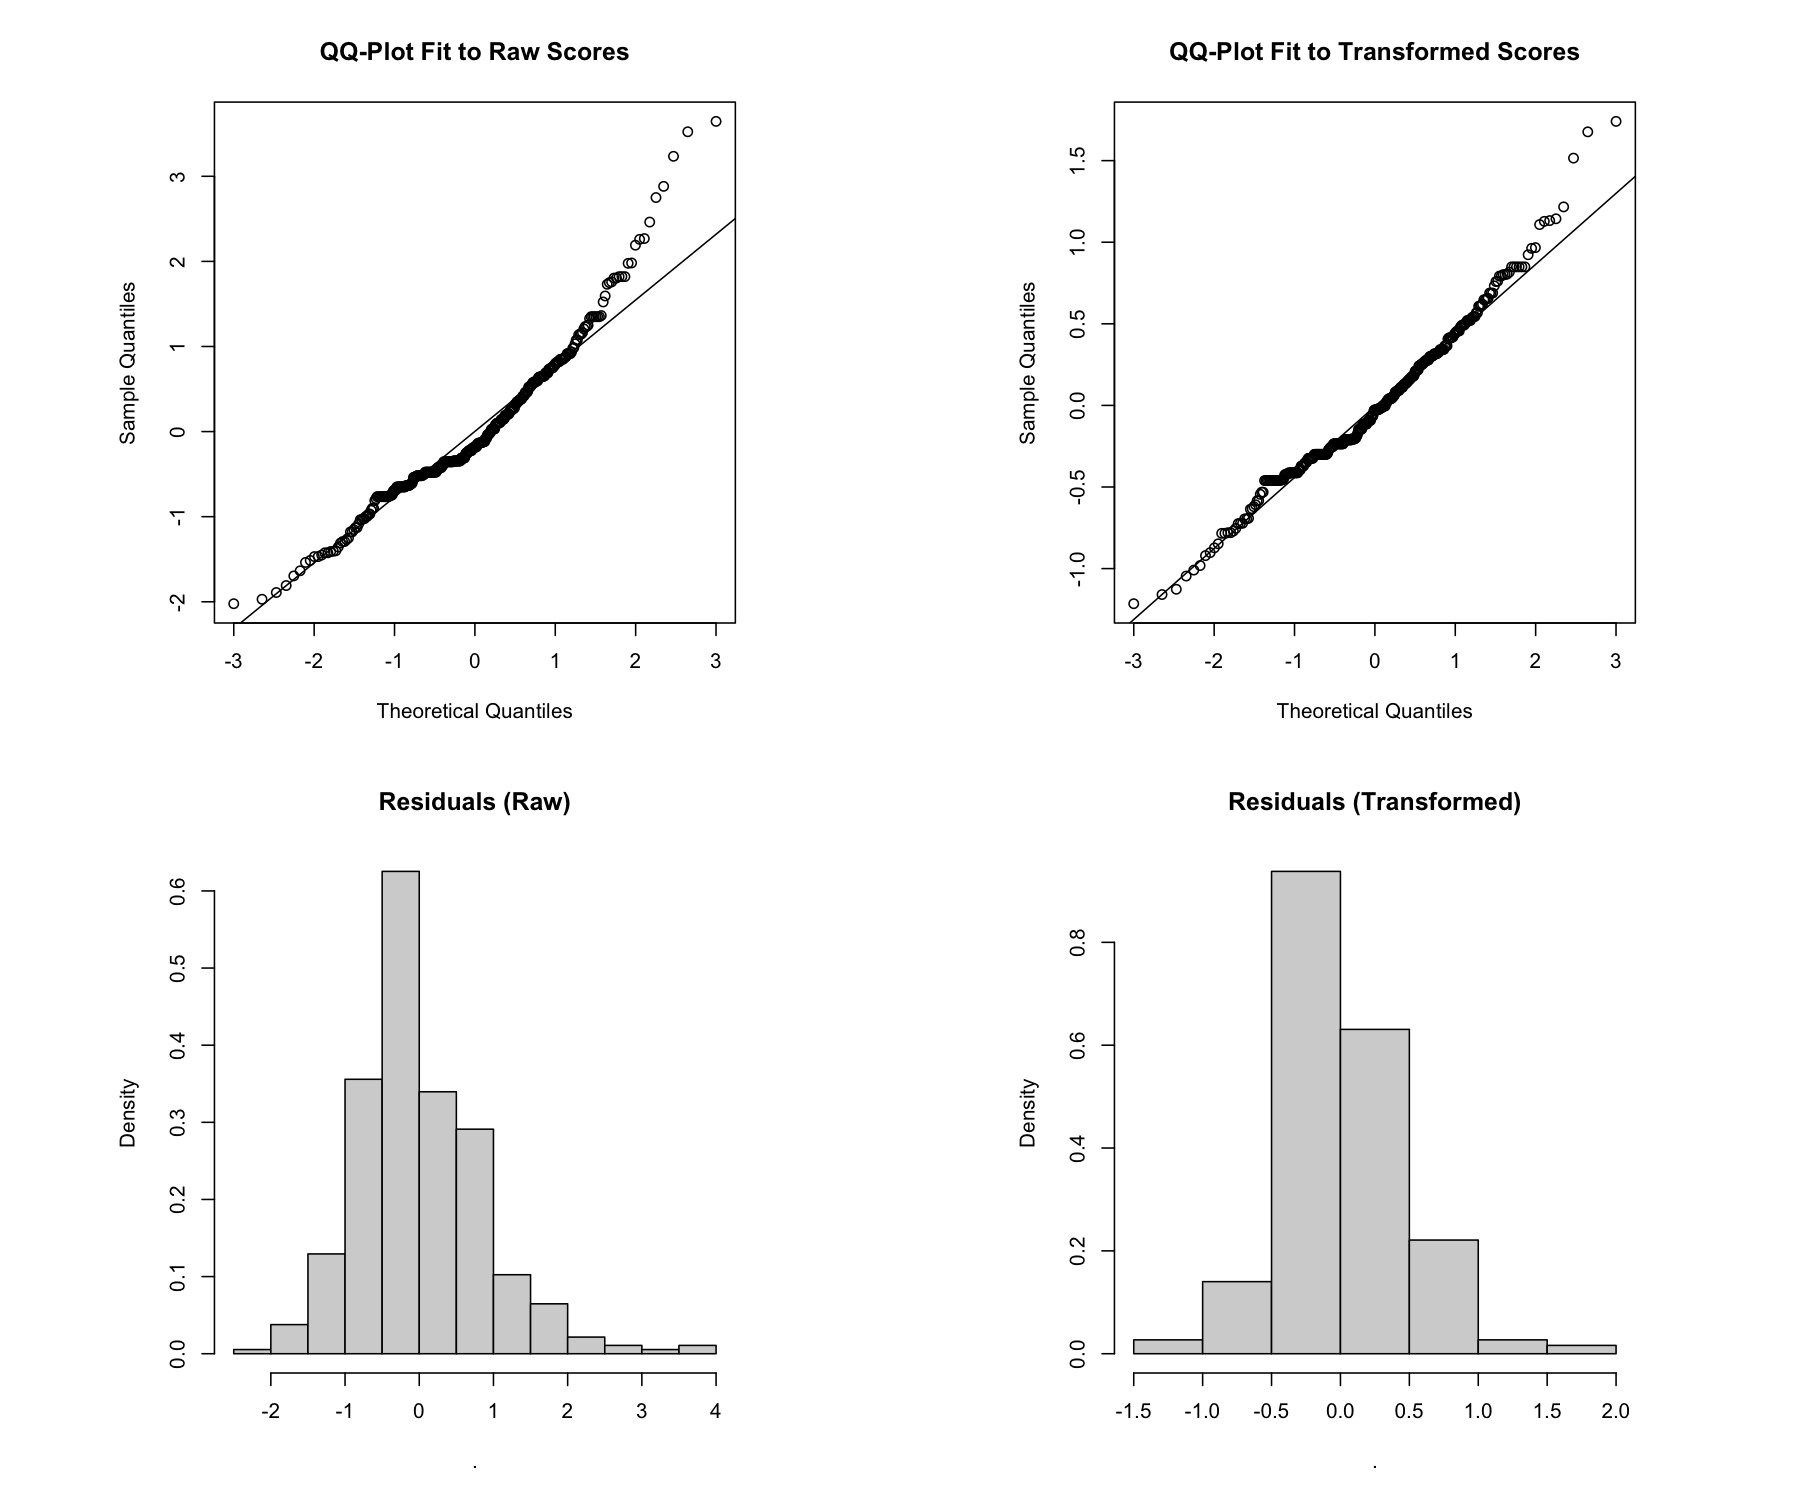

In [23]:
sp_complacency$lm_model %>% summary()
plot_qqs_hist(sp_complacency)

### Gov Trust Interactions

In [24]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      #republican + conservative + 
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  #republican + conservative +  
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                 
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [25]:
gov_distrust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(gov_trust_cat == "distrusting"), 
                label = "Distrusting", pad = 0.6)

gov_trust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(gov_trust_cat == "trusting"), 
                label = "Trusting", pad = 0.6)

#### Interaction Plots

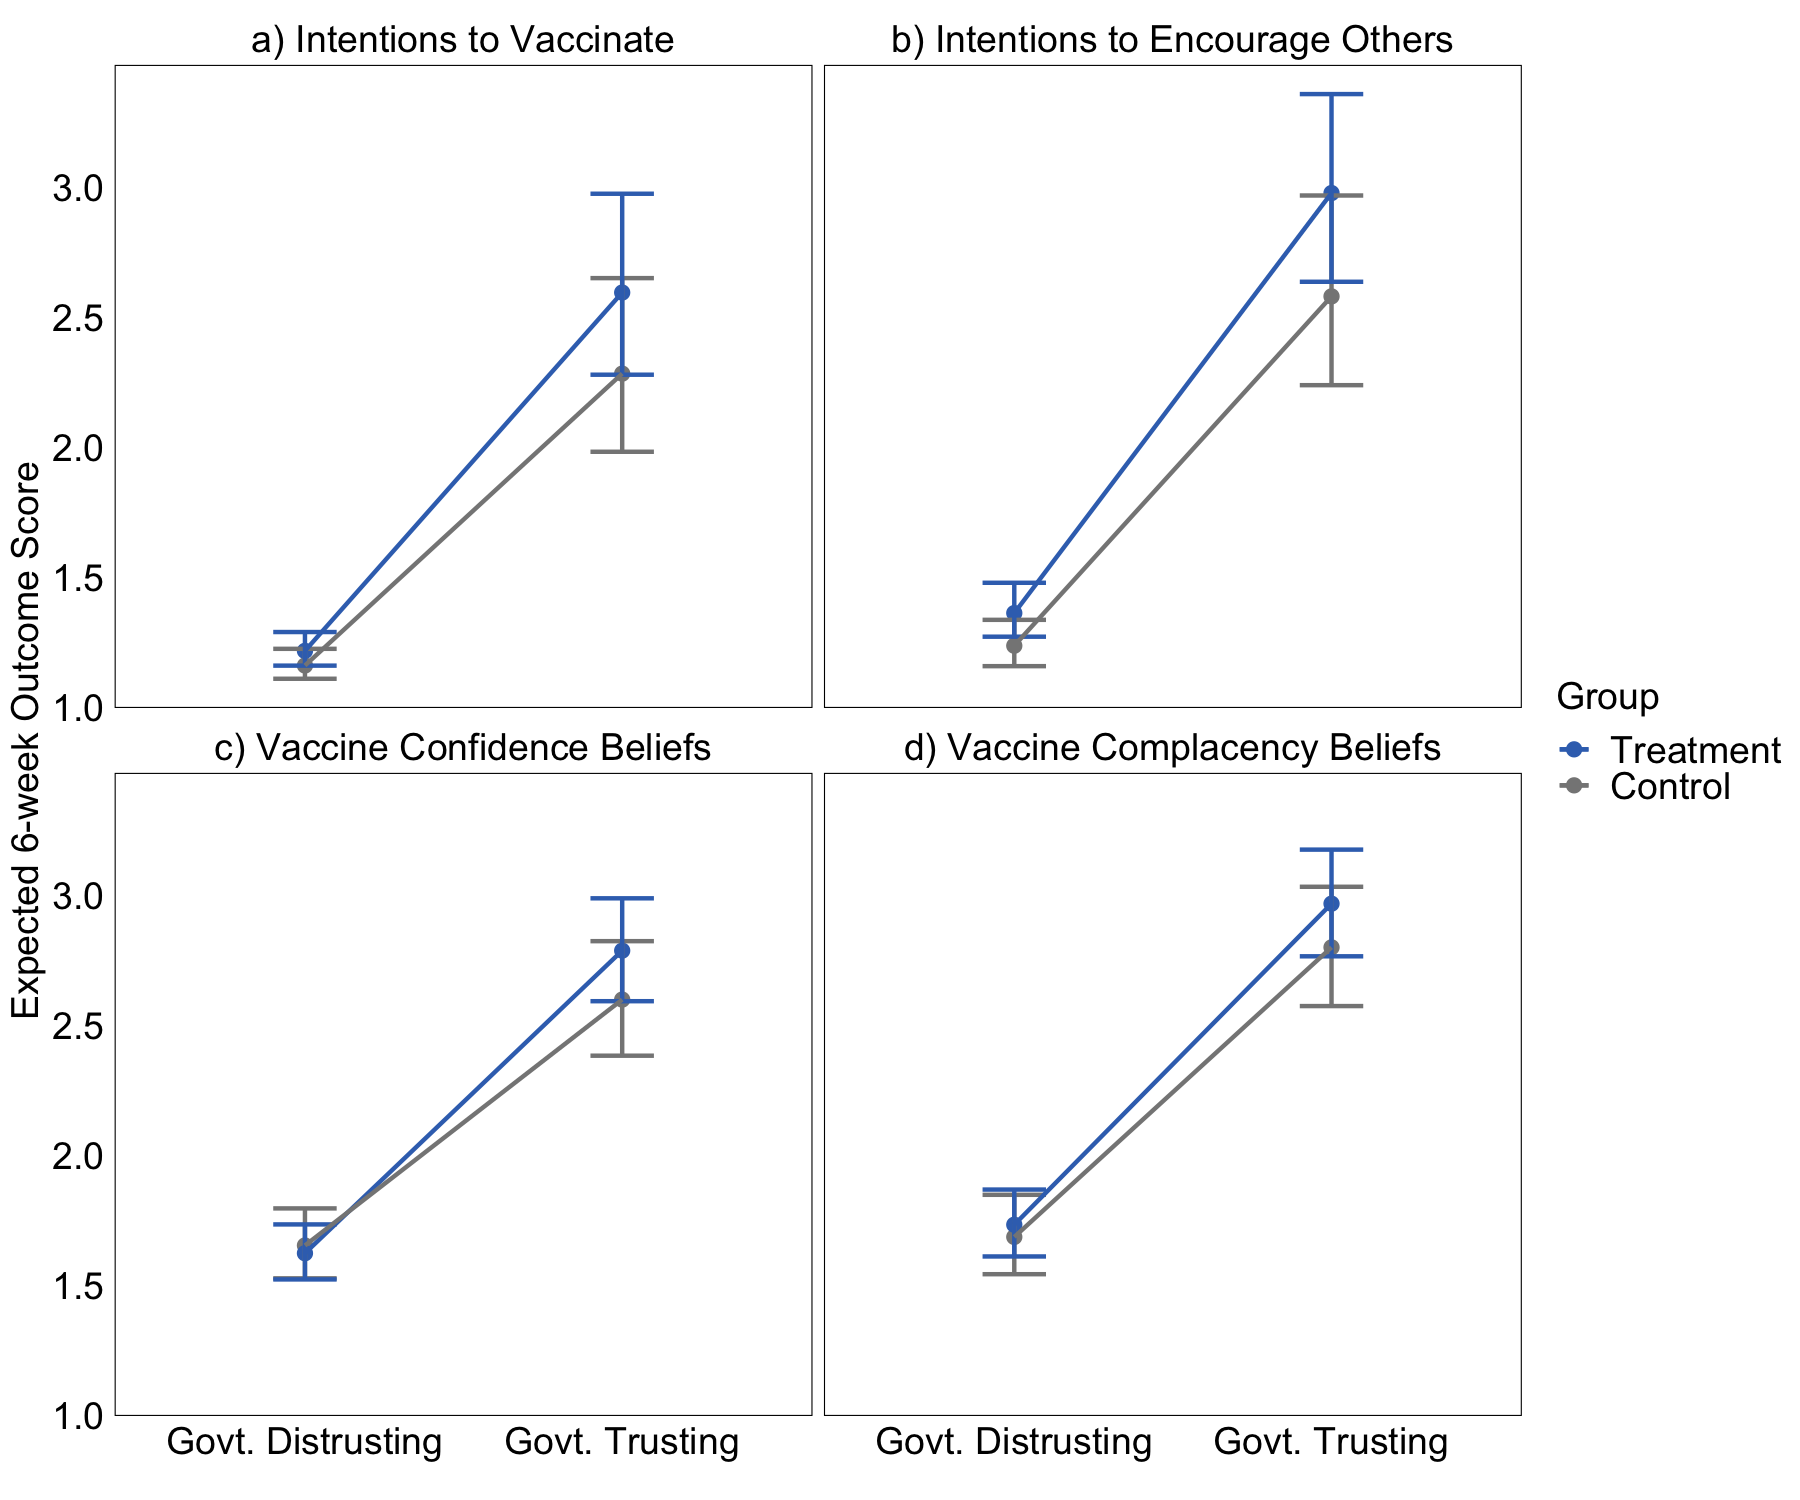

In [26]:
emm_intent1 <- gov_distrust$intention$emm_back %>% as_tibble() %>% 
                      mutate(level = "Govt. Distrusting", measure = "a) Intentions to Vaccinate")
emm_intent2 <- gov_trust$intention$emm_back %>% as_tibble() %>% 
                              mutate(level = "Govt. Trusting", measure = "a) Intentions to Vaccinate")

emm_encourage1 <- gov_distrust$encourage$emm_back %>% as_tibble() %>% 
                          mutate(level = "Govt. Distrusting", measure = "b) Intentions to Encourage Others")
emm_encourage2 <- gov_trust$encourage$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Govt. Trusting", measure = "b) Intentions to Encourage Others")

emm_conf1 <- gov_distrust$sp_confidence$emm_back %>% as_tibble() %>% 
                          mutate(level = "Govt. Distrusting", measure = "c) Vaccine Confidence Beliefs")
emm_conf2  <- gov_trust$sp_confidence$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Govt. Trusting", measure = "c) Vaccine Confidence Beliefs")

emm_comp1 <- gov_distrust$sp_complacency$emm_back %>% as_tibble() %>% 
                          mutate(level = "Govt. Distrusting", measure = "d) Vaccine Complacency Beliefs")
emm_comp2  <- gov_trust$sp_complacency$emm_back %>% as_tibble() %>% 
                                  mutate(level = "Govt. Trusting", measure = "d) Vaccine Complacency Beliefs")

plot_df <- bind_rows(emm_intent1, emm_intent2, 
                     emm_encourage1, emm_encourage2, 
                     emm_conf1, emm_conf2,
                     emm_comp1, emm_comp2) %>%
            arrange(desc(group))
plot_df$level <- factor(plot_df$level, levels = c("Govt. Distrusting", "Govt. Trusting"))

options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)
ggplot() + 
    geom_point(data = plot_df, 
               mapping = aes(x = level, y = response, color = group), size = 3) +
    geom_errorbar(data = plot_df, 
                  mapping = aes(x = level, ymin=lower.CL, ymax=upper.CL, color = group), width=0.2, 
                  linewidth = 1) +
    geom_line(data = plot_df, 
               mapping = aes(x = level, y = response, color = group, group = group), linewidth = 1) +
    theme_minimal() +
    labs(y = "Expected 6-week Outcome Score", x = "", color = "Group") + 
    theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_text(size = 18, color= "black"),
          axis.text.y = element_text(size = 18, color = "black"),
          axis.title.y = element_text(size = 18, colour = "black"),
          legend.text = element_text(size = 18, color= "black"),
          legend.title = element_text(size = 18, color= "black"),
          strip.text = element_text(size = 18, color= "black")
        ) +
    theme(panel.border=element_rect(linetype=1,fill=NA)) +
    scale_color_manual(values = c("#3A71BC", "#868686")) + 
    facet_wrap(~measure) + 
    guides(size = "none") 

In [27]:
test_interaction_gov_trust <- function(data){
    
    data$group <- factor(data$group, levels = c("Control", "Treatment"))    
    
    # fit base model    
    base_model <- aov(post ~ group*gov_trust_cat + wave + 
                      #republican + conservative + 
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = "ml", lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group*gov_trust_cat + wave + 
                                  #republican + conservative + 
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data)) 
    
    lm_model <- with(bctrans,
              lm(linkfun(post) ~ group*gov_trust_cat + wave + 
                                  #republican + conservative + 
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data)) 
    
    mean <- model$coefficients[names(model$coefficients) %>% str_detect(":")]
    ci_tbl <- model %>% confint() %>% as_tibble()
    row_names <- model %>% confint() %>% rownames()
    idx <- which(row_names %>% str_detect(":"))
    low <- ci_tbl$`2.5 %`[idx]
    high <- ci_tbl$`97.5 %`[idx]
    idx <- which(rownames(car::Anova(model, type = "III")) %>% str_detect(":"))
    p <- car::Anova(model, type = "III")[[4]][idx]
    sig = ""
    if (p < 0.05){sig = "*"}
    if (p < 0.01){sig = "**"}
    if (p < 0.001){sig = "***"}
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "lm_model" = lm_model,
        "ci_summary" = ci_summary))}

In [28]:
intention <- test_interaction_gov_trust(data = vcf_data %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n))
encourage <- test_interaction_gov_trust(data = vcf_data %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n))
sp_confidence <- test_interaction_gov_trust(data = vcf_data %>% dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n))
sp_complacency <- test_interaction_gov_trust(data = vcf_data %>% dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n))

In [29]:
paste0("Intentions: ", intention$ci_summary)
paste0("Intentions to encourage: ", encourage$ci_summary)
paste0("Vaccine confidence beliefs: ", sp_confidence$ci_summary)
paste0("Vaccine complacency beliefs: ", sp_complacency$ci_summary)

[1] "Intentions: mean = -0.002; 95% CI = -0.103, 0.099; P = 0.9673"

[1] "Intentions to encourage: mean = 0.01; 95% CI = -0.132, 0.152; P = 0.8866"

[1] "Vaccine confidence beliefs: mean = 0.074; 95% CI = -0.088, 0.235; P = 0.3712"

[1] "Vaccine complacency beliefs: mean = 0.039; 95% CI = -0.147, 0.224; P = 0.682"


Call:
lm(formula = linkfun(post) ~ group * gov_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67485 -0.13814 -0.03793  0.11439  0.68984 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.0379347  0.0295896   1.282   0.2006    
groupTreatment                        0.0586554  0.0372428   1.575   0.1161    
gov_trust_cattrusting                 0.1010123  0.0393266   2.569   0.0106 *  
waveWave 2                           -0.0008114  0.0279286  -0.029   0.9768    
linkfun(pre)                          0.6593788  0.0470110  14.026   <2e-16 ***
groupTreatment:gov_trust_cattrusting -0.0021014  0.0511677  -0.041   0.9673    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2439 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4409,	Adjusted R-squared:  0

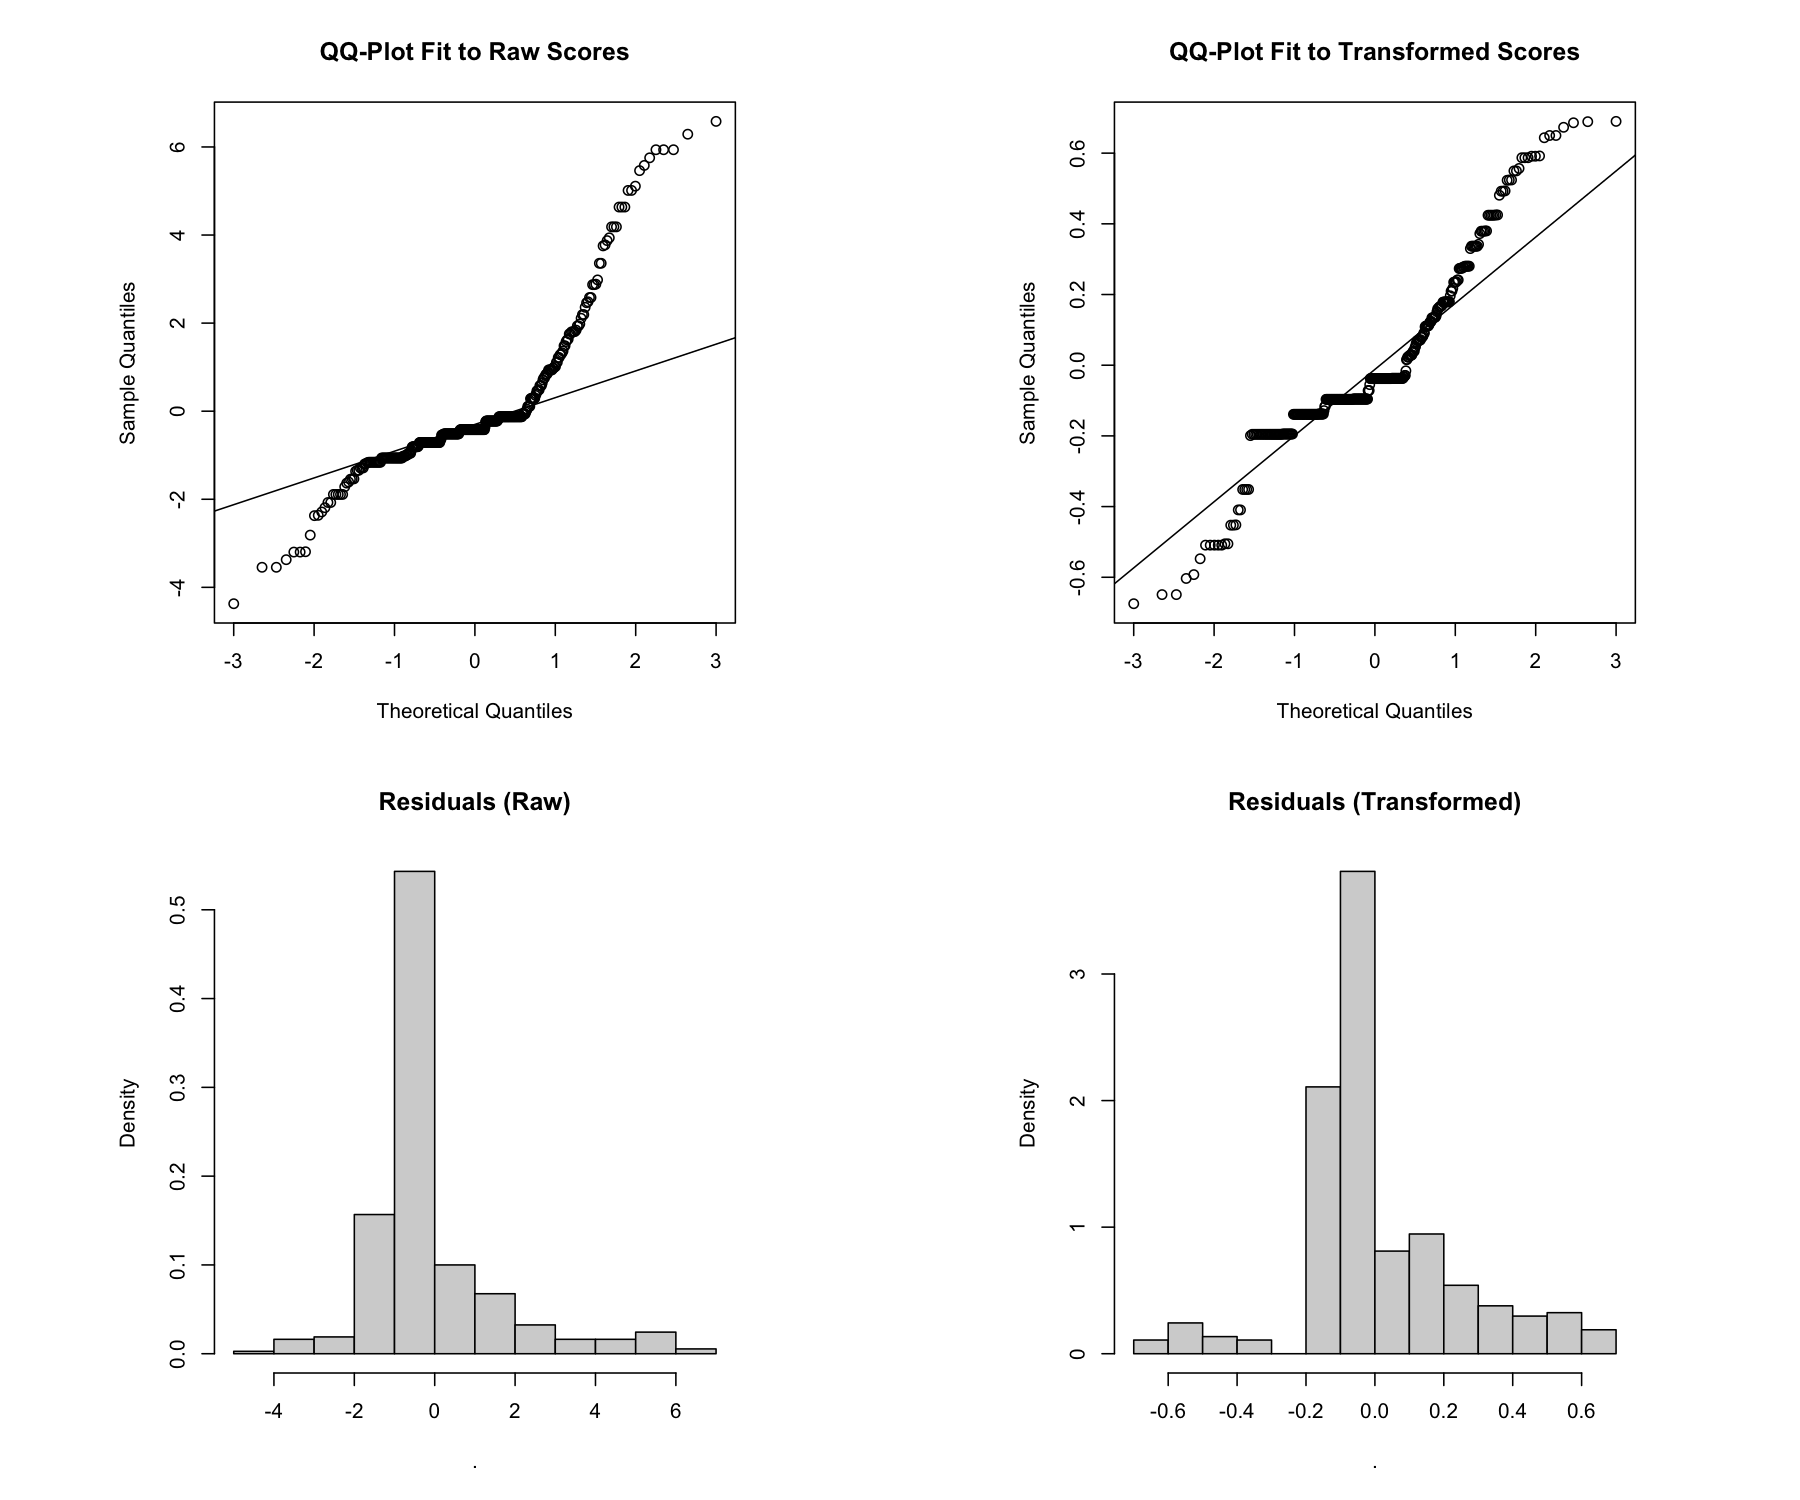

In [30]:
intention$lm_model %>% summary()
plot_qqs_hist(intention)


Call:
lm(formula = linkfun(post) ~ group * gov_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9652 -0.2043 -0.1051  0.2167  1.0229 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.10509    0.04152   2.531 0.011798 *  
groupTreatment                        0.09922    0.05251   1.890 0.059586 .  
gov_trust_cattrusting                 0.18754    0.05554   3.377 0.000812 ***
waveWave 2                           -0.05785    0.03944  -1.467 0.143270    
linkfun(pre)                          0.55390    0.04601  12.039  < 2e-16 ***
groupTreatment:gov_trust_cattrusting  0.01029    0.07212   0.143 0.886602    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3445 on 365 degrees of freedom
Multiple R-squared:  0.412,	Adjusted R-squared:  0.404 
F-statistic: 51.16 on 5 and 365 DF,  p-value: < 2.2e-16


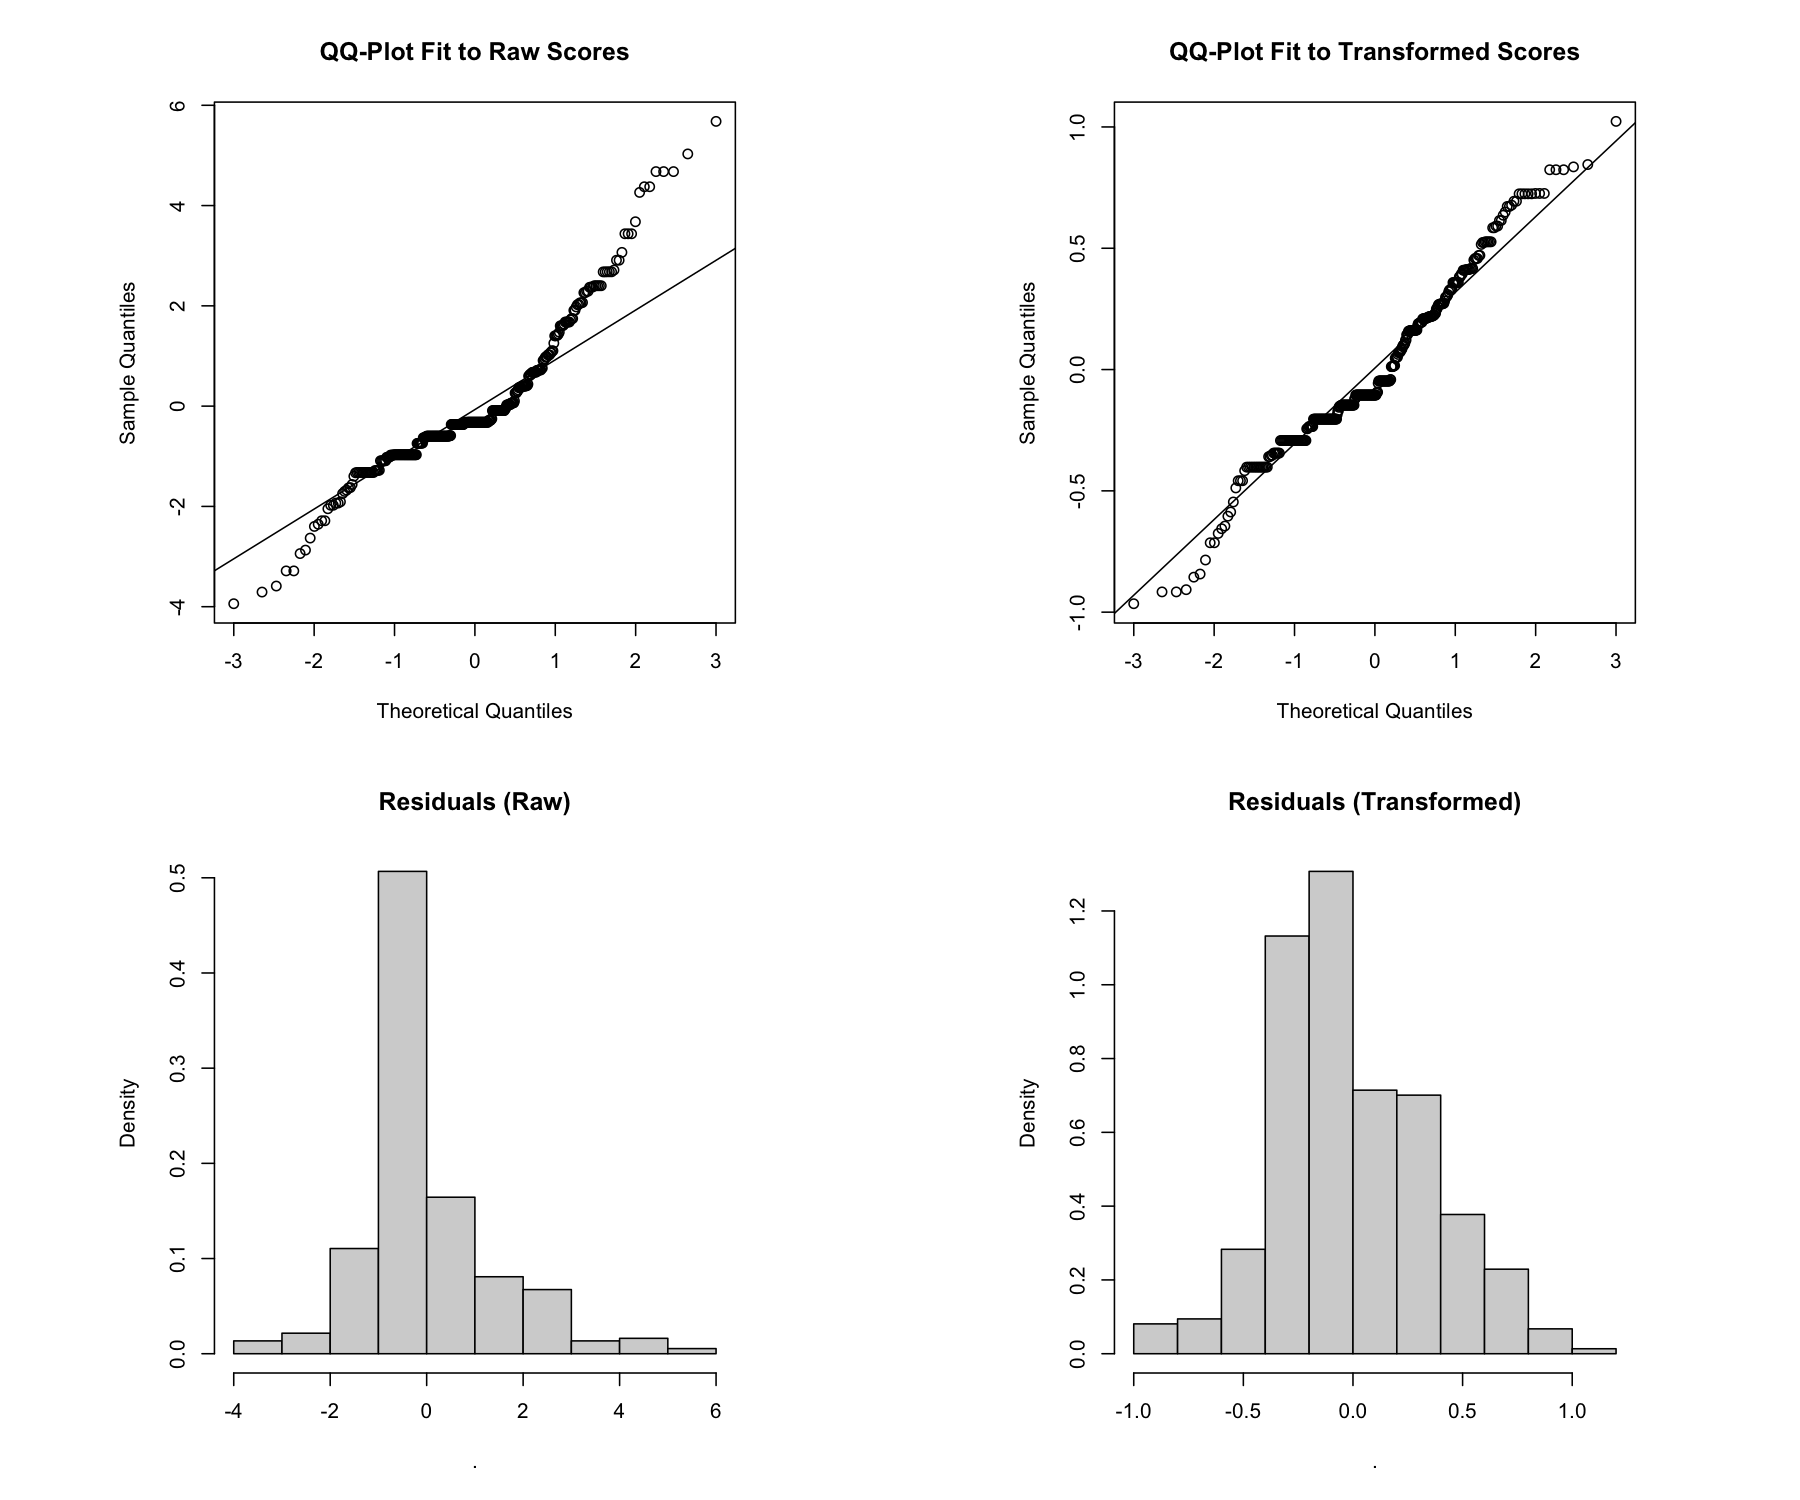

In [31]:
encourage$lm_model %>% summary()
plot_qqs_hist(encourage)


Call:
lm(formula = linkfun(post) ~ group * gov_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.37404 -0.24261 -0.04459  0.25884  1.29897 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.242613   0.048443   5.008 8.57e-07 ***
groupTreatment                       -0.001906   0.060128  -0.032   0.9747    
gov_trust_cattrusting                 0.165066   0.064613   2.555   0.0110 *  
waveWave 2                           -0.091882   0.044924  -2.045   0.0415 *  
linkfun(pre)                          0.728853   0.043750  16.660  < 2e-16 ***
groupTreatment:gov_trust_cattrusting  0.073593   0.082194   0.895   0.3712    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3922 on 365 degrees of freedom
Multiple R-squared:  0.5521,	Adjusted R-squared:  0.546 
F-statistic: 89.98 on 5 and 365 DF,  p-value: 

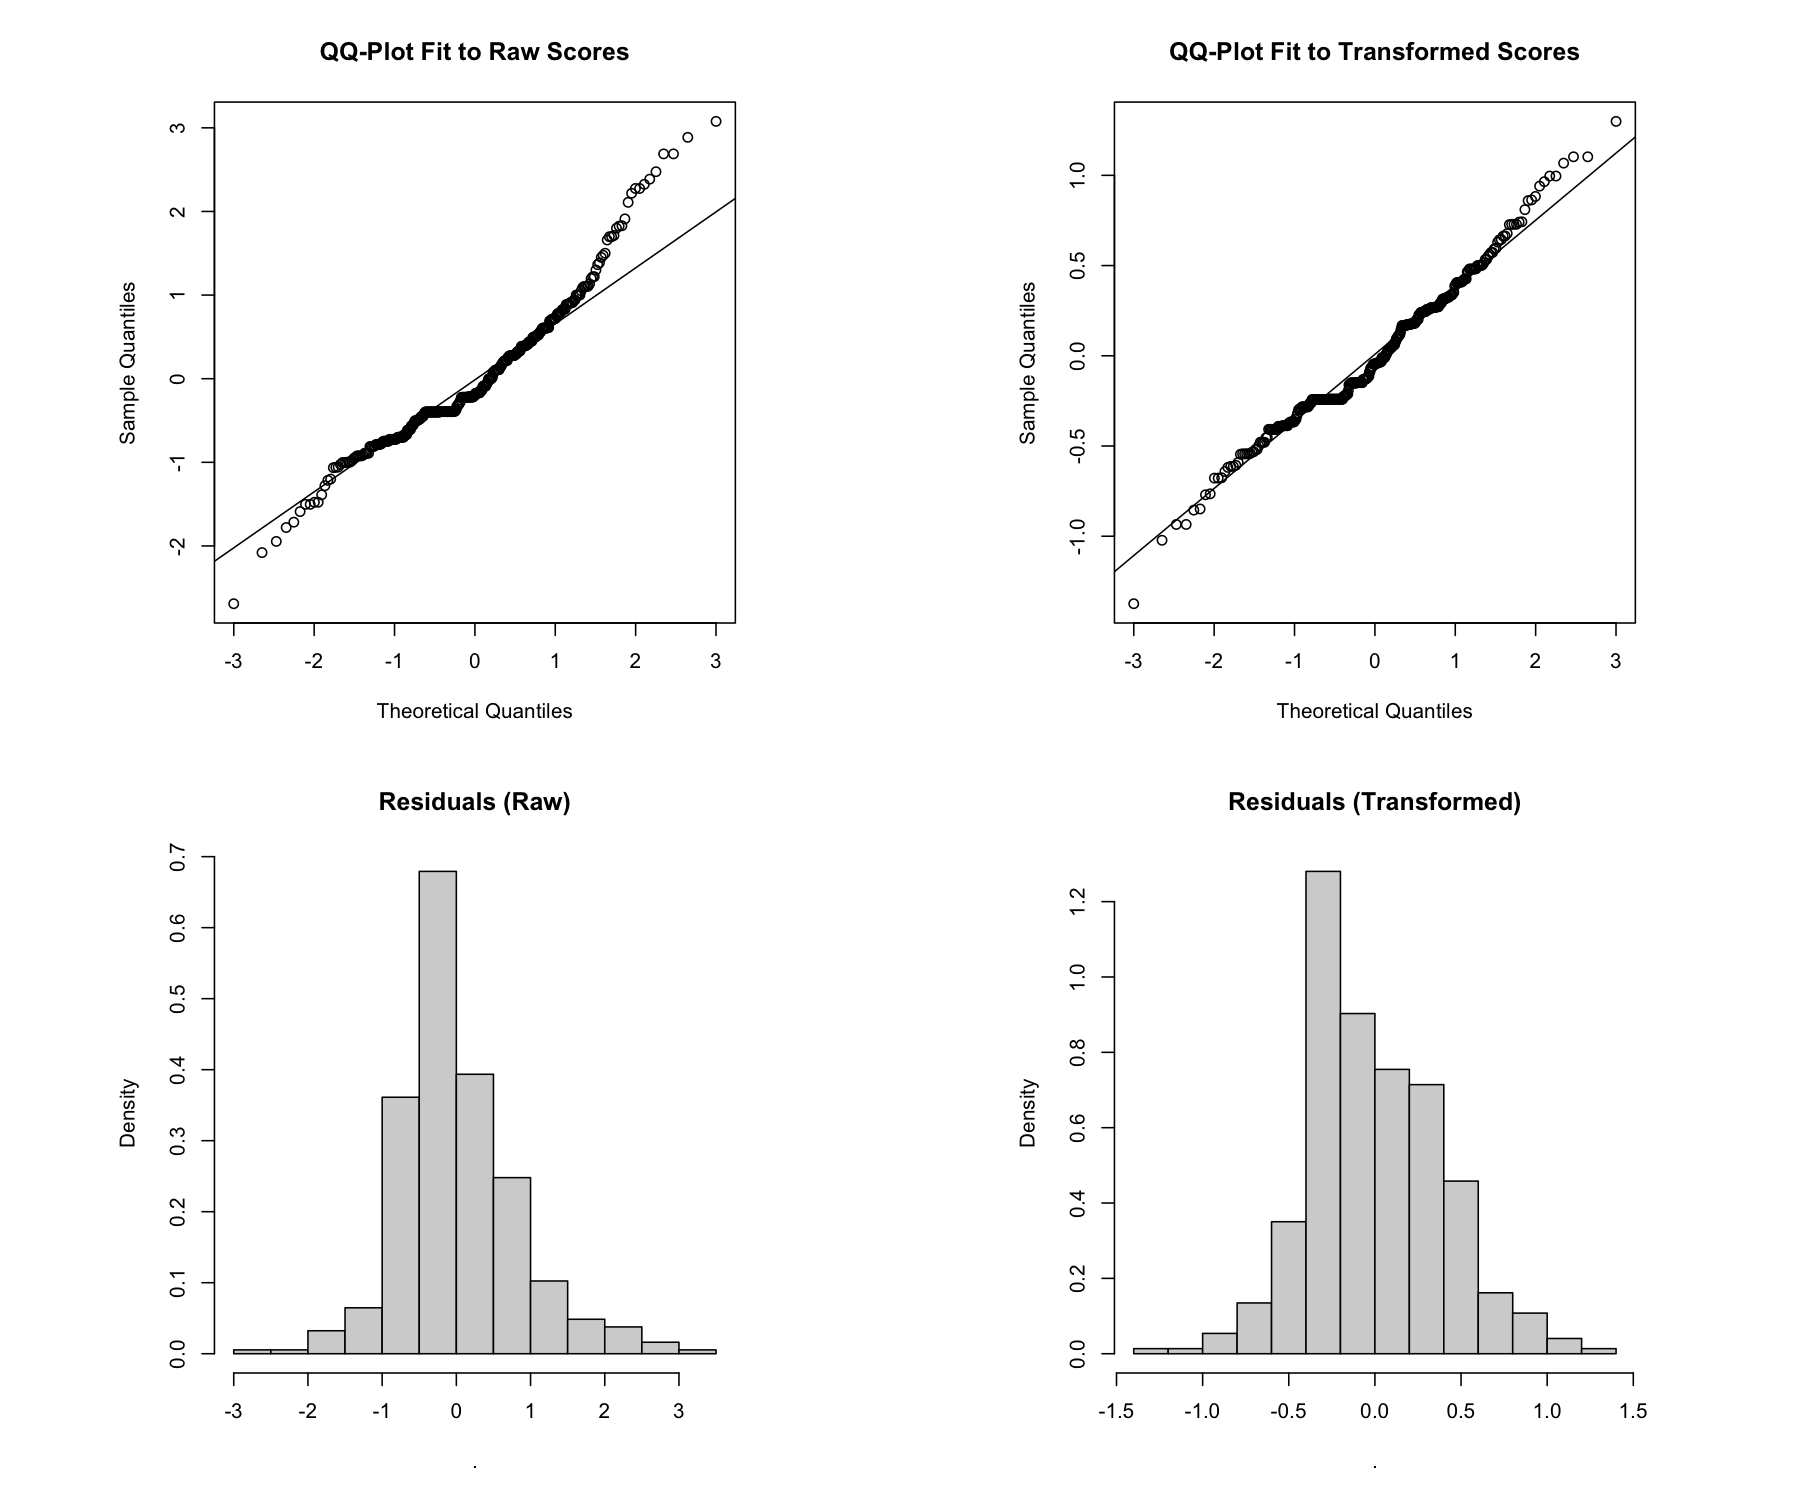

In [32]:
sp_confidence$lm_model %>% summary()
plot_qqs_hist(sp_confidence)


Call:
lm(formula = linkfun(post) ~ group * gov_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.40088 -0.27251 -0.06332  0.28593  1.50033 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.22869    0.05574   4.102 5.04e-05 ***
groupTreatment                        0.04382    0.06868   0.638  0.52389    
gov_trust_cattrusting                 0.23093    0.07375   3.131  0.00188 ** 
waveWave 2                           -0.07071    0.05140  -1.376  0.16972    
linkfun(pre)                          0.68425    0.04121  16.605  < 2e-16 ***
groupTreatment:gov_trust_cattrusting  0.03861    0.09416   0.410  0.68200    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4489 on 365 degrees of freedom
Multiple R-squared:  0.545,	Adjusted R-squared:  0.5388 
F-statistic: 87.44 on 5 and 365 DF,  p-value: < 2.2e-

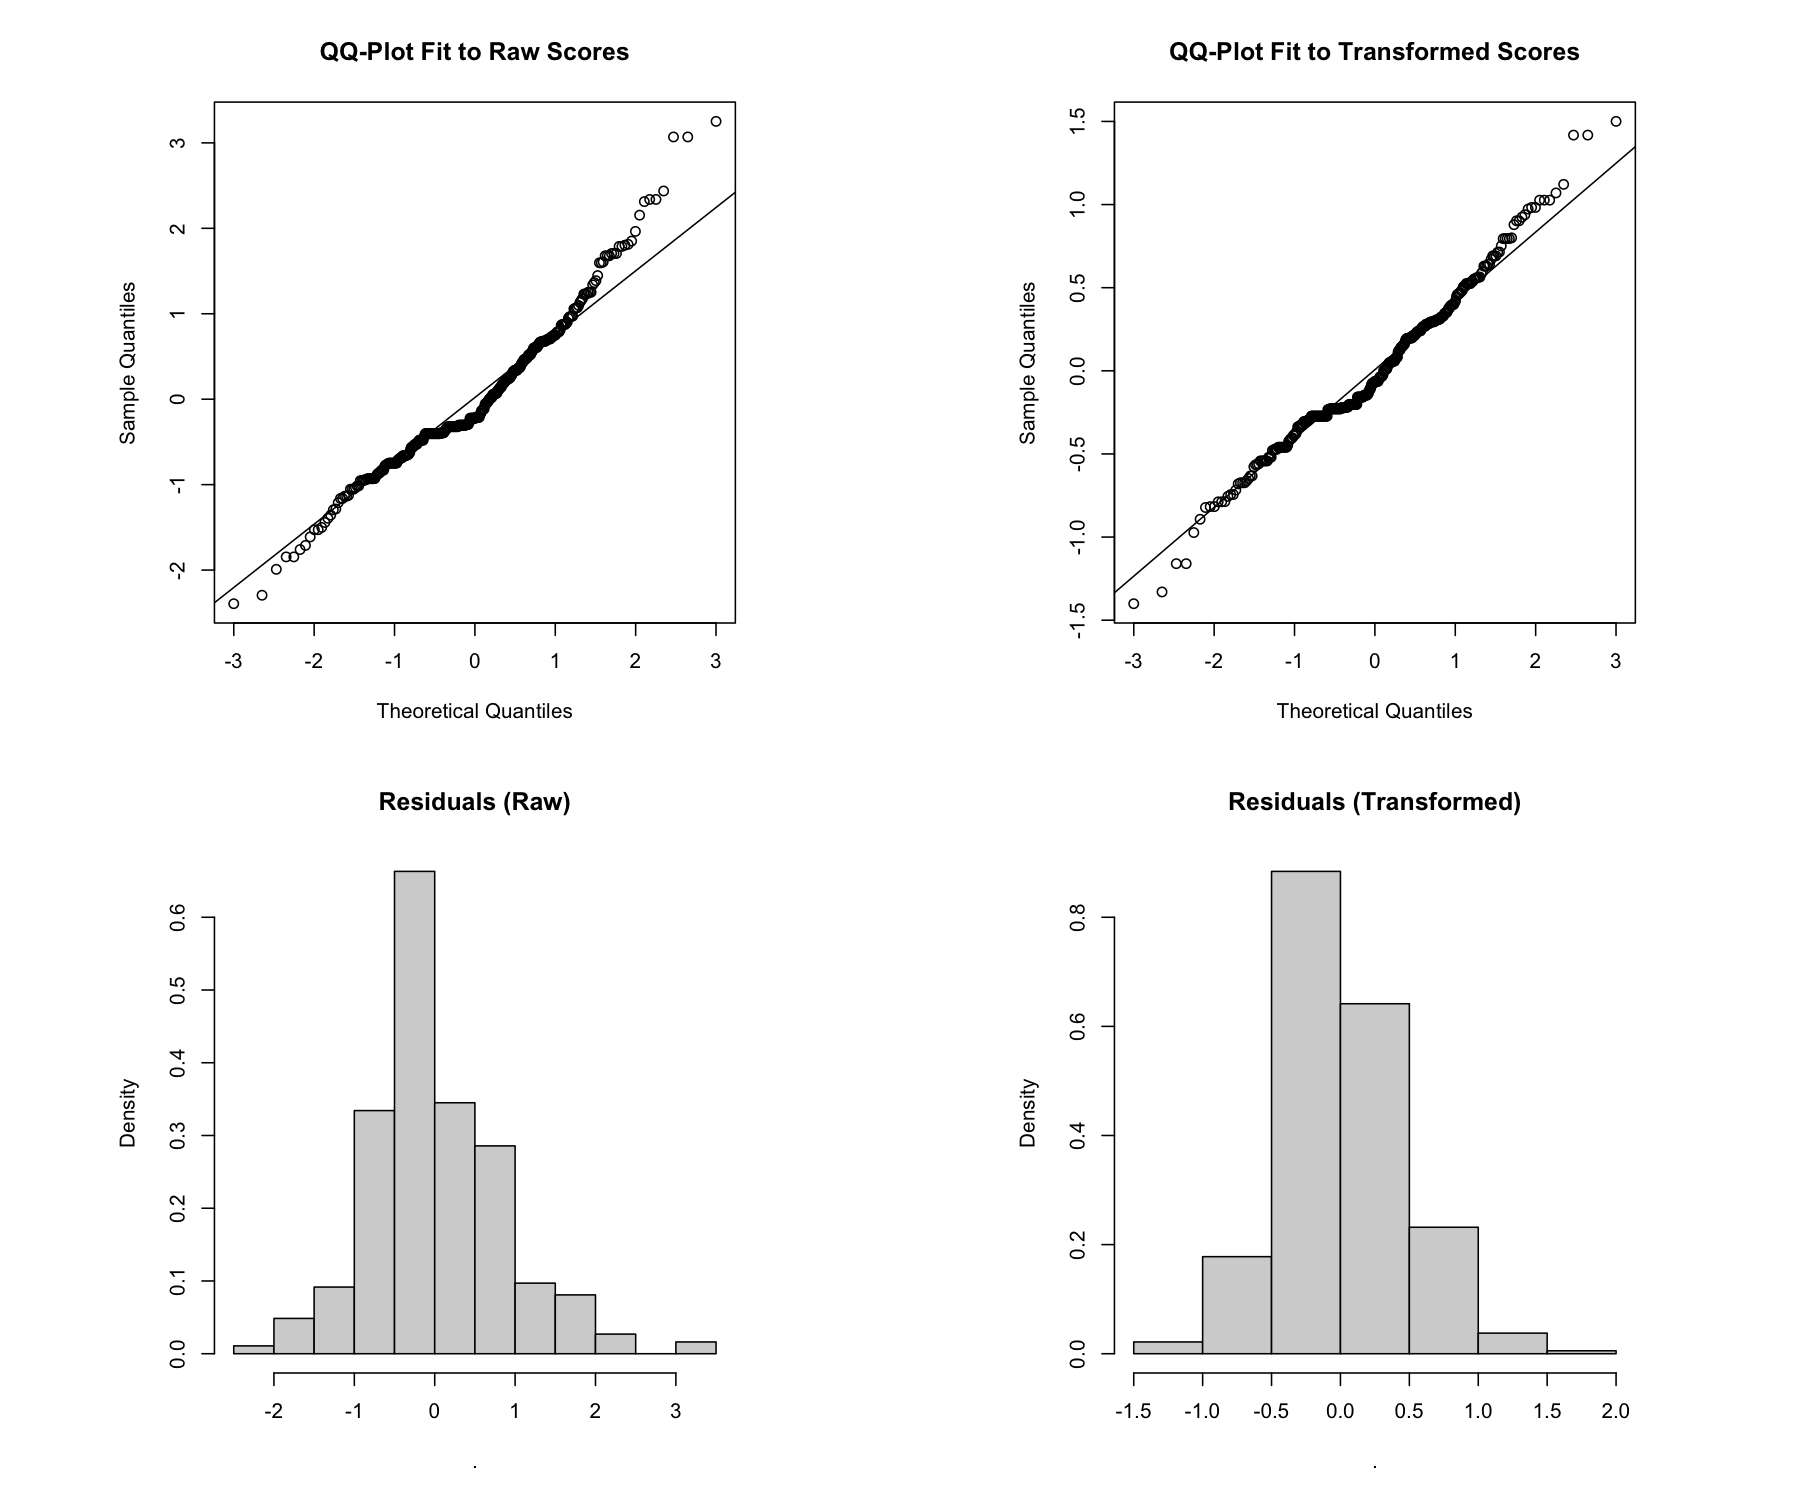

In [33]:
sp_complacency$lm_model %>% summary()
plot_qqs_hist(sp_complacency)

### PHI Trust Interactions

In [34]:
nrow(vcf_data)
vcf_data %>% group_by(phi_trust_cat) %>% count()
phi_distrust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(phi_trust_cat == "distrusting"), 
                label = "a) Distrusting", pad = 0.6)

phi_trust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(phi_trust_cat == "trusting"), 
                label = "b) Trusting", pad = 0.6)

[1] 371

phi_trust_cat n  
1 distrusting   119
2 trusting      252

#### Interaction Plots

Warning message:
“Removed 4 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”


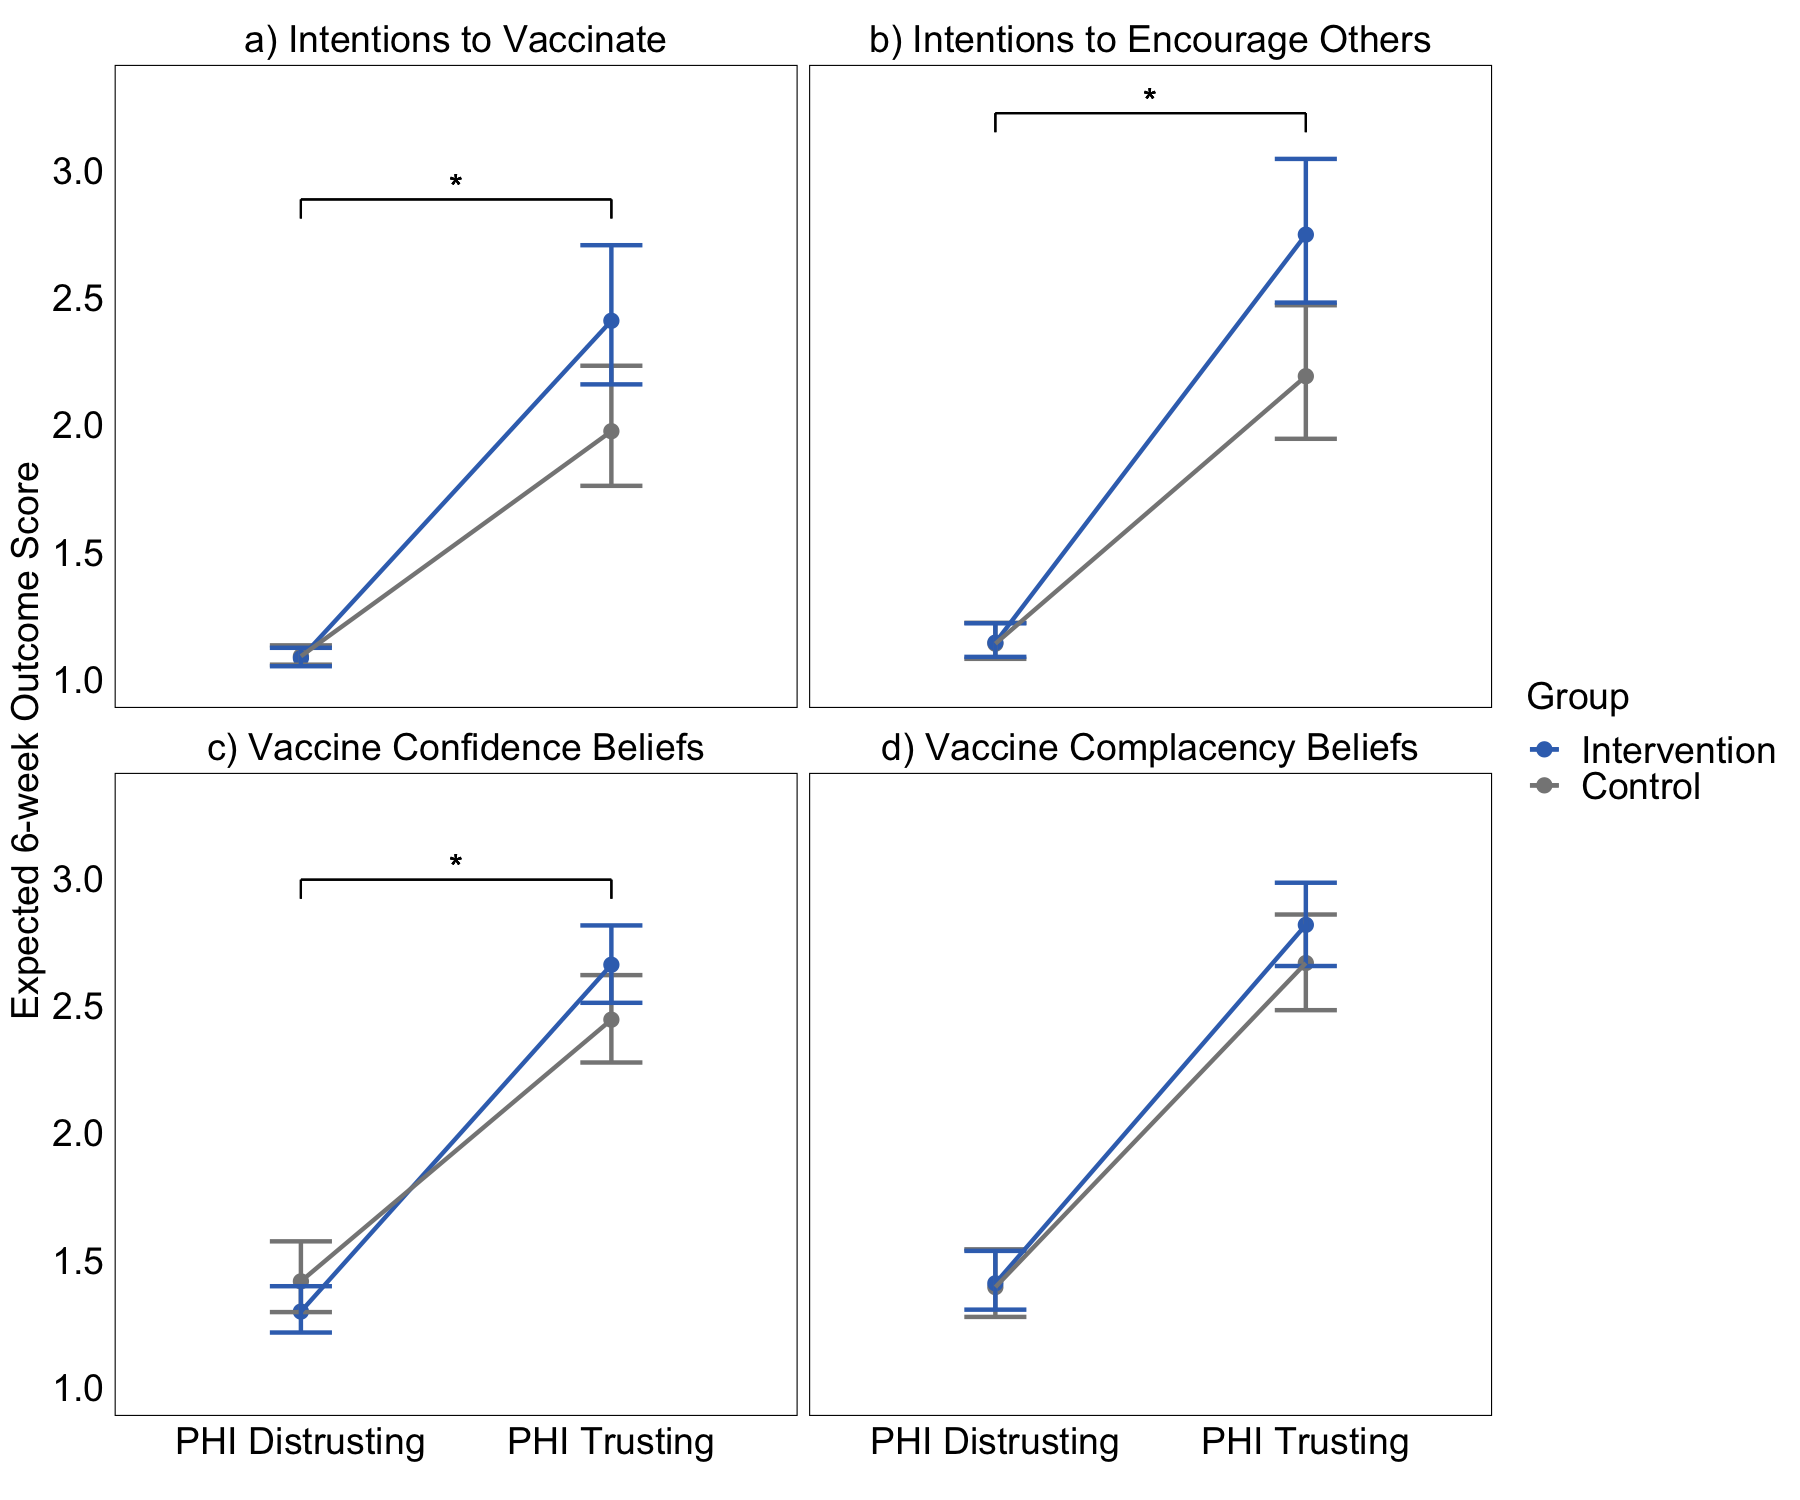

In [35]:
emm_intent1 <- phi_distrust$intention$emm_back %>% as_tibble() %>% 
                      mutate(level = "PHI Distrusting", measure = "a) Intentions to Vaccinate")
emm_intent2 <- phi_trust$intention$emm_back %>% as_tibble() %>% 
                              mutate(level = "PHI Trusting", measure = "a) Intentions to Vaccinate")

emm_encourage1 <- phi_distrust$encourage$emm_back %>% as_tibble() %>% 
                          mutate(level = "PHI Distrusting", measure = "b) Intentions to Encourage Others")
emm_encourage2 <- phi_trust$encourage$emm_back %>% as_tibble() %>% 
                                  mutate(level = "PHI Trusting", measure = "b) Intentions to Encourage Others")

emm_conf1 <- phi_distrust$sp_confidence$emm_back %>% as_tibble() %>% 
                          mutate(level = "PHI Distrusting", measure = "c) Vaccine Confidence Beliefs")
emm_conf2  <- phi_trust$sp_confidence$emm_back %>% as_tibble() %>% 
                                  mutate(level = "PHI Trusting", measure = "c) Vaccine Confidence Beliefs")

emm_comp1 <- phi_distrust$sp_complacency$emm_back %>% as_tibble() %>% 
                          mutate(level = "PHI Distrusting", measure = "d) Vaccine Complacency Beliefs")
emm_comp2  <- phi_trust$sp_complacency$emm_back %>% as_tibble() %>% 
                                  mutate(level = "PHI Trusting", measure = "d) Vaccine Complacency Beliefs")

plot_df <- bind_rows(emm_intent1, emm_intent2, 
                     emm_encourage1, emm_encourage2, 
                     emm_conf1, emm_conf2,
                     emm_comp1, emm_comp2) %>%
            arrange(desc(group))
plot_df$level <- factor(plot_df$level, levels = c("PHI Distrusting", "PHI Trusting"))

plot_df$group <- plot_df$group %>% as.character()
plot_df$group[plot_df$group == "Treatment"] <- "Intervention"
plot_df$group <- factor(plot_df$group,
                        levels = c("Intervention", "Control"))
plot_df$sig_bar_height <- NA
plot_df$sig_bar_height[plot_df$measure == "a) Intentions to Vaccinate"] <- max(plot_df$upper.CL[plot_df$measure == "a) Intentions to Vaccinate" ]) + 0.18
plot_df$sig_bar_height[plot_df$measure == "b) Intentions to Encourage Others"] <- max(plot_df$upper.CL[plot_df$measure == "b) Intentions to Encourage Others" ]) + 0.18
plot_df$sig_bar_height[plot_df$measure == "c) Vaccine Confidence Beliefs"] <- max(plot_df$upper.CL[plot_df$measure == "c) Vaccine Confidence Beliefs" ]) + 0.18

plot_df$astrick_y <- NA
plot_df$astrick_y[plot_df$measure == "a) Intentions to Vaccinate"] <- max(plot_df$upper.CL[plot_df$measure == "a) Intentions to Vaccinate" ]) + 0.23
plot_df$astrick_y[plot_df$measure == "b) Intentions to Encourage Others"] <- max(plot_df$upper.CL[plot_df$measure == "b) Intentions to Encourage Others" ]) + 0.23
plot_df$astrick_y[plot_df$measure == "c) Vaccine Confidence Beliefs"] <- max(plot_df$upper.CL[plot_df$measure == "c) Vaccine Confidence Beliefs" ]) + 0.23
plot_df$astrick_x <- 1.5

plot_df$sig_label <- NA
plot_df$sig_label[plot_df$measure == "a) Intentions to Vaccinate"] <- "*"
plot_df$sig_label[plot_df$measure == "b) Intentions to Encourage Others"] <- "*"
plot_df$sig_label[plot_df$measure == "c) Vaccine Confidence Beliefs"] <- "*"

options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)
ggplot() + 
    geom_point(data = plot_df, 
               mapping = aes(x = level, y = response, color = group), size = 3) +
    geom_errorbar(data = plot_df, 
                  mapping = aes(x = level, ymin=lower.CL, ymax=upper.CL, color = group), width=0.2,
                  linewidth = 1) +
    geom_line(data = plot_df, 
               mapping = aes(x = level, y = response, color = group, group = group), linewidth = 1) +
    geom_line(data = plot_df, 
               mapping = aes(x = level, y = sig_bar_height, group = group), color = "black", linewidth = 0.5) +
    geom_segment(data = plot_df, 
                 mapping = aes(x = level, xend = level,
                               y = sig_bar_height, yend = sig_bar_height - 0.075), color = "black", linewidth = 0.5)+
    geom_text(data = plot_df, mapping = aes(x = astrick_x, y = astrick_y, label = sig_label), size = 6) +
    theme_minimal() +
    labs(y = "Expected 6-week Outcome Score", x = "", color = "Group") + 
    theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_text(size = 18, color= "black"),
          axis.text.y = element_text(size = 18, color = "black"),
          axis.title.y = element_text(size = 18, colour = "black"),
          legend.text = element_text(size = 18, color= "black"),
          legend.title = element_text(size = 18, color= "black"),
          strip.text = element_text(size = 18, color= "black")
        ) +
    theme(panel.border=element_rect(linetype=1,fill=NA)) +
    scale_color_manual(values = c("#3A71BC", "#868686")) + 
    facet_wrap(~measure) + 
    guides(size = "none") +
    ylim(1, 3.3)

In [36]:
test_interaction_phi_trust <- function(data){
    
    data$group <- factor(data$group, levels = c("Control", "Treatment"))    
    
    # fit base model    
    base_model <- aov(post ~ group*phi_trust_cat + wave + 
                      #republican + conservative + 
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = "ml", lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group*phi_trust_cat + wave + 
                                  #republican + conservative + 
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))       
    
    lm_model <- with(bctrans,
              lm(linkfun(post) ~ group*phi_trust_cat + wave + 
                                  #republican + conservative + 
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))    
    
    mean <- model$coefficients[names(model$coefficients) %>% str_detect(":")]
    ci_tbl <- model %>% confint() %>% as_tibble()
    row_names <- model %>% confint() %>% rownames()
    idx <- which(row_names %>% str_detect(":"))
    low <- ci_tbl$`2.5 %`[idx]
    high <- ci_tbl$`97.5 %`[idx]
    idx <- which(rownames(car::Anova(model, type = "III")) %>% str_detect(":"))
    p <- car::Anova(model, type = "III")[[4]][idx]
    sig = ""
    if (p < 0.05){sig = "*"}
    if (p < 0.01){sig = "**"}
    if (p < 0.001){sig = "***"}
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "lm_model" = lm_model,
        "ci_summary" = ci_summary))}

In [37]:
intention <- test_interaction_phi_trust(data = vcf_data %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n))
encourage <- test_interaction_phi_trust(data = vcf_data %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n))
sp_confidence <- test_interaction_phi_trust(data = vcf_data %>% dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n))
sp_complacency <- test_interaction_phi_trust(data = vcf_data %>% dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n))
#car::Anova(intention$model, type = "III") %>% round(3)

paste0("Intentions: ", intention$ci_summary)
paste0("Intentions to encourage: ", encourage$ci_summary)
paste0("Vaccine confidence beliefs: ", sp_confidence$ci_summary)
paste0("Vaccine complacency beliefs: ", sp_complacency$ci_summary)

[1] "Intentions: mean = 0.11; 95% CI = 0.004, 0.215; P = 0.0412"

[1] "Intentions to encourage: mean = 0.164; 95% CI = 0.016, 0.312; P = 0.03"

[1] "Vaccine confidence beliefs: mean = 0.214; 95% CI = 0.047, 0.381; P = 0.0122"

[1] "Vaccine complacency beliefs: mean = 0.06; 95% CI = -0.132, 0.251; P = 0.541"


Call:
lm(formula = linkfun(post) ~ group * phi_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64839 -0.11682 -0.02825  0.10461  0.67563 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.049093   0.033559   1.463   0.1444    
groupTreatment                       -0.021814   0.044104  -0.495   0.6212    
phi_trust_cattrusting                 0.067728   0.040460   1.674   0.0950 .  
waveWave 2                           -0.002332   0.027311  -0.085   0.9320    
linkfun(pre)                          0.648795   0.045800  14.166   <2e-16 ***
groupTreatment:phi_trust_cattrusting  0.109651   0.053520   2.049   0.0412 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2389 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.457,	Adjusted R-squared:  0.4495 
F

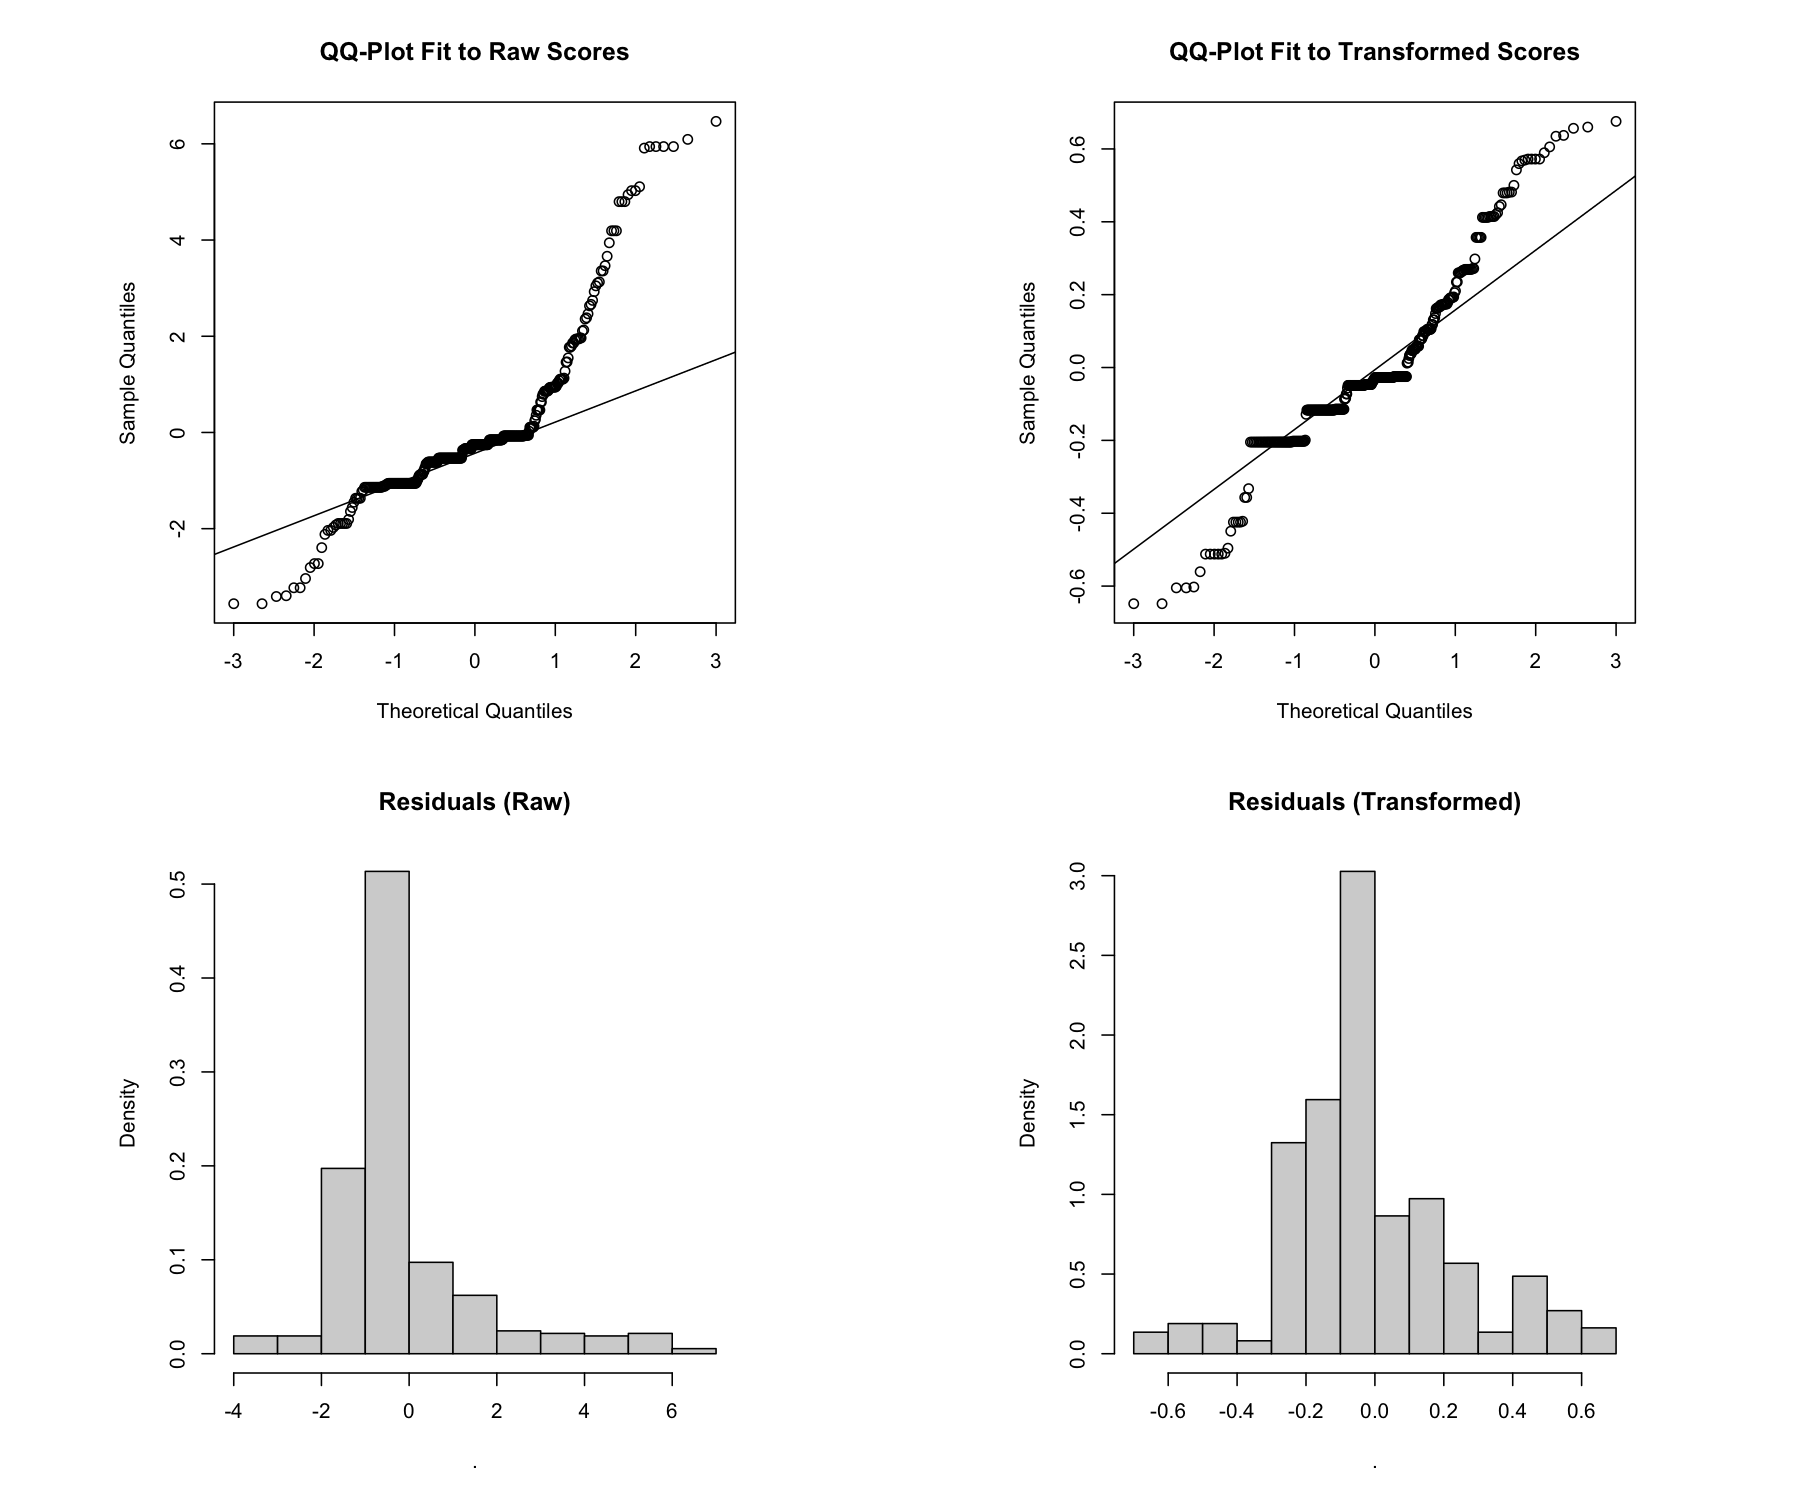

In [38]:
intention$lm_model %>% summary()
plot_qqs_hist(intention)


Call:
lm(formula = linkfun(post) ~ group * phi_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.94922 -0.24824 -0.05817  0.21397  0.99307 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.11913    0.04724   2.522   0.0121 *  
groupTreatment                       -0.01521    0.06210  -0.245   0.8066    
phi_trust_cattrusting                 0.12911    0.05712   2.260   0.0244 *  
waveWave 2                           -0.06096    0.03846  -1.585   0.1139    
linkfun(pre)                          0.54994    0.04515  12.182   <2e-16 ***
groupTreatment:phi_trust_cattrusting  0.16391    0.07525   2.178   0.0300 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3365 on 365 degrees of freedom
Multiple R-squared:  0.4259,	Adjusted R-squared:  0.418 
F-statistic: 54.15 on 5 and 365 DF,  p-value: < 2.2e-

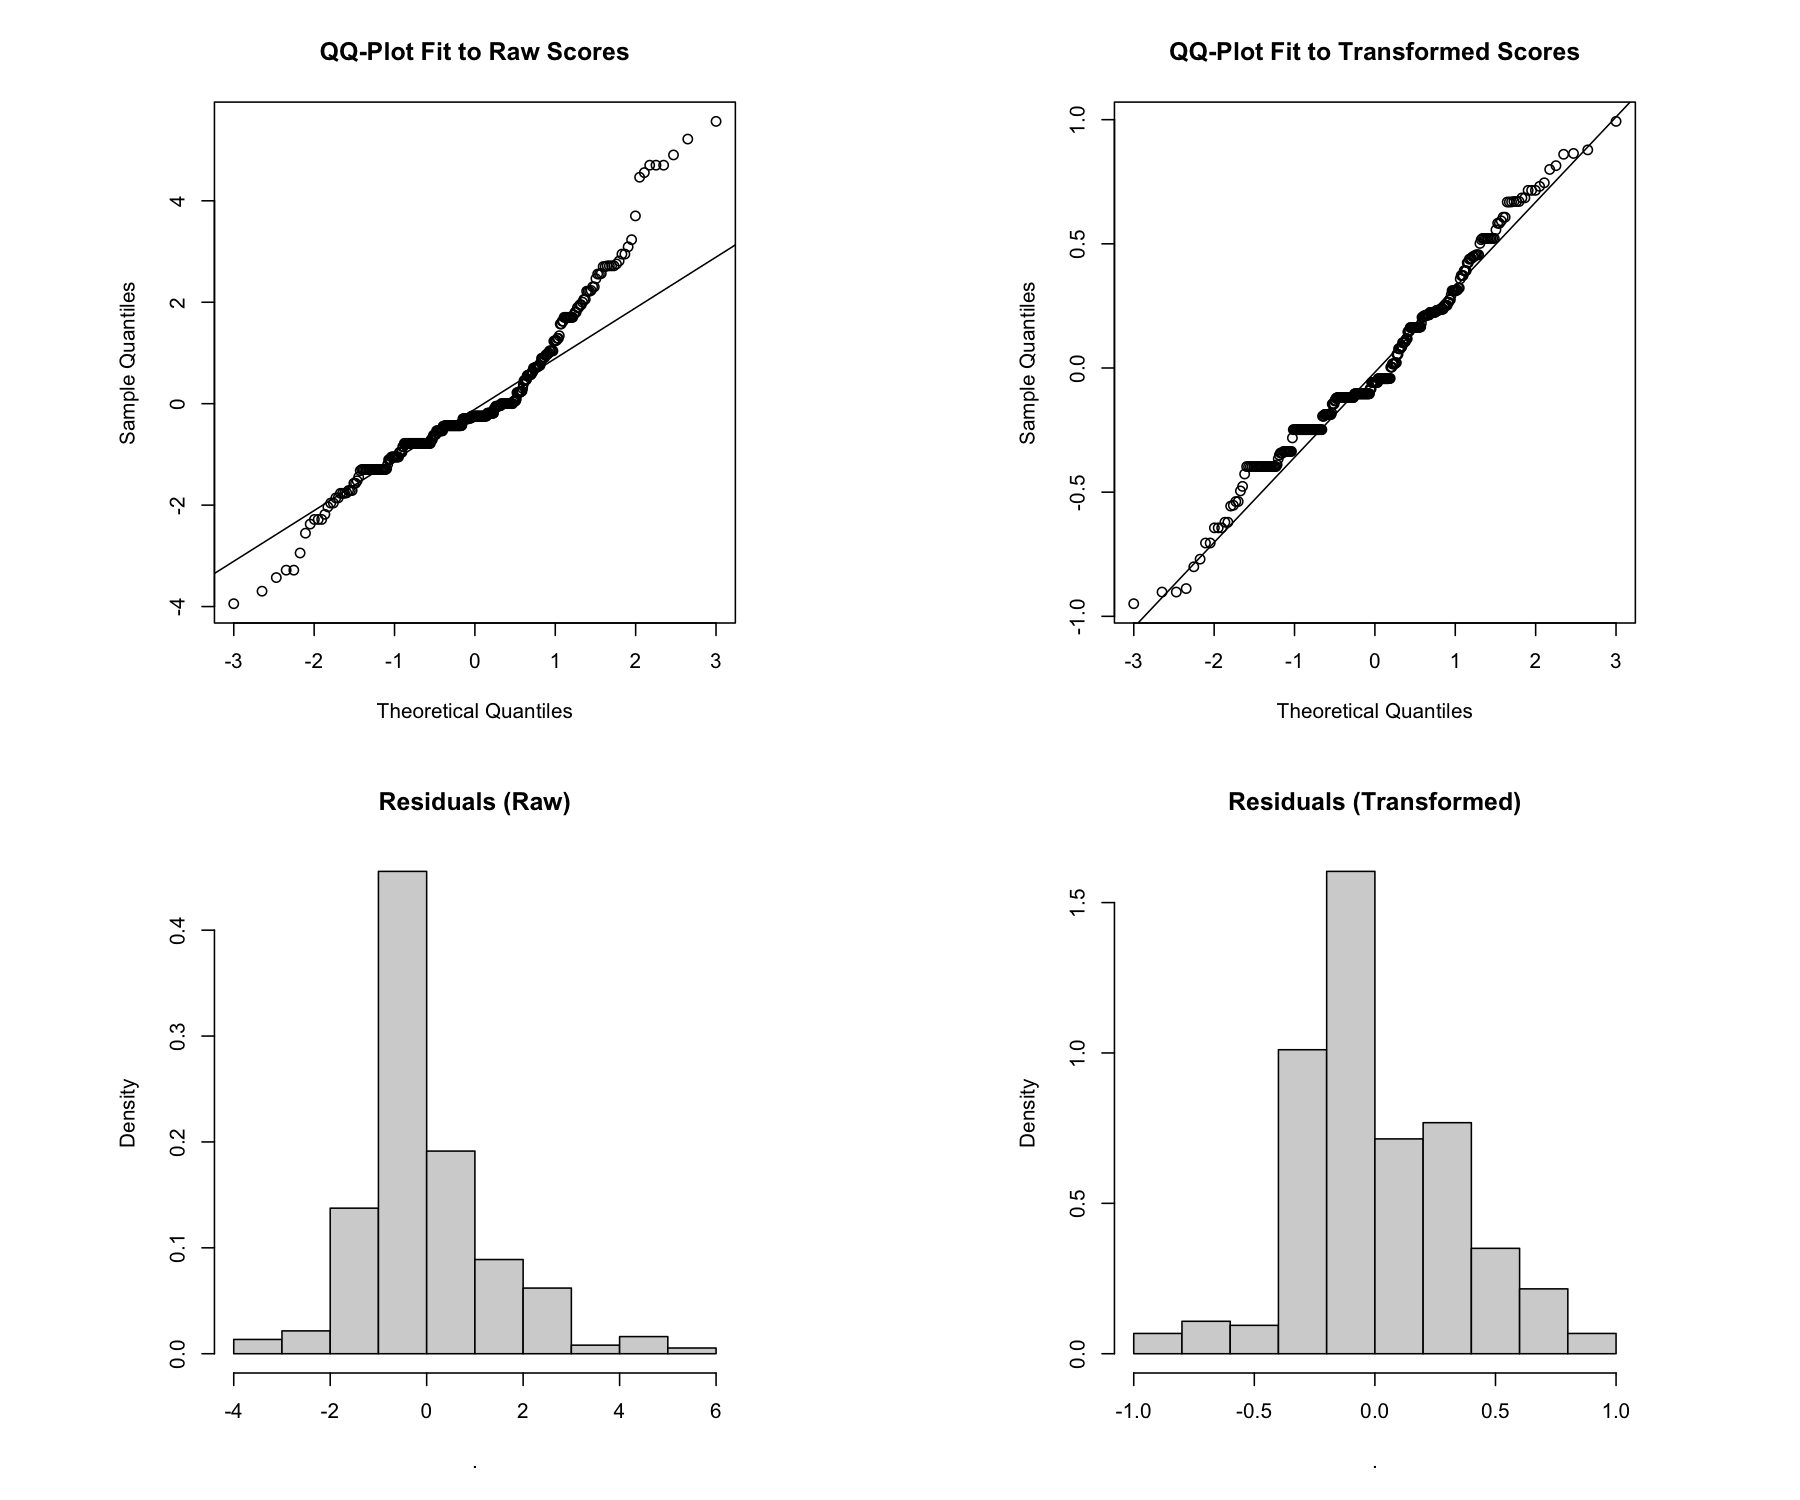

In [39]:
encourage$lm_model %>% summary()
plot_qqs_hist(encourage)


Call:
lm(formula = linkfun(post) ~ group * phi_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.03186 -0.28109 -0.04091  0.27349  1.26948 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.28691    0.05359   5.353 1.53e-07 ***
groupTreatment                       -0.11774    0.07024  -1.676   0.0945 .  
phi_trust_cattrusting                 0.05423    0.06739   0.805   0.4215    
waveWave 2                           -0.09524    0.04342  -2.194   0.0289 *  
linkfun(pre)                          0.72814    0.04558  15.975  < 2e-16 ***
groupTreatment:phi_trust_cattrusting  0.21392    0.08488   2.520   0.0122 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3796 on 365 degrees of freedom
Multiple R-squared:  0.5494,	Adjusted R-squared:  0.5432 
F-statistic: 88.99 on 5 and 365 DF,  p-value: < 2.2e

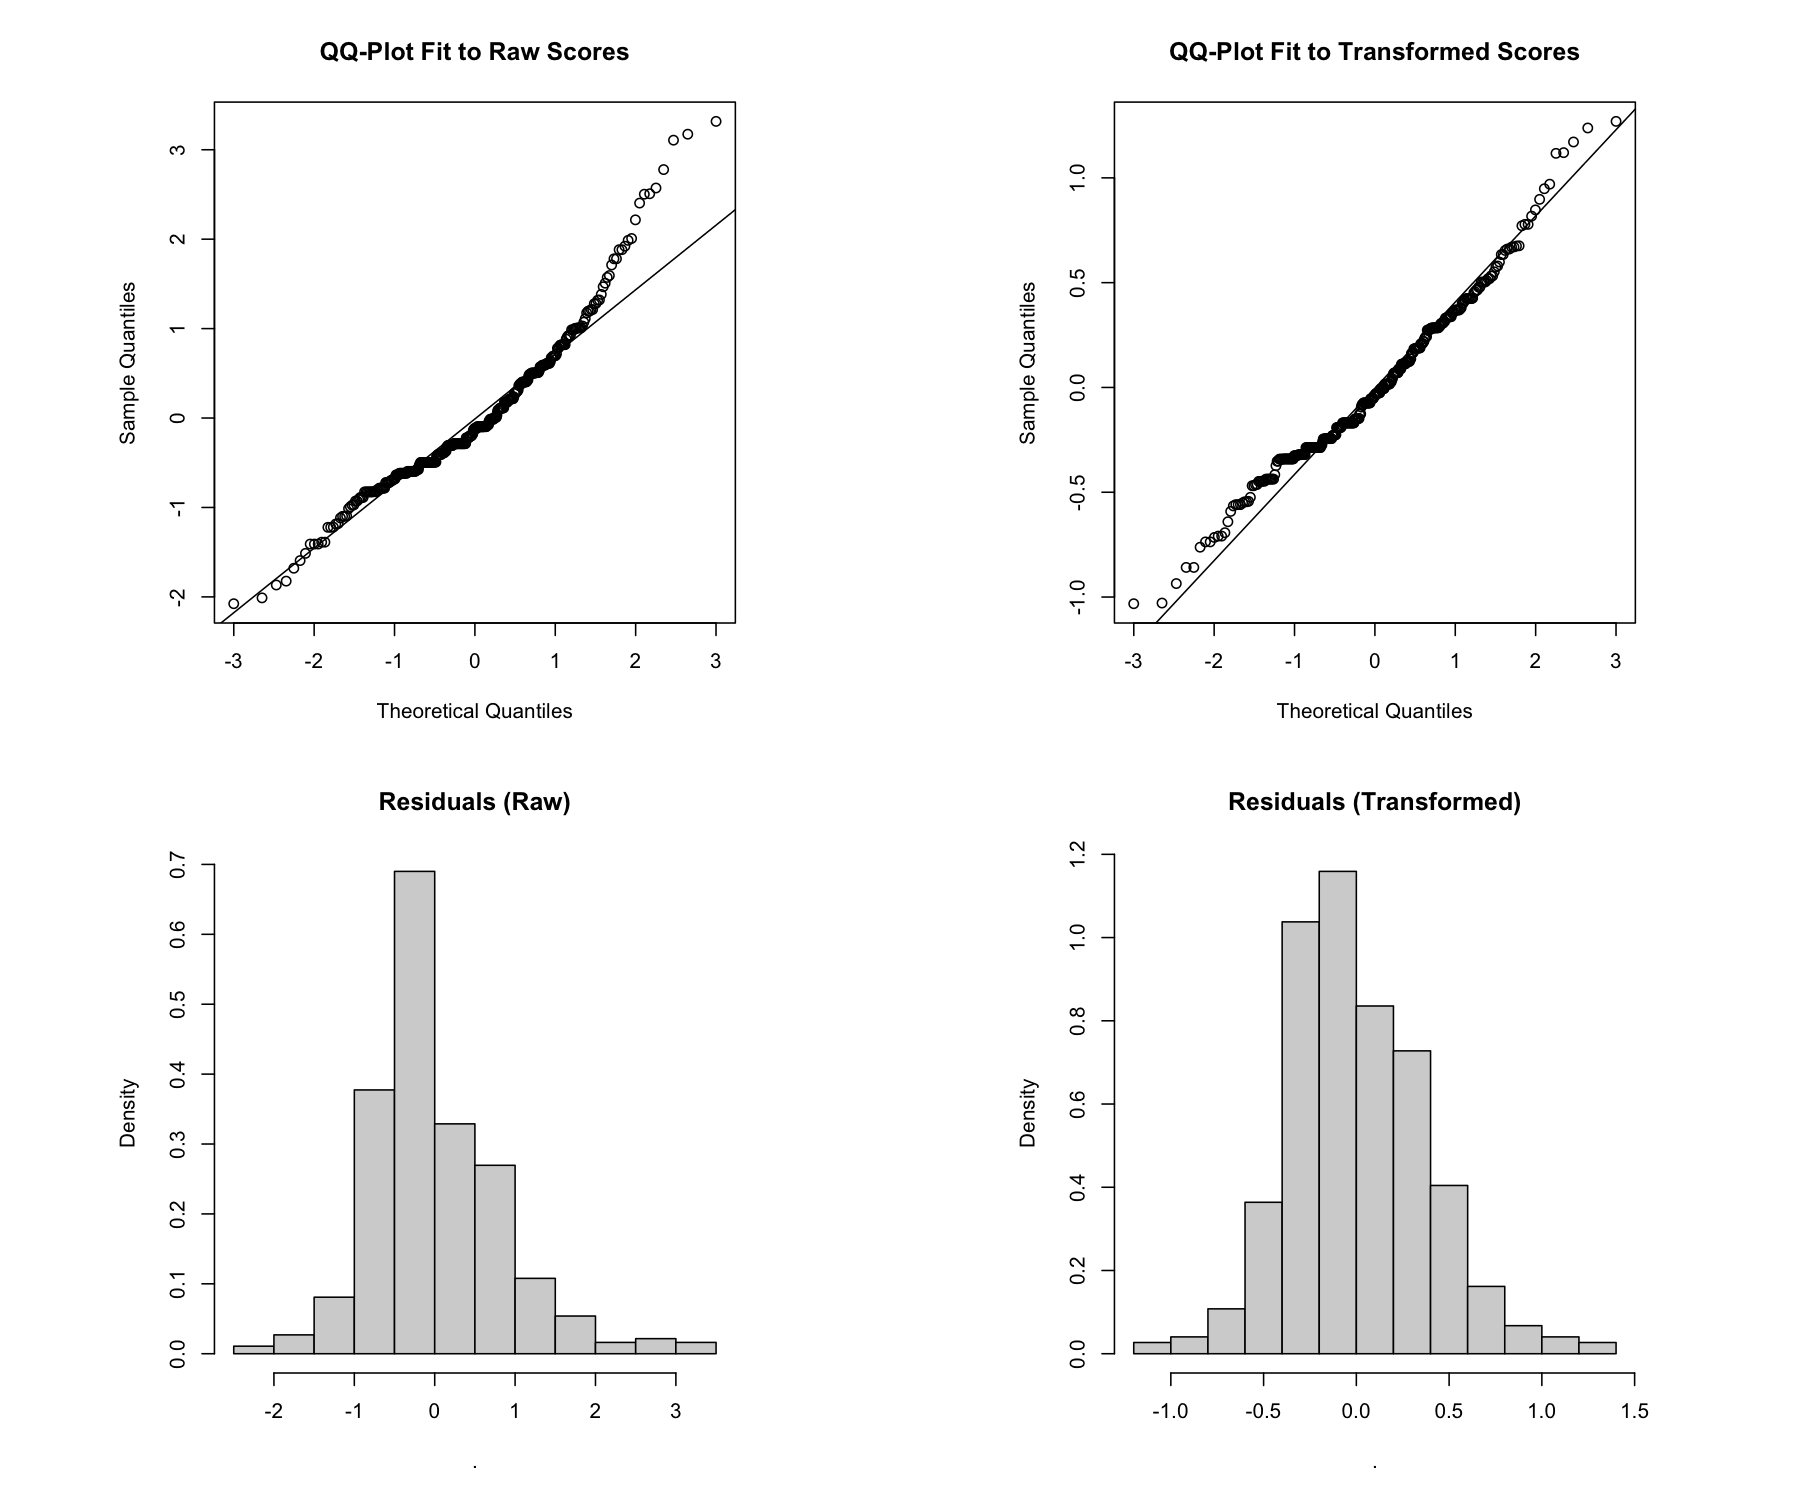

In [40]:
sp_confidence$lm_model %>% summary()
plot_qqs_hist(sp_confidence)


Call:
lm(formula = linkfun(post) ~ group * phi_trust_cat + wave + linkfun(pre), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32908 -0.25056 -0.02952  0.26643  1.46104 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.19210    0.06181   3.108  0.00203 ** 
groupTreatment                        0.01262    0.08039   0.157  0.87529    
phi_trust_cattrusting                 0.24268    0.07591   3.197  0.00151 ** 
waveWave 2                           -0.07532    0.04971  -1.515  0.13060    
linkfun(pre)                          0.66982    0.04163  16.089  < 2e-16 ***
groupTreatment:phi_trust_cattrusting  0.05951    0.09726   0.612  0.54101    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4348 on 365 degrees of freedom
Multiple R-squared:  0.5471,	Adjusted R-squared:  0.5409 
F-statistic: 88.18 on 5 and 365 DF,  p-value: < 2.2e

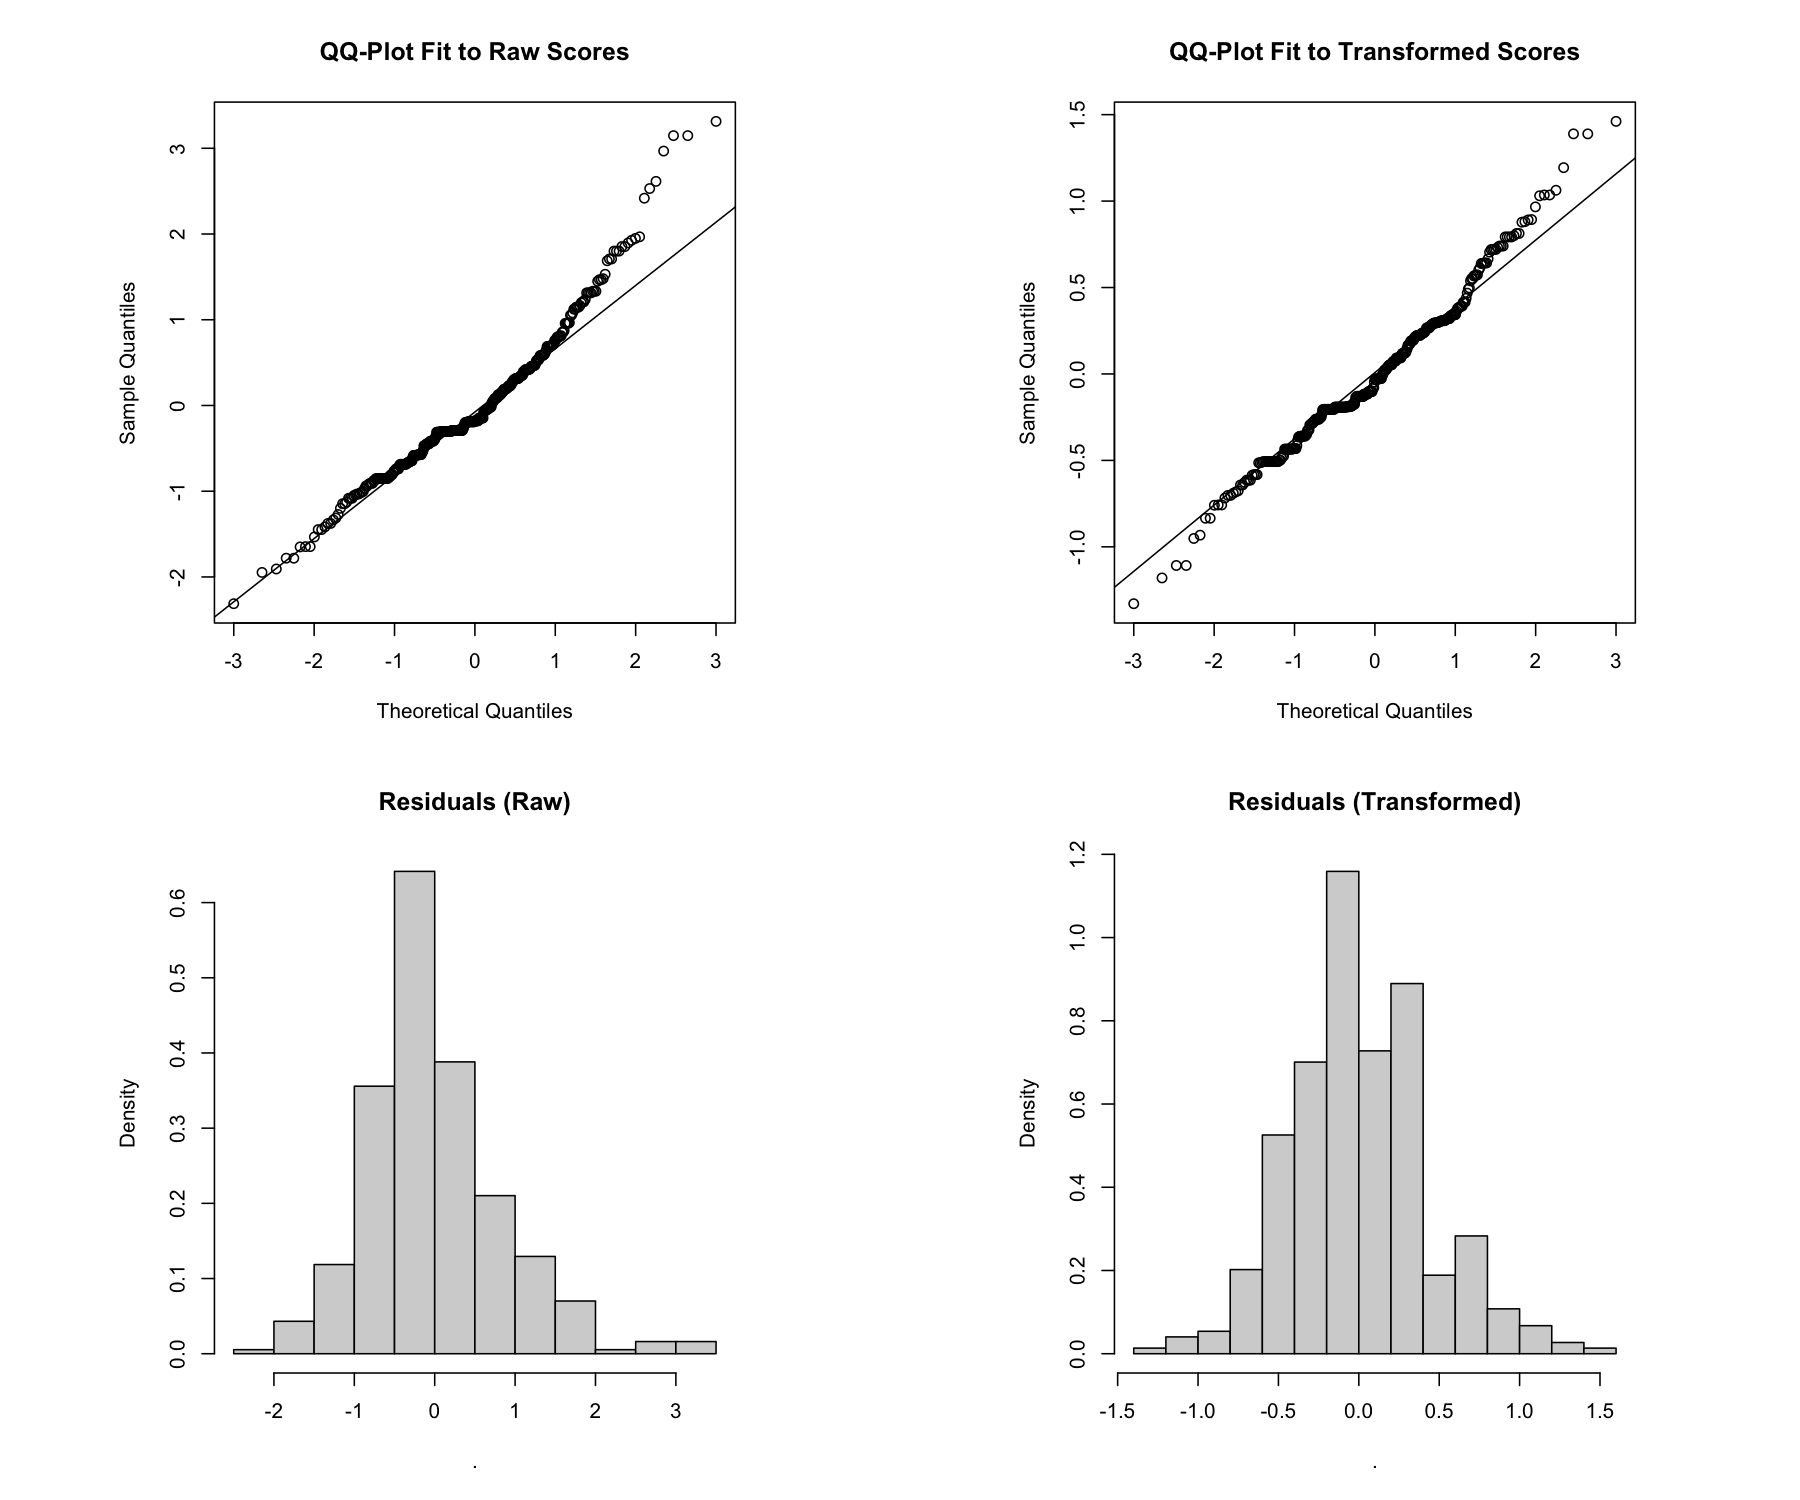

In [41]:
sp_complacency$lm_model %>% summary()
plot_qqs_hist(sp_complacency)

### Global Test

In [42]:
test_interaction_global <- function(data){
    
    data$group <- factor(data$group, levels = c("Control", "Treatment"))    
    
    # fit base model    
    base_model <- aov(post ~ 
                      #group*republican*gov_trust_cat*phi_trust_cat +
                      group*conservative*gov_trust_cat*phi_trust_cat +
                      wave + 
                      #republican + conservative + 
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = "ml", lambdarange = c(-10, 10), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ 
                  #group*republican*gov_trust_cat*phi_trust_cat +   
                  group*conservative*gov_trust_cat*phi_trust_cat +
                                  wave + 
                                  #republican + conservative + 
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))       
    
    lm_model <- with(bctrans,
              lm(linkfun(post) ~ 
                 #group*republican*gov_trust_cat*phi_trust_cat +
                 group*conservative*gov_trust_cat*phi_trust_cat +
                                 wave +
                                  #republican + conservative + 
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))    
            
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "lm_model" = lm_model))}

In [43]:
intention <- test_interaction_global(data = vcf_data %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n))
encourage <- test_interaction_global(data = vcf_data %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n))
sp_confidence <- test_interaction_global(data = vcf_data %>% dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n))
sp_complacency <- test_interaction_global(data = vcf_data %>% dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n))


Anova Table (Type III tests)

Response: linkfun(post)
                                                Sum Sq  Df  F value  Pr(>F)    
(Intercept)                                     0.0294   1   0.5243 0.46950    
group                                           0.0001   1   0.0021 0.96383    
conservative                                    0.0005   1   0.0086 0.92633    
gov_trust_cat                                   0.1989   1   3.5412 0.06069 .  
phi_trust_cat                                   0.0000   1   0.0004 0.98358    
wave                                            0.0003   1   0.0058 0.93936    
linkfun(pre)                                    8.9634   1 159.6137 < 2e-16 ***
group:conservative                              0.0012   1   0.0206 0.88603    
group:gov_trust_cat                             0.0160   1   0.2845 0.59409    
conservative:gov_trust_cat                      0.2113   1   3.7630 0.05320 .  
group:phi_trust_cat                             0.1794   1   3.194

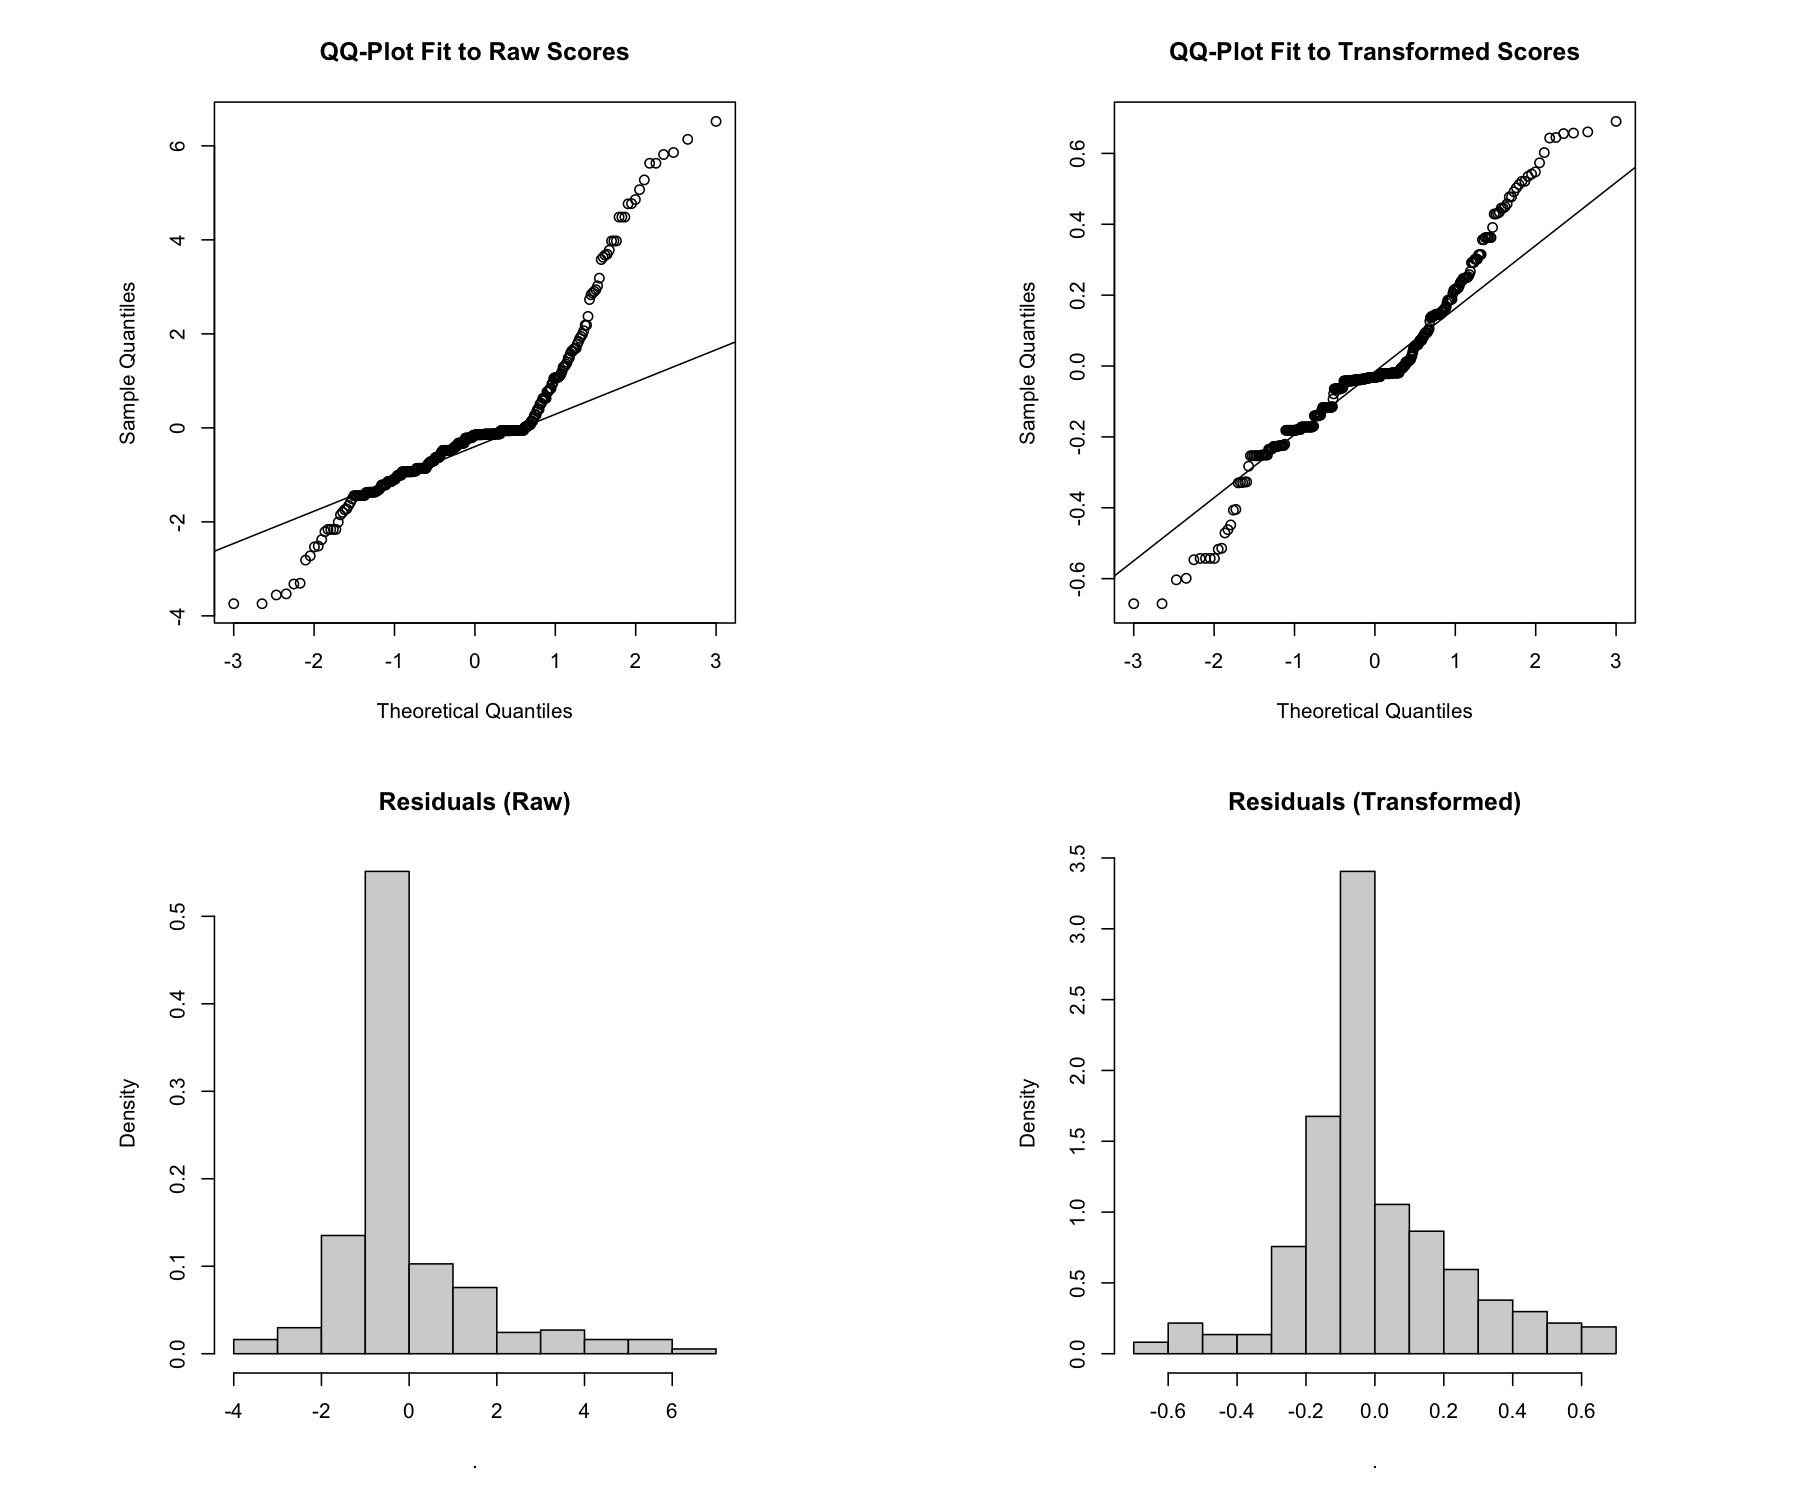

In [44]:
print(car::Anova(intention$model, type = "III"))
plot_qqs_hist(intention)

Anova Table (Type III tests)

Response: linkfun(post)
                                               Sum Sq  Df  F value  Pr(>F)    
(Intercept)                                     0.459   1   4.1154 0.04324 *  
group                                           0.000   1   0.0036 0.95236    
conservative                                    0.132   1   1.1799 0.27812    
gov_trust_cat                                   0.063   1   0.5663 0.45224    
phi_trust_cat                                   0.007   1   0.0651 0.79870    
wave                                            0.158   1   1.4200 0.23420    
linkfun(pre)                                   12.308   1 110.3781 < 2e-16 ***
group:conservative                              0.007   1   0.0605 0.80589    
group:gov_trust_cat                             0.033   1   0.2966 0.58636    
conservative:gov_trust_cat                      0.000   1   0.0027 0.95852    
group:phi_trust_cat                             0.205   1   1.8344 0.17648   

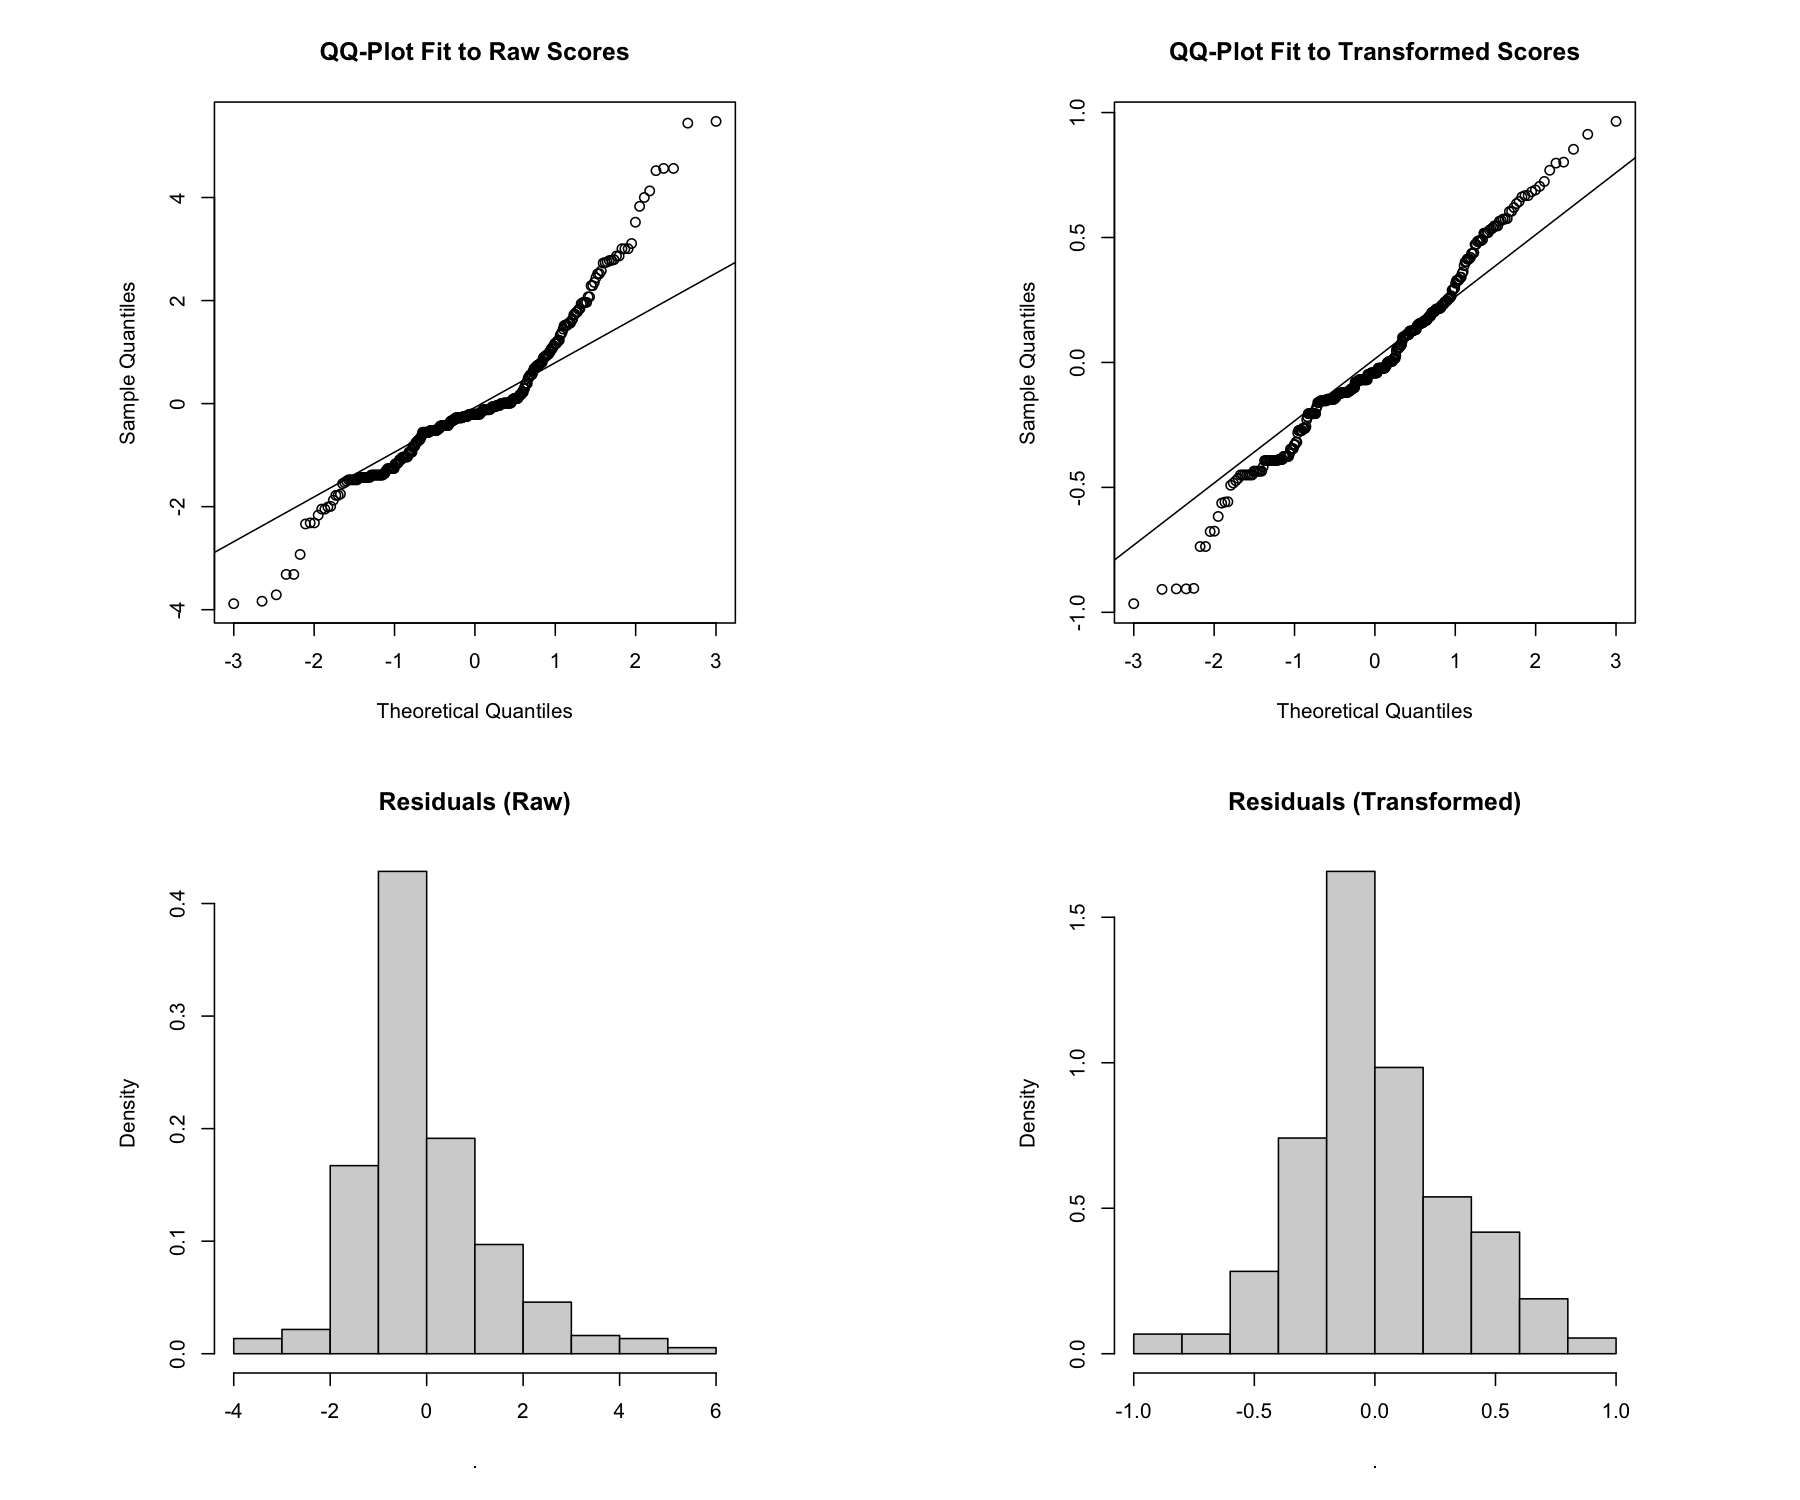

In [45]:
print(car::Anova(encourage$model, type = "III"))
plot_qqs_hist(encourage)

Anova Table (Type III tests)

Response: linkfun(post)
                                               Sum Sq  Df  F value    Pr(>F)
(Intercept)                                     0.748   1   5.4075 0.0206163
group                                           0.006   1   0.0460 0.8303726
conservative                                    0.017   1   0.1231 0.7259468
gov_trust_cat                                   1.577   1  11.3971 0.0008175
phi_trust_cat                                   0.145   1   1.0495 0.3063206
wave                                            0.453   1   3.2713 0.0713518
linkfun(pre)                                   31.236   1 225.8022 < 2.2e-16
group:conservative                              0.000   1   0.0001 0.9907176
group:gov_trust_cat                             0.426   1   3.0791 0.0801718
conservative:gov_trust_cat                      0.000   1   0.0017 0.9671848
group:phi_trust_cat                             0.028   1   0.2014 0.6538827
conservative:phi_trust

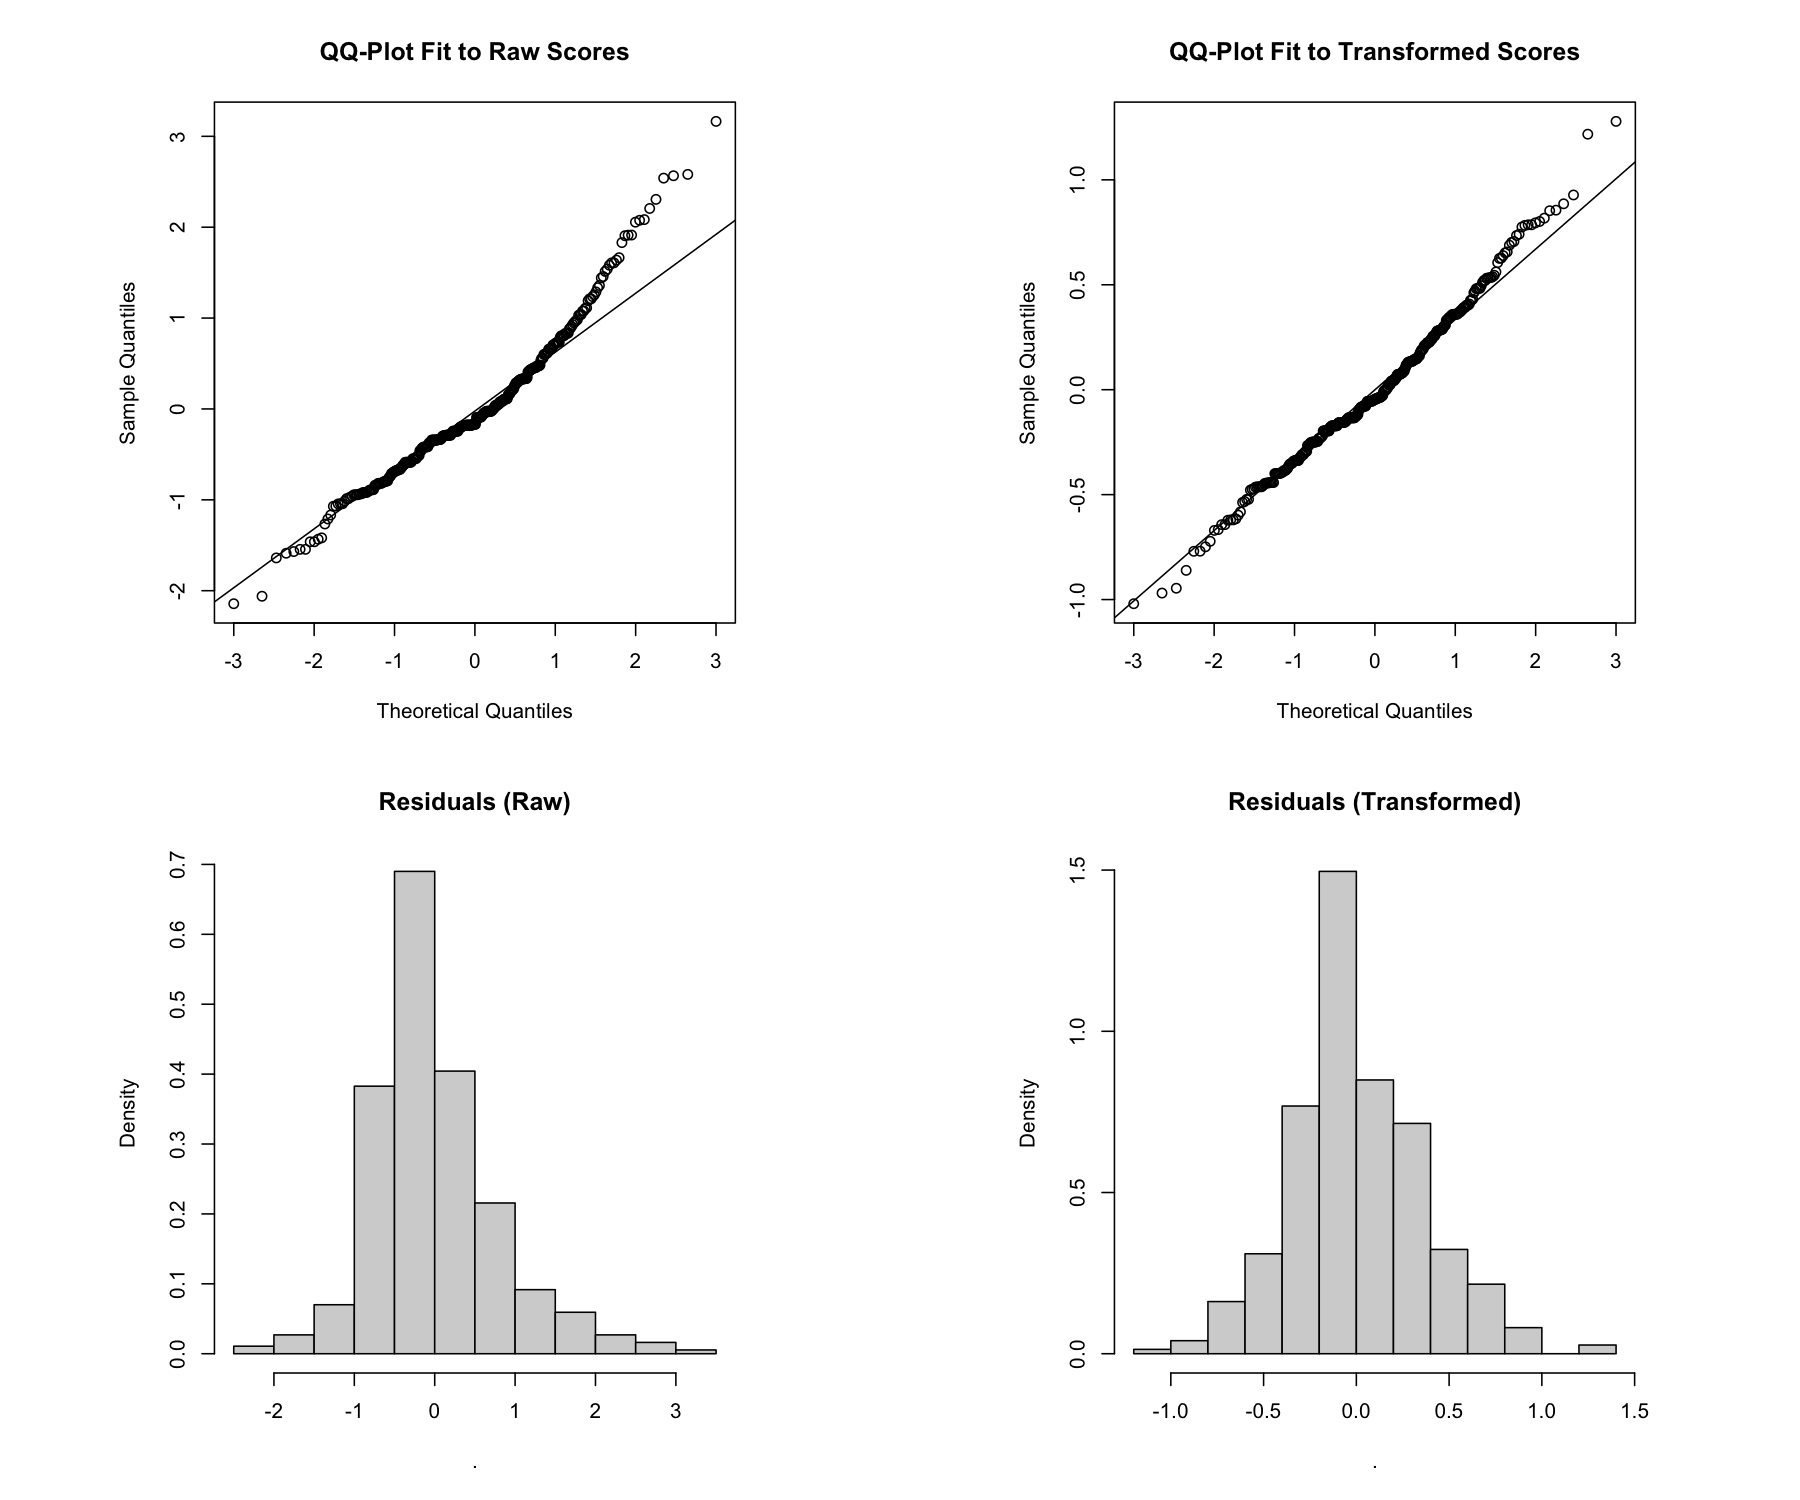

In [46]:
print(car::Anova(sp_confidence$model, type = "III"))
plot_qqs_hist(sp_confidence)

Anova Table (Type III tests)

Response: linkfun(post)
                                               Sum Sq  Df  F value  Pr(>F)    
(Intercept)                                     1.088   1   5.7362 0.01714 *  
group                                           0.005   1   0.0284 0.86625    
conservative                                    0.224   1   1.1835 0.27739    
gov_trust_cat                                   0.295   1   1.5560 0.21308    
phi_trust_cat                                   0.244   1   1.2844 0.25785    
wave                                            0.303   1   1.5989 0.20690    
linkfun(pre)                                   37.541   1 197.9659 < 2e-16 ***
group:conservative                              0.023   1   0.1223 0.72673    
group:gov_trust_cat                             0.799   1   4.2108 0.04090 *  
conservative:gov_trust_cat                      0.010   1   0.0516 0.82041    
group:phi_trust_cat                             0.066   1   0.3501 0.55443   

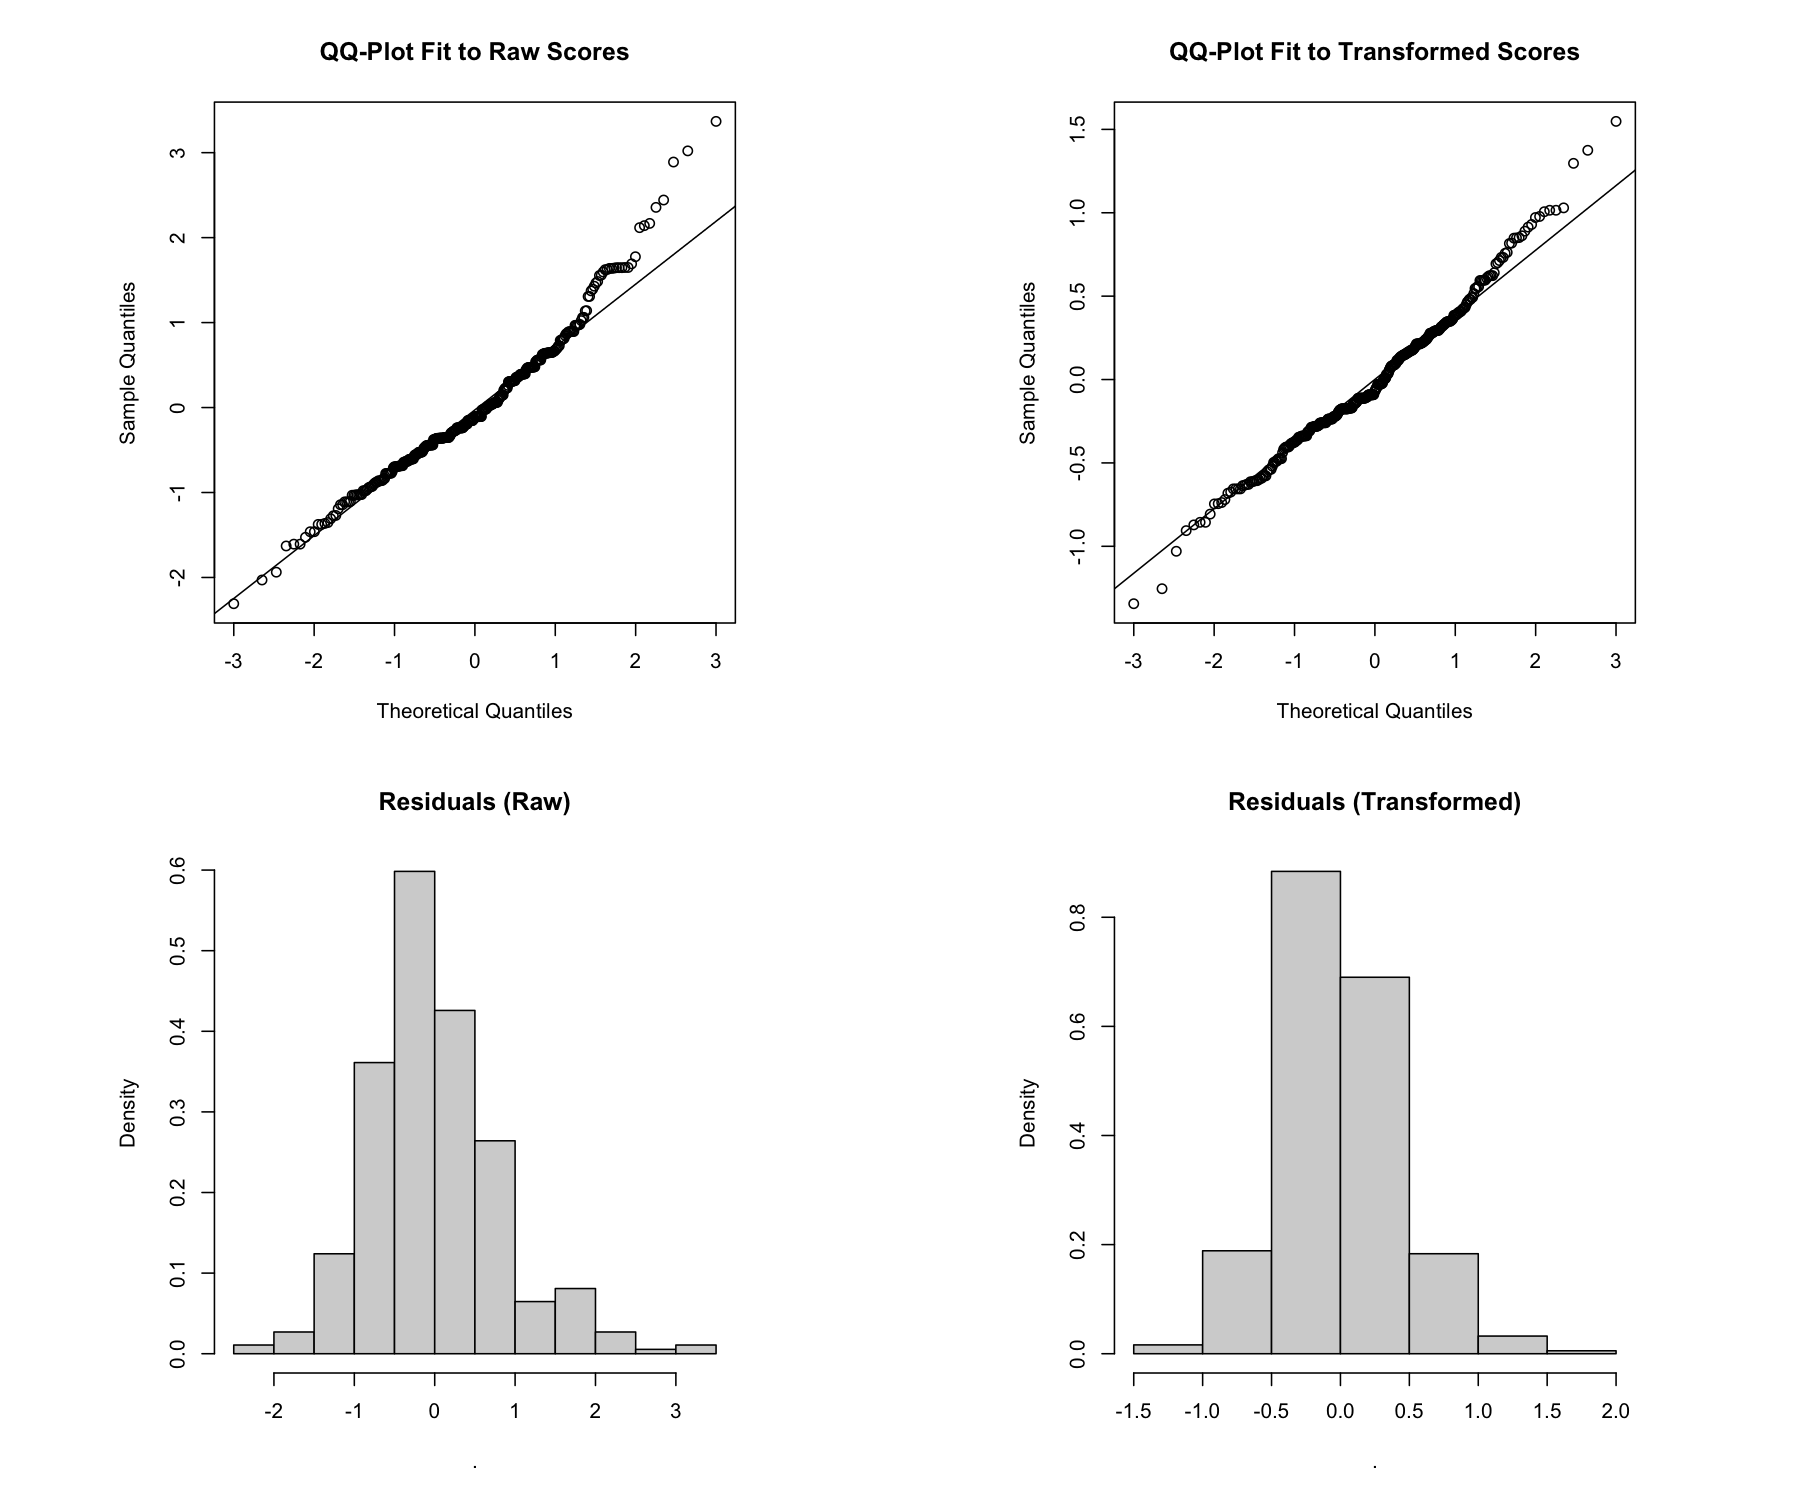

In [47]:
print(car::Anova(sp_complacency$model, type = "III"))
plot_qqs_hist(sp_complacency)